In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-OneCycle
Time: Tue Nov 17 02:34:08 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

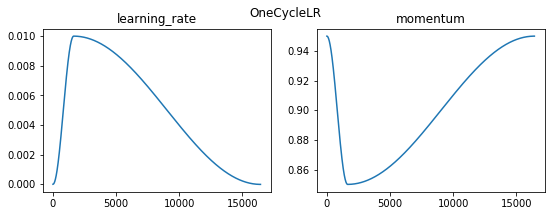

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.DiffGrad
CFG.optim_param = optim_param

scheduler_param = {
    'pct_start': 0.1,
    'div_factor': 1e3,
    'max_lr': 1e-2,
    'epochs': CFG.epochs,
    'pct_start':0.1,
    'final_div_factor':10000.0,
    'steps_per_epoch': len(trn_loader)
}
CFG.scheduler = optim.lr_scheduler.OneCycleLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [45]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
optim_list = [
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, LookaheadAdam,
     LookaheadDiffGrad, LookaheadYogi, LookaheadAdamW
]

# train

In [21]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [22]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.021813450779994963
epoch2 save best model... 0.018909885511141703
epoch3 save best model... 0.018341568979627722
epoch4 save best model... 0.01771289001395056
epoch5 save best model... 0.01737527947423127
epoch6 save best model... 0.017150098595403323
epoch8 save best model... 0.01700351691734818
epoch9 save best model... 0.016941638418169935
epoch10 save best model... 0.01693360830629605
epoch11 save best model... 0.01678750630985767
epoch12 save best model... 0.016695210004993345
epoch13 save best model... 0.016620582440583745
epoch14 save best model... 0.016583329767565793
epoch15 save best model... 0.016549250772031943
epoch16 save best model... 0.016465788014691347
epoch17 save best model... 0.016368734046545277
epoch18 save best model... 0.016314907545533566
epoch19 save best model... 0.01630545928862141
epoch20 save best model... 0.016203627216890625
fold0 score: 0.016203627233017104


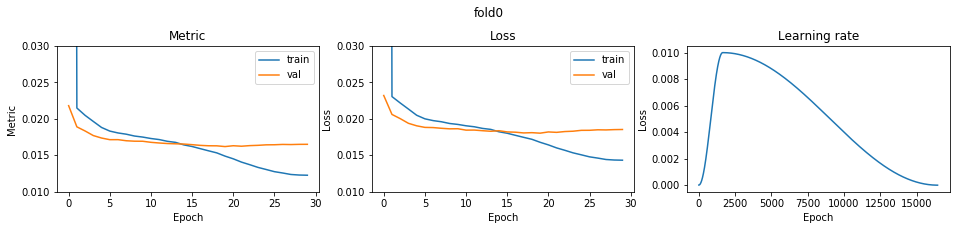

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.02178666374789783
epoch2 save best model... 0.01901003932777693
epoch3 save best model... 0.018652291040325196
epoch4 save best model... 0.01789712712043923
epoch5 save best model... 0.017604362031567556
epoch6 save best model... 0.017440928968709784
epoch9 save best model... 0.017123914059989136
epoch12 save best model... 0.01699911705524877
epoch14 save best model... 0.016841490660690316
epoch15 save best model... 0.01675174691039355
epoch16 save best model... 0.016703704295021698
epoch17 save best model... 0.01661695842965368
epoch20 save best model... 0.016555930288985124
fold1 score: 0.016555930195381045


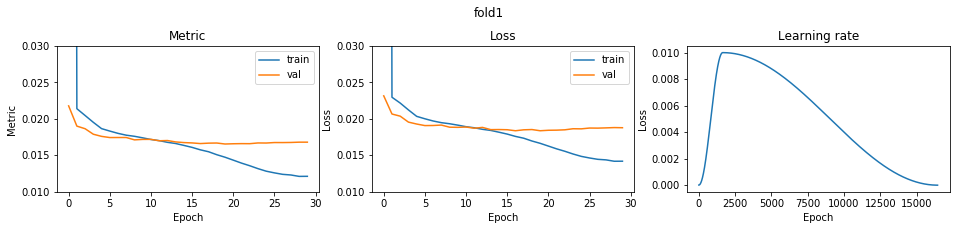

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.02173449831984396
epoch2 save best model... 0.018863287402962423
epoch3 save best model... 0.018419783135486045
epoch4 save best model... 0.01799865434696148
epoch5 save best model... 0.01750560168823659
epoch7 save best model... 0.017210727731539602
epoch8 save best model... 0.01705806580872722
epoch10 save best model... 0.017034750888206864
epoch11 save best model... 0.01684183652045264
epoch13 save best model... 0.016771732309421937
epoch14 save best model... 0.01664779812465071
epoch15 save best model... 0.016624830639438384
epoch16 save best model... 0.016468499351091688
epoch17 save best model... 0.01639385036716743
epoch18 save best model... 0.016386002059419053
epoch19 save best model... 0.016338797139950685
epoch20 save best model... 0.016337812919993828
epoch21 save best model... 0.01631363696215208
fold2 score: 0.016313636917874765


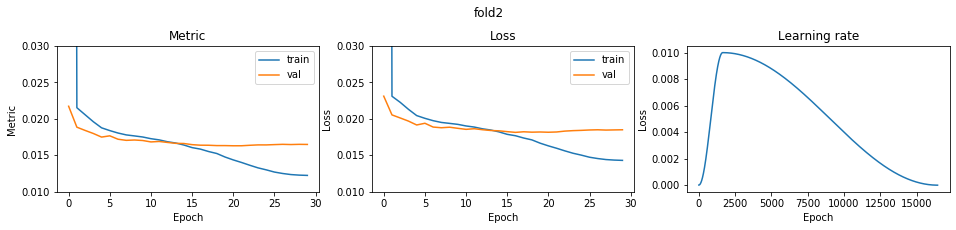

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.021723455103254265
epoch2 save best model... 0.019085662830663434
epoch3 save best model... 0.01840244665835265
epoch4 save best model... 0.017910721367288693
epoch5 save best model... 0.017767471942312353
epoch6 save best model... 0.01751483456827785
epoch7 save best model... 0.017382722298756818
epoch8 save best model... 0.017361057815746594
epoch9 save best model... 0.017289306082951587
epoch10 save best model... 0.017287987545302353
epoch11 save best model... 0.01699755576042488
epoch12 save best model... 0.01698744305386155
epoch14 save best model... 0.01678911960410094
epoch15 save best model... 0.016719260813502897
epoch16 save best model... 0.016666228303384538
epoch17 save best model... 0.01664186518232005
epoch18 save best model... 0.01655545790291525
epoch19 save best model... 0.016490116718825554
epoch21 save best model... 0.01642021080754816
fold3 score: 0.016420210735438173


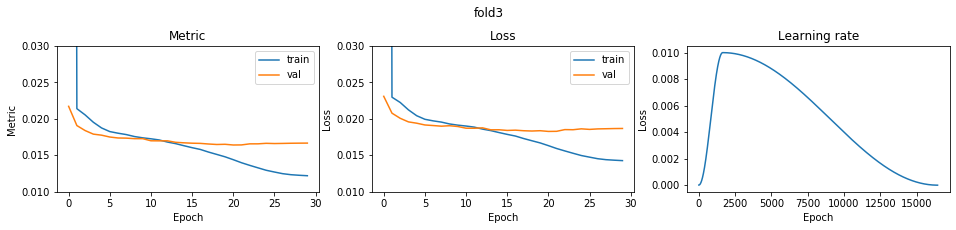

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.021864916140676087
epoch2 save best model... 0.018852512753549495
epoch3 save best model... 0.01822289296156453
epoch4 save best model... 0.017823188020455266
epoch5 save best model... 0.017525444558666753
epoch6 save best model... 0.01743652269643029
epoch7 save best model... 0.017416208775412792
epoch8 save best model... 0.017206523694725948
epoch9 save best model... 0.016994383369820672
epoch11 save best model... 0.016900803345194032
epoch13 save best model... 0.01676335313775341
epoch15 save best model... 0.016686180581451143
epoch17 save best model... 0.01662233144995292
epoch18 save best model... 0.016586594221209748
epoch19 save best model... 0.01644447395675614
fold4 score: 0.01644447393065383


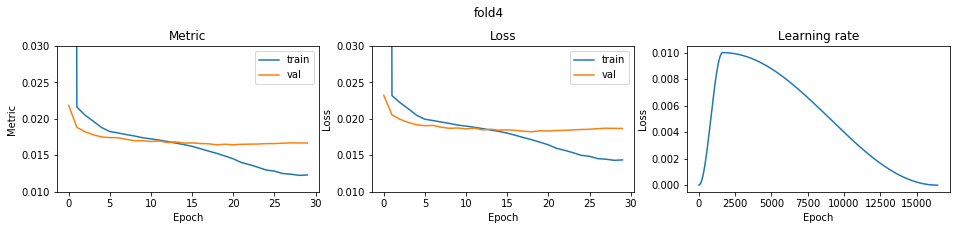

CV score: 0.016387571500691124

optimizer: AdaBound
fold 0


epoch1 save best model... 0.6600823320125936
epoch2 save best model... 0.15896001828830172
epoch3 save best model... 0.030775798801205425
epoch4 save best model... 0.024013530379818893
epoch5 save best model... 0.02213311537268629
epoch6 save best model... 0.021411076653112312
epoch7 save best model... 0.020976275029954985
epoch8 save best model... 0.02066643814851184
epoch9 save best model... 0.02046989740163156
epoch10 save best model... 0.02020786207143837
epoch11 save best model... 0.020106674040877737
epoch12 save best model... 0.01996630140429613
epoch13 save best model... 0.019907044567558107
epoch14 save best model... 0.0198104428538972
epoch15 save best model... 0.019771291881562094
epoch16 save best model... 0.019648857653174964
epoch17 save best model... 0.019639652786704292
epoch18 save best model... 0.01952187412403575
epoch20 save best model... 0.019462208028093557
epoch22 save best model... 0.019395969499216535
epoch25 save best model... 0.019356851949269515
epoch28 save

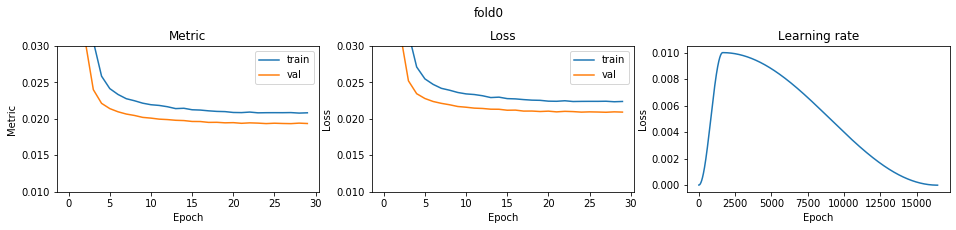

fold 1


epoch1 save best model... 0.6561208736328852
epoch2 save best model... 0.15148444733469763
epoch3 save best model... 0.030439068839772196
epoch4 save best model... 0.023766783995294548
epoch5 save best model... 0.022134014128396058
epoch6 save best model... 0.021476174542825948
epoch7 save best model... 0.021107982158301005
epoch8 save best model... 0.02081104000153113
epoch9 save best model... 0.02062879281496643
epoch10 save best model... 0.02044230490442519
epoch11 save best model... 0.020262794914163308
epoch12 save best model... 0.02021094950628555
epoch13 save best model... 0.02009420258566605
epoch14 save best model... 0.02003591249814254
epoch15 save best model... 0.019964229290904748
epoch16 save best model... 0.01989407328590428
epoch17 save best model... 0.0198172796780732
epoch18 save best model... 0.019751282142316952
epoch19 save best model... 0.019677842952570766
epoch20 save best model... 0.019663579156802655
epoch21 save best model... 0.01964188333856242
epoch22 save b

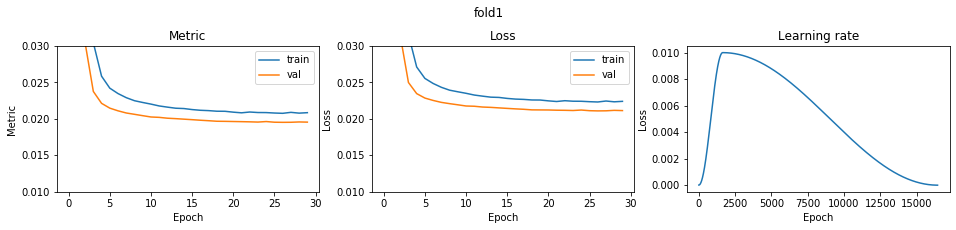

fold 2


epoch1 save best model... 0.6565344310154484
epoch2 save best model... 0.15230119640190526
epoch3 save best model... 0.030254184025876422
epoch4 save best model... 0.023724324397758026
epoch5 save best model... 0.02205888279407069
epoch6 save best model... 0.021346427988720173
epoch7 save best model... 0.02100083430158261
epoch8 save best model... 0.020712526975588744
epoch9 save best model... 0.020549982888880828
epoch10 save best model... 0.020370695395804696
epoch11 save best model... 0.02019366137148661
epoch12 save best model... 0.020030261684734502
epoch13 save best model... 0.019938925460683755
epoch14 save best model... 0.019914079181668317
epoch15 save best model... 0.019750832249218413
epoch16 save best model... 0.019710509087419316
epoch17 save best model... 0.019643575963974813
epoch18 save best model... 0.01959155762632199
epoch20 save best model... 0.019503917341373266
epoch22 save best model... 0.019458983959254546
epoch25 save best model... 0.01944509193201045
epoch26 s

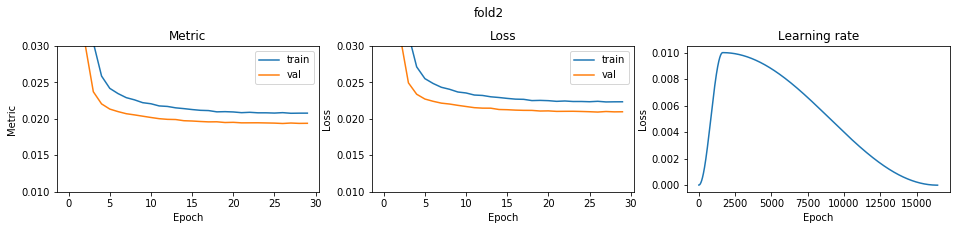

fold 3


epoch1 save best model... 0.6572485428736259
epoch2 save best model... 0.16136535784242365
epoch3 save best model... 0.03075572413419944
epoch4 save best model... 0.024012902569119098
epoch5 save best model... 0.022278572831956292
epoch6 save best model... 0.021514395435164622
epoch7 save best model... 0.021129054350434783
epoch8 save best model... 0.020810016943035744
epoch9 save best model... 0.020589806094494116
epoch10 save best model... 0.02039640452543057
epoch11 save best model... 0.020285075540168545
epoch12 save best model... 0.02018781710322734
epoch13 save best model... 0.02010069436909194
epoch14 save best model... 0.02000295984896074
epoch15 save best model... 0.019912897032984704
epoch16 save best model... 0.019864494114231683
epoch17 save best model... 0.019863066263496876
epoch18 save best model... 0.0197581181340853
epoch19 save best model... 0.01973849920925084
epoch20 save best model... 0.0196976838697062
epoch21 save best model... 0.019643839827159542
epoch23 save b

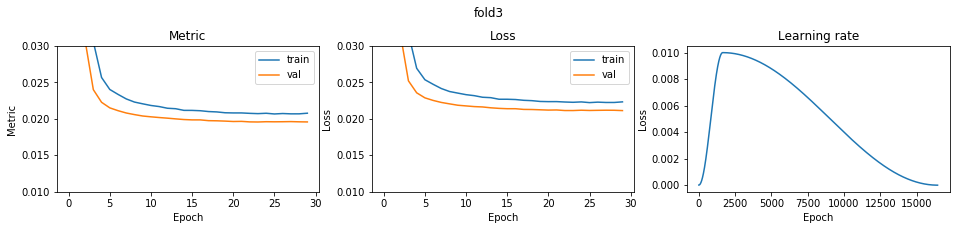

fold 4


epoch1 save best model... 0.660496197175871
epoch2 save best model... 0.15072891937573027
epoch3 save best model... 0.030369118321050544
epoch4 save best model... 0.023679708002945558
epoch5 save best model... 0.022044958000268643
epoch6 save best model... 0.021273900692378743
epoch7 save best model... 0.020874559507622535
epoch8 save best model... 0.020566872816218874
epoch9 save best model... 0.020349791027384902
epoch10 save best model... 0.020143367855009836
epoch11 save best model... 0.020038900005892087
epoch12 save best model... 0.019872792364694265
epoch13 save best model... 0.019823773494647957
epoch14 save best model... 0.019678734788556577
epoch15 save best model... 0.019607763685676394
epoch16 save best model... 0.019552547589860907
epoch17 save best model... 0.019500042629642476
epoch18 save best model... 0.019452351956269737
epoch19 save best model... 0.019425341649010677
epoch20 save best model... 0.019350425117481543
epoch22 save best model... 0.019329274780114855
epoch

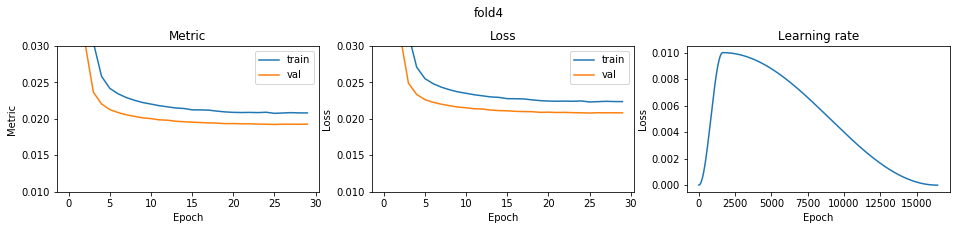

CV score: 0.019412330158617076

optimizer: AdaMod
fold 0


epoch1 save best model... 0.3753854025605056
epoch2 save best model... 0.020142872520385137
epoch3 save best model... 0.0184302229128761
epoch4 save best model... 0.018125703148458978
epoch5 save best model... 0.017801285786278428
epoch6 save best model... 0.01750233948722923
epoch7 save best model... 0.017140943445859303
epoch9 save best model... 0.01709427061429192
epoch10 save best model... 0.01680070267977503
epoch11 save best model... 0.01670088553737535
epoch12 save best model... 0.016680843395378297
epoch14 save best model... 0.016610296070151423
epoch15 save best model... 0.016554714849638778
epoch16 save best model... 0.01630245073441764
epoch21 save best model... 0.016288443767637488
epoch22 save best model... 0.016254887997187623
fold0 score: 0.016254887866750337


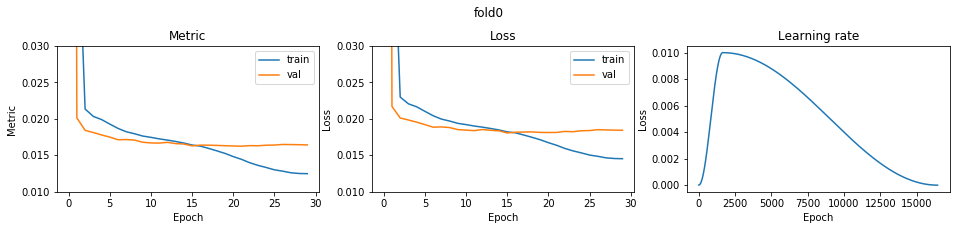

fold 1


epoch1 save best model... 0.3838231073992484
epoch2 save best model... 0.02032105081796809
epoch3 save best model... 0.01869332324862005
epoch4 save best model... 0.01802569583922414
epoch5 save best model... 0.01798214735096165
epoch6 save best model... 0.017777330746908588
epoch7 save best model... 0.017439601971755325
epoch9 save best model... 0.017222414376741664
epoch10 save best model... 0.017068025544642262
epoch11 save best model... 0.017004215294963328
epoch12 save best model... 0.0169946944617341
epoch14 save best model... 0.016796441333897634
epoch16 save best model... 0.016768235537121878
epoch17 save best model... 0.016699137346083578
epoch18 save best model... 0.016602530581276125
epoch19 save best model... 0.016538358243607963
epoch22 save best model... 0.016519025687699532
fold1 score: 0.016519025668391824


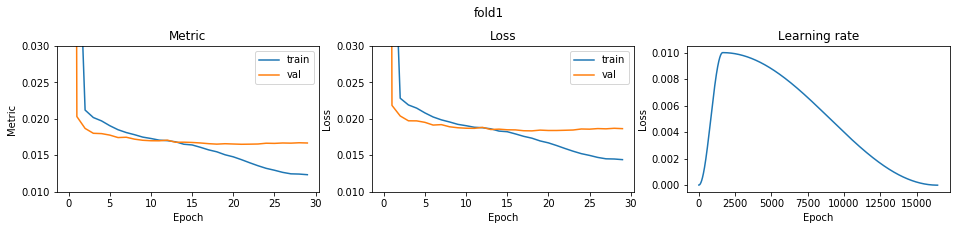

fold 2


epoch1 save best model... 0.3878386995601719
epoch2 save best model... 0.020507479838960722
epoch3 save best model... 0.018789516406260663
epoch4 save best model... 0.018412171029306458
epoch5 save best model... 0.017823216541421782
epoch6 save best model... 0.017653496717190888
epoch7 save best model... 0.017550724861121893
epoch8 save best model... 0.01718524155943506
epoch9 save best model... 0.017022269562151606
epoch11 save best model... 0.016976481446591887
epoch12 save best model... 0.01682382602860829
epoch14 save best model... 0.016619613570687194
epoch16 save best model... 0.016602965515920897
epoch17 save best model... 0.01652007971504713
epoch18 save best model... 0.016512845051478053
epoch19 save best model... 0.016481997261252903
epoch20 save best model... 0.01637168865740863
epoch21 save best model... 0.01632514640885813
epoch23 save best model... 0.016323396568749957
fold2 score: 0.016323396510194


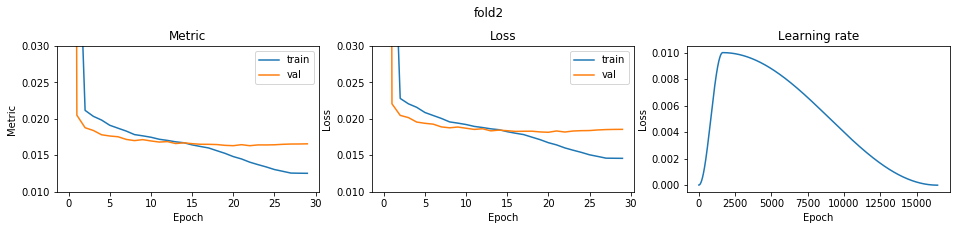

fold 3


epoch1 save best model... 0.4231772752041697
epoch2 save best model... 0.020408900259041435
epoch3 save best model... 0.01880939422782027
epoch4 save best model... 0.01831834079371023
epoch5 save best model... 0.01802534075424177
epoch6 save best model... 0.017706919908268982
epoch7 save best model... 0.017505482949554105
epoch8 save best model... 0.0174381156547466
epoch9 save best model... 0.017268011273056744
epoch10 save best model... 0.0171680685128499
epoch11 save best model... 0.017004208572225853
epoch12 save best model... 0.016910454871850025
epoch14 save best model... 0.016904995006621563
epoch16 save best model... 0.016662744770849076
epoch18 save best model... 0.016508905035029917
epoch20 save best model... 0.016497569923673103
epoch22 save best model... 0.016471996437970354
fold3 score: 0.01647199636569039


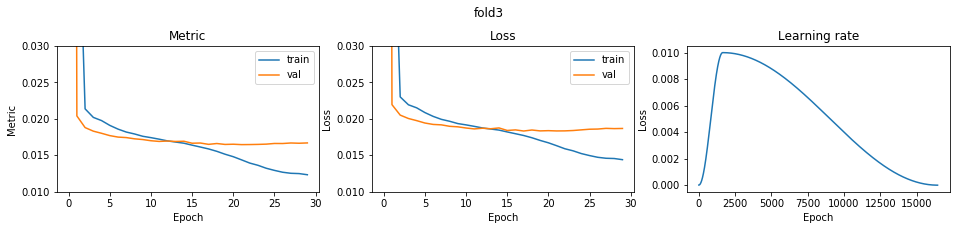

fold 4


epoch1 save best model... 0.36672145933388034
epoch2 save best model... 0.020098757989076656
epoch3 save best model... 0.018744716514114097
epoch4 save best model... 0.018028534278019006
epoch5 save best model... 0.01781217198063681
epoch6 save best model... 0.01759908419136374
epoch7 save best model... 0.01731451185280139
epoch9 save best model... 0.01707082359175408
epoch10 save best model... 0.017039560335253393
epoch11 save best model... 0.016888078161279813
epoch12 save best model... 0.01688357079422827
epoch14 save best model... 0.016764172153432847
epoch16 save best model... 0.0166674958677763
epoch17 save best model... 0.016644909602413823
epoch19 save best model... 0.016560723133605813
epoch21 save best model... 0.01649537699504974
epoch22 save best model... 0.0164807471414871
fold4 score: 0.01648074702998243


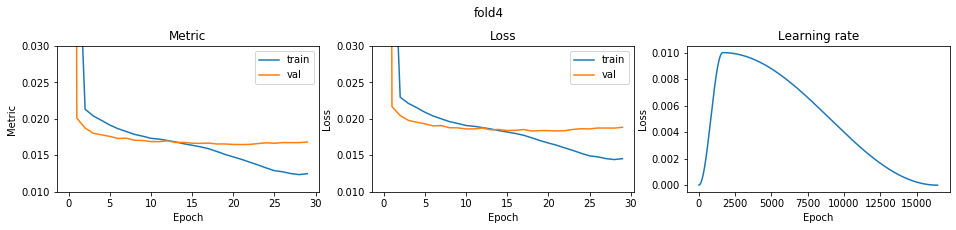

CV score: 0.016410009667571113

optimizer: AdamW
fold 0


epoch1 save best model... 0.02187231559145152
epoch2 save best model... 0.01944918466269427
epoch3 save best model... 0.01839427733305918
epoch4 save best model... 0.017733081589730835
epoch5 save best model... 0.01758055842835838
epoch6 save best model... 0.01739777103151303
epoch7 save best model... 0.01709413219472406
epoch8 save best model... 0.01703555079469784
epoch10 save best model... 0.016903870473011208
epoch11 save best model... 0.016826229127535515
epoch12 save best model... 0.01667875484022437
epoch13 save best model... 0.01667634247715218
epoch14 save best model... 0.016519831790077523
epoch16 save best model... 0.016461973527450633
epoch17 save best model... 0.016373762210877718
epoch19 save best model... 0.016321354918606187
epoch20 save best model... 0.01626212247615523
epoch21 save best model... 0.01625879853963852
epoch23 save best model... 0.016250499562362467
fold0 score: 0.016250499490240856


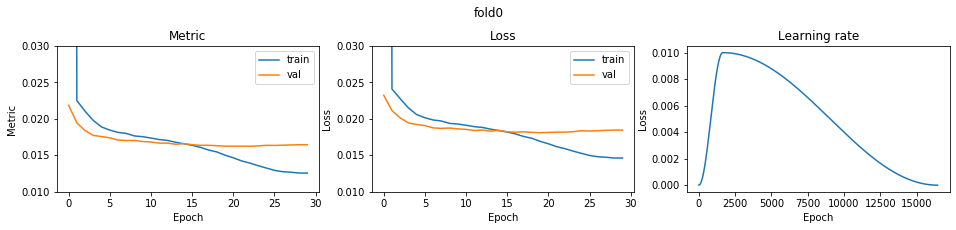

fold 1


epoch1 save best model... 0.02253720764385646
epoch2 save best model... 0.019569680288240507
epoch3 save best model... 0.019019110586836266
epoch4 save best model... 0.0179564475940613
epoch5 save best model... 0.017654317608334448
epoch6 save best model... 0.01757018616659396
epoch7 save best model... 0.017344244004423078
epoch8 save best model... 0.01724449466017628
epoch9 save best model... 0.01713642791273464
epoch10 save best model... 0.017086163189497263
epoch11 save best model... 0.016964757117731585
epoch12 save best model... 0.016911729947021104
epoch13 save best model... 0.01686978583706012
epoch16 save best model... 0.016783055244406226
epoch17 save best model... 0.016708738478883087
epoch19 save best model... 0.01661396742832127
epoch21 save best model... 0.01656239084397797
epoch22 save best model... 0.016497255476965303
fold1 score: 0.01649725540221804


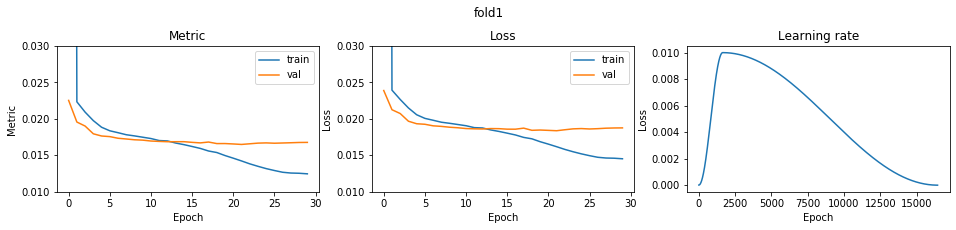

fold 2


epoch1 save best model... 0.022905216931084698
epoch2 save best model... 0.019317883671800134
epoch3 save best model... 0.018453821112306507
epoch4 save best model... 0.01792585960994429
epoch5 save best model... 0.017875869807231926
epoch6 save best model... 0.017439542047969707
epoch7 save best model... 0.017207250535050157
epoch8 save best model... 0.01705115702381796
epoch10 save best model... 0.01694540247044427
epoch11 save best model... 0.016794600660873862
epoch13 save best model... 0.01665488736524475
epoch14 save best model... 0.016637242864923477
epoch16 save best model... 0.01656074422874417
epoch17 save best model... 0.01641321990670376
epoch19 save best model... 0.01639747050989527
epoch20 save best model... 0.016391891206740505
epoch22 save best model... 0.016368282002503617
fold2 score: 0.016368281940754383


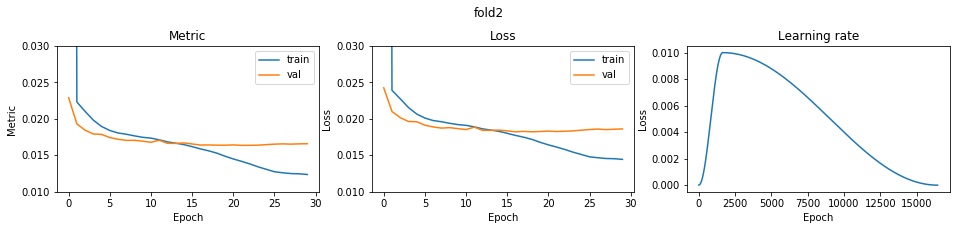

fold 3


epoch1 save best model... 0.022761409917256555
epoch2 save best model... 0.019374956584329757
epoch3 save best model... 0.01868016714684173
epoch4 save best model... 0.018182676673733158
epoch5 save best model... 0.017656363231174494
epoch6 save best model... 0.01748324787935798
epoch8 save best model... 0.01728901593290388
epoch9 save best model... 0.017174612584360503
epoch11 save best model... 0.017036227803838552
epoch12 save best model... 0.01698948844444168
epoch13 save best model... 0.01698808673226141
epoch14 save best model... 0.016868410565400314
epoch15 save best model... 0.016789137731159875
epoch16 save best model... 0.01676570096971777
epoch17 save best model... 0.01670933380459938
epoch18 save best model... 0.01666405062299383
epoch19 save best model... 0.016623934307018962
epoch22 save best model... 0.016589619885018447
fold3 score: 0.016589619828045462


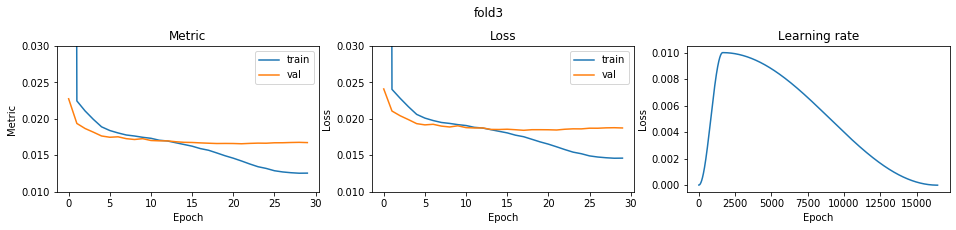

fold 4


epoch1 save best model... 0.022339335569352387
epoch2 save best model... 0.019124954576542546
epoch3 save best model... 0.018306550599108525
epoch4 save best model... 0.017849650163551396
epoch5 save best model... 0.017591955776247864
epoch6 save best model... 0.017469082156658714
epoch7 save best model... 0.017237660806023587
epoch8 save best model... 0.01718933684772606
epoch10 save best model... 0.016942709756077423
epoch12 save best model... 0.016915874218818537
epoch13 save best model... 0.016864123436408054
epoch14 save best model... 0.01671786968954807
epoch15 save best model... 0.01669891262448187
epoch17 save best model... 0.01665426229417392
epoch18 save best model... 0.016484973582615206
epoch20 save best model... 0.016455974491368257
fold4 score: 0.01645597435882651


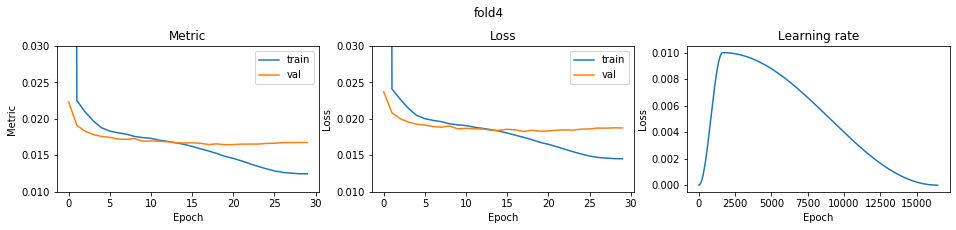

CV score: 0.016432326163697435

optimizer: AdamP
fold 0


epoch1 save best model... 0.021704798672933786
epoch2 save best model... 0.01947137913953063
epoch3 save best model... 0.018548164260414574
epoch4 save best model... 0.017890704300144267
epoch5 save best model... 0.01756821316762367
epoch6 save best model... 0.01735390968926268
epoch7 save best model... 0.01729377359915567
epoch8 save best model... 0.017138993153709214
epoch9 save best model... 0.017082438150374114
epoch10 save best model... 0.016909857891109648
epoch12 save best model... 0.016880910225416233
epoch13 save best model... 0.016766112295227606
epoch14 save best model... 0.01660270788208295
epoch15 save best model... 0.016591932131550306
epoch16 save best model... 0.016499772729407274
epoch17 save best model... 0.01638288638832425
epoch18 save best model... 0.016302591207986675
epoch20 save best model... 0.016170271351967424
epoch23 save best model... 0.016146330677974198
fold0 score: 0.016146330641588064


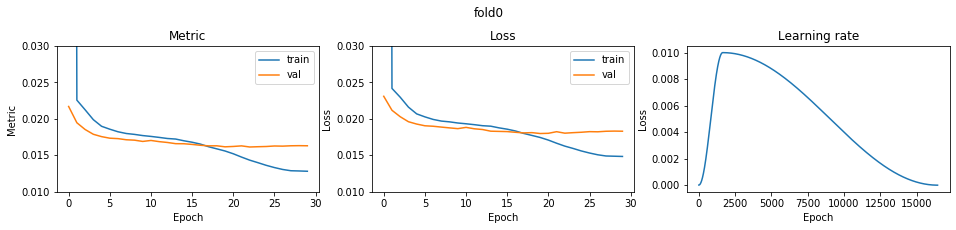

fold 1


epoch1 save best model... 0.022328898893772375
epoch2 save best model... 0.02004304518135921
epoch3 save best model... 0.018667298859067212
epoch4 save best model... 0.018177849051111188
epoch5 save best model... 0.017777967180799558
epoch6 save best model... 0.01748244868904203
epoch7 save best model... 0.01740402145887133
epoch8 save best model... 0.017326662380152395
epoch9 save best model... 0.01715629551653901
epoch11 save best model... 0.01709615829445067
epoch13 save best model... 0.017021438384232975
epoch15 save best model... 0.01685372480494941
epoch16 save best model... 0.016732998998650224
epoch18 save best model... 0.016730915161737088
epoch19 save best model... 0.016523130451736253
epoch20 save best model... 0.016485141581113246
epoch23 save best model... 0.016444360384729042
fold1 score: 0.016444360269033603


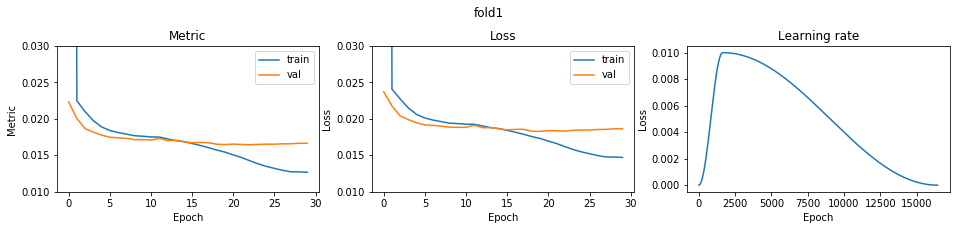

fold 2


epoch1 save best model... 0.021958029903446006
epoch2 save best model... 0.019520756261884542
epoch3 save best model... 0.01851827409827144
epoch4 save best model... 0.017997675226680047
epoch5 save best model... 0.01766092630133362
epoch6 save best model... 0.017428053969907365
epoch7 save best model... 0.01730752926053321
epoch8 save best model... 0.017149813220500743
epoch9 save best model... 0.0171478761996209
epoch10 save best model... 0.017027571770634378
epoch12 save best model... 0.016929839257092322
epoch14 save best model... 0.016809927610059578
epoch15 save best model... 0.016806455111773172
epoch16 save best model... 0.016558269617663587
epoch18 save best model... 0.016468724487767414
epoch19 save best model... 0.01638252302850636
epoch21 save best model... 0.016376726984796083
epoch22 save best model... 0.01632536559856496
fold2 score: 0.016325365420998633


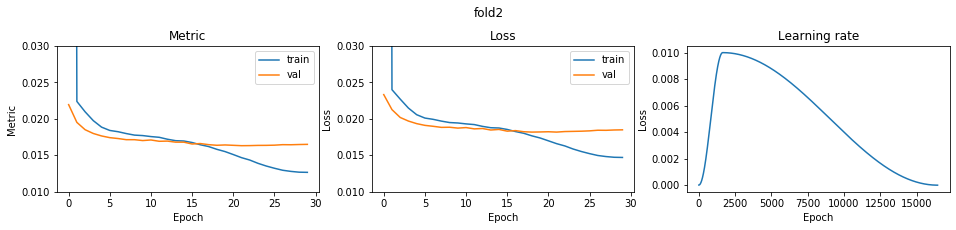

fold 3


epoch1 save best model... 0.022859021930494994
epoch2 save best model... 0.01936900467189678
epoch3 save best model... 0.018819980666143203
epoch4 save best model... 0.018054129719598418
epoch5 save best model... 0.017773856402953963
epoch6 save best model... 0.017572509792711848
epoch7 save best model... 0.01751238465954068
epoch8 save best model... 0.017465257530942864
epoch9 save best model... 0.017186901866456234
epoch10 save best model... 0.017124505599447292
epoch12 save best model... 0.016988409565154947
epoch15 save best model... 0.016875327770133633
epoch16 save best model... 0.01680317569634366
epoch17 save best model... 0.01675189750307242
epoch18 save best model... 0.016571711582091374
epoch19 save best model... 0.016487956066999866
epoch21 save best model... 0.016472683989512894
epoch24 save best model... 0.016466527483118422
fold3 score: 0.016466527423275583


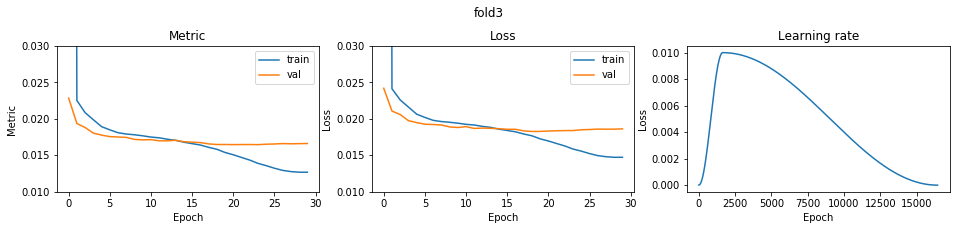

fold 4


epoch1 save best model... 0.021800859856306826
epoch2 save best model... 0.019175431202749185
epoch3 save best model... 0.018383024447090533
epoch4 save best model... 0.017974418196784744
epoch5 save best model... 0.017598201562321676
epoch6 save best model... 0.01740392453603633
epoch7 save best model... 0.017371879093315036
epoch8 save best model... 0.01728631140057481
epoch9 save best model... 0.017088908604972048
epoch11 save best model... 0.01705084601989979
epoch12 save best model... 0.01695663079890955
epoch14 save best model... 0.01680098132936789
epoch16 save best model... 0.01673513318969951
epoch17 save best model... 0.016614301728852653
epoch18 save best model... 0.016511138112778545
epoch19 save best model... 0.01645854642457734
epoch21 save best model... 0.01638061114308978
fold4 score: 0.0163806109720774


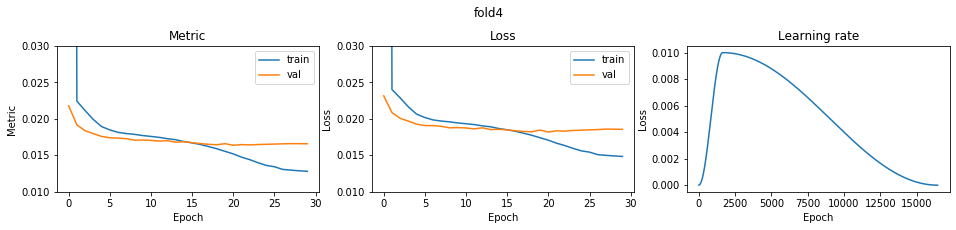

CV score: 0.016352636009008686

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.03224156280483092
epoch2 save best model... 0.019581689431856054
epoch3 save best model... 0.01852296637052963
epoch4 save best model... 0.01793637256263193
epoch5 save best model... 0.017689089702785966
epoch6 save best model... 0.017342686843220358
epoch7 save best model... 0.017261779100415646
epoch8 save best model... 0.01700262329318393
epoch9 save best model... 0.016966200927123937
epoch10 save best model... 0.01696080642334421
epoch11 save best model... 0.016753106041554708
epoch12 save best model... 0.016727894653220384
epoch13 save best model... 0.01671400078421709
epoch14 save best model... 0.016614361724271047
epoch16 save best model... 0.016539963376379502
epoch17 save best model... 0.016478273025575967
epoch18 save best model... 0.0163553946759713
epoch20 save best model... 0.01631591402817356
epoch21 save best model... 0.01626411527013385
fold0 score: 0.016264115109355857


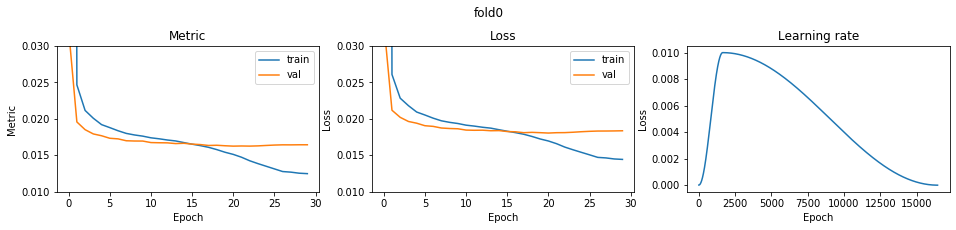

fold 1


epoch1 save best model... 0.031440658441781455
epoch2 save best model... 0.019878433789827878
epoch3 save best model... 0.018984829954757157
epoch4 save best model... 0.01814550200320643
epoch5 save best model... 0.017698874692420912
epoch7 save best model... 0.017472537706770964
epoch8 save best model... 0.017364157054392506
epoch9 save best model... 0.017286445634423886
epoch10 save best model... 0.01713038715547705
epoch11 save best model... 0.017044220443948252
epoch12 save best model... 0.016963430765000256
epoch13 save best model... 0.01693643362567552
epoch14 save best model... 0.016853516115909913
epoch16 save best model... 0.01675560803161745
epoch17 save best model... 0.01671943280486847
epoch18 save best model... 0.016640464517447693
epoch19 save best model... 0.01657112939022252
epoch20 save best model... 0.016485614898597824
fold1 score: 0.016485614791856815


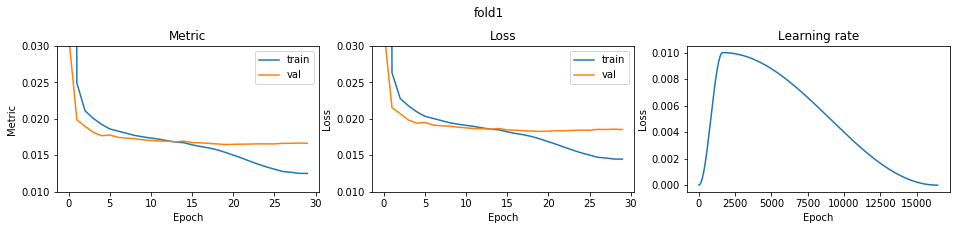

fold 2


epoch1 save best model... 0.03270285901154981
epoch2 save best model... 0.02035523332421167
epoch3 save best model... 0.018726721742311585
epoch4 save best model... 0.01802787172535295
epoch5 save best model... 0.01783271960907345
epoch6 save best model... 0.017505523825085946
epoch7 save best model... 0.017309906414191594
epoch8 save best model... 0.017214208948269985
epoch10 save best model... 0.017044724685628638
epoch11 save best model... 0.016840905482218935
epoch12 save best model... 0.016721379335678556
epoch14 save best model... 0.016699062777255778
epoch15 save best model... 0.01662706208047596
epoch17 save best model... 0.01653714444552794
epoch18 save best model... 0.01643351459904137
epoch19 save best model... 0.016395301935359527
epoch20 save best model... 0.016394351076230315
epoch21 save best model... 0.016314404103951647
fold2 score: 0.01631440394920091


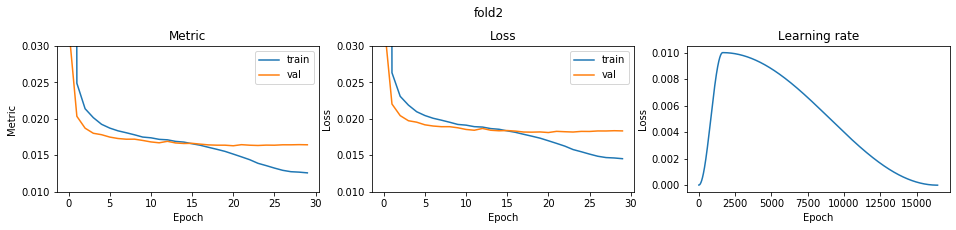

fold 3


epoch1 save best model... 0.03243246325514447
epoch2 save best model... 0.02019388744170546
epoch3 save best model... 0.01870037381726069
epoch4 save best model... 0.01819016056640205
epoch5 save best model... 0.017818323649669697
epoch6 save best model... 0.017747867019138466
epoch7 save best model... 0.017544205927614607
epoch8 save best model... 0.017446099964642987
epoch9 save best model... 0.017359111674876717
epoch10 save best model... 0.017134766326474708
epoch11 save best model... 0.017008356474645454
epoch12 save best model... 0.016978624076126377
epoch13 save best model... 0.016922921983096622
epoch14 save best model... 0.016900012198759237
epoch15 save best model... 0.016773968353307463
epoch16 save best model... 0.016748053117619153
epoch17 save best model... 0.016712855624039243
epoch18 save best model... 0.016636450082946203
epoch19 save best model... 0.016560859309937934
epoch20 save best model... 0.016501914365705025
epoch26 save best model... 0.016501630293226596
fold3

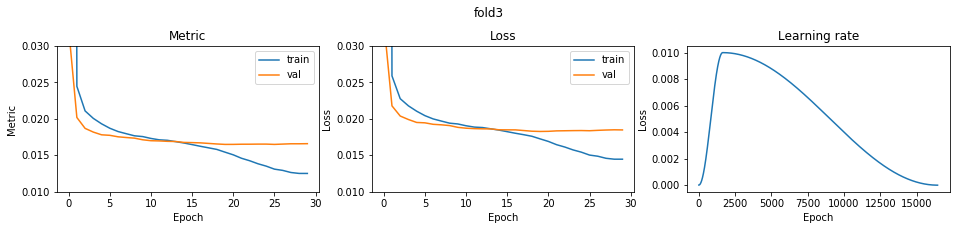

fold 4


epoch1 save best model... 0.031080298929354325
epoch2 save best model... 0.01969825385694216
epoch3 save best model... 0.01885377978163523
epoch4 save best model... 0.017911429102012807
epoch5 save best model... 0.017586468025651635
epoch6 save best model... 0.01747834178404819
epoch7 save best model... 0.017349747220024567
epoch8 save best model... 0.017111574909342175
epoch10 save best model... 0.01705468124699416
epoch11 save best model... 0.01693241558841733
epoch13 save best model... 0.01689164444659932
epoch14 save best model... 0.01674299222673873
epoch15 save best model... 0.016722806365333142
epoch16 save best model... 0.01665854604112871
epoch17 save best model... 0.016648568625822834
epoch18 save best model... 0.01649009232878142
epoch21 save best model... 0.016472112263949557
epoch23 save best model... 0.01645323281093651
fold4 score: 0.016453232630556435


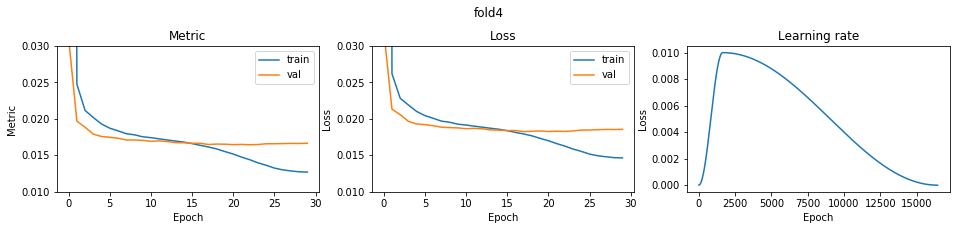

CV score: 0.016403799691823876

optimizer: Lamb
fold 0


epoch1 save best model... 0.6838152836830035
epoch2 save best model... 0.49533348530191496
epoch3 save best model... 0.03206974831929511
epoch4 save best model... 0.018323314368962427
epoch5 save best model... 0.017705629244955907
epoch6 save best model... 0.01729064620012982
epoch7 save best model... 0.017086817327555872
epoch8 save best model... 0.016882236180551232
epoch9 save best model... 0.016692243030205674
epoch10 save best model... 0.016570901075602936
epoch11 save best model... 0.016435189794214412
epoch12 save best model... 0.01641948979415831
epoch13 save best model... 0.01636517729423516
epoch14 save best model... 0.016327237271638016
epoch15 save best model... 0.016311197419457798
epoch18 save best model... 0.01630613638728789
fold0 score: 0.0163061362969327


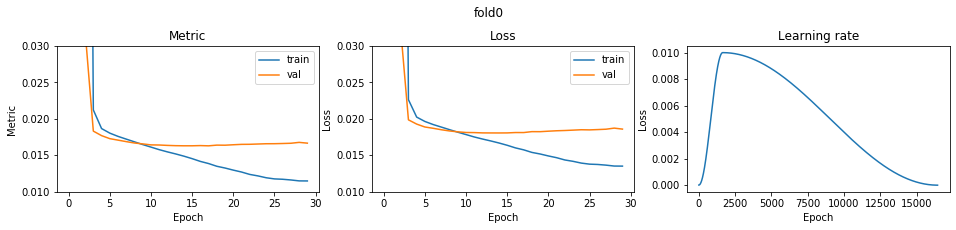

fold 1


epoch1 save best model... 0.6833441778423304
epoch2 save best model... 0.49235331830877355
epoch3 save best model... 0.03210383135503708
epoch4 save best model... 0.01862752766832862
epoch5 save best model... 0.01780674671917631
epoch6 save best model... 0.017509614095163117
epoch7 save best model... 0.0174169237993863
epoch8 save best model... 0.0171505499272133
epoch9 save best model... 0.01693137398884668
epoch10 save best model... 0.016847591321362834
epoch11 save best model... 0.0167168111931452
epoch12 save best model... 0.01659627915180729
epoch13 save best model... 0.016587082747523633
epoch16 save best model... 0.016584871152632734
fold1 score: 0.01658487105599797


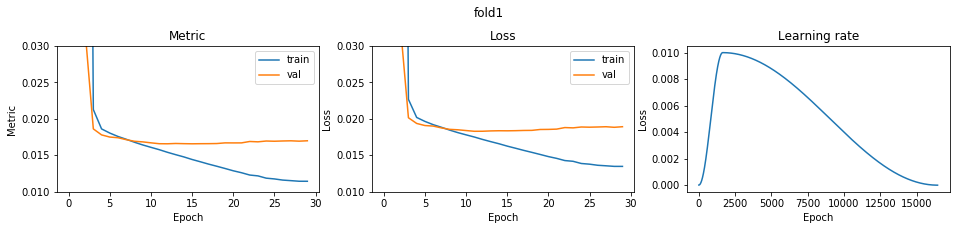

fold 2


epoch1 save best model... 0.6832544188967705
epoch2 save best model... 0.47371501450278974
epoch3 save best model... 0.030389389177238133
epoch4 save best model... 0.018297744498138927
epoch5 save best model... 0.017938833630256106
epoch6 save best model... 0.017416697159735452
epoch7 save best model... 0.017149904237813547
epoch8 save best model... 0.01702494907608151
epoch9 save best model... 0.016899365645498682
epoch10 save best model... 0.016713363514000653
epoch11 save best model... 0.016651188714294357
epoch12 save best model... 0.016456523509329028
epoch15 save best model... 0.016424572755200467
epoch17 save best model... 0.016423856910835043
fold2 score: 0.016423856842913153


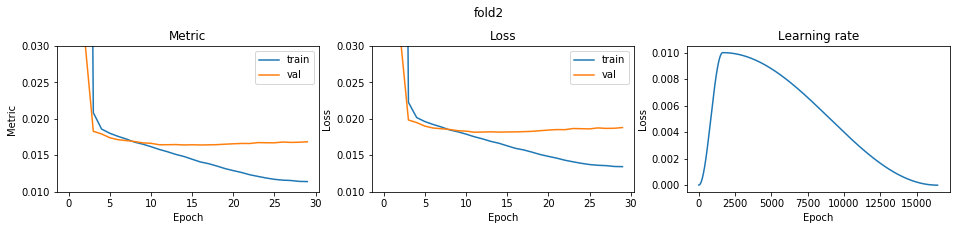

fold 3


epoch1 save best model... 0.6842592594563826
epoch2 save best model... 0.49012024876468546
epoch3 save best model... 0.03170812218821266
epoch4 save best model... 0.01848754716617032
epoch5 save best model... 0.017941526519155857
epoch6 save best model... 0.017556817137163158
epoch7 save best model... 0.017313887004089246
epoch8 save best model... 0.017115931861645676
epoch9 save best model... 0.016941020476519384
epoch10 save best model... 0.016867590943830838
epoch11 save best model... 0.01674055605914639
epoch12 save best model... 0.016674390121666473
epoch13 save best model... 0.01661258267073262
epoch14 save best model... 0.016563380585563347
epoch15 save best model... 0.01652560746191167
fold3 score: 0.016525607548214246


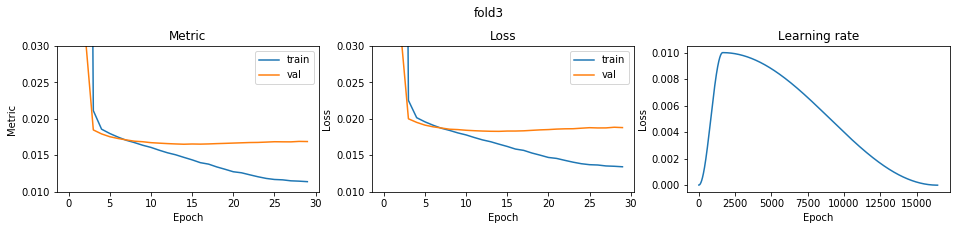

fold 4


epoch1 save best model... 0.6827734671312475
epoch2 save best model... 0.4900092232879039
epoch3 save best model... 0.03174379760811025
epoch4 save best model... 0.018292553351177986
epoch5 save best model... 0.01772358007474478
epoch6 save best model... 0.01749029260867006
epoch7 save best model... 0.01715306756606406
epoch8 save best model... 0.017012640760876323
epoch9 save best model... 0.01685989217701154
epoch11 save best model... 0.016670677960682702
epoch12 save best model... 0.016620213556652868
epoch14 save best model... 0.01659740175423902
fold4 score: 0.016597401764070586


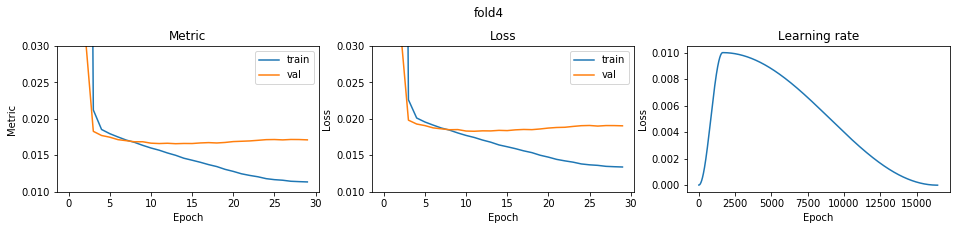

CV score: 0.01648757317171432

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.0531811293189102
epoch2 save best model... 0.019185088818430358
epoch3 save best model... 0.018044905670004174
epoch4 save best model... 0.017563602181495188
epoch5 save best model... 0.017325667534575102
epoch6 save best model... 0.01711220779373461
epoch7 save best model... 0.01681903384558025
epoch8 save best model... 0.016686634932366752
epoch9 save best model... 0.016556929986168693
epoch10 save best model... 0.016446059377087548
epoch11 save best model... 0.016386509522931452
epoch12 save best model... 0.01631647214921433
epoch13 save best model... 0.016256990719052
epoch14 save best model... 0.016221256969085045
epoch15 save best model... 0.01620294514169454
epoch16 save best model... 0.01612165020375697
epoch18 save best model... 0.016113578374571842
epoch19 save best model... 0.016102480133125614
epoch22 save best model... 0.01607593910721956
epoch24 save best model... 0.016075804145637567
fold0 score: 0.016075803976038295


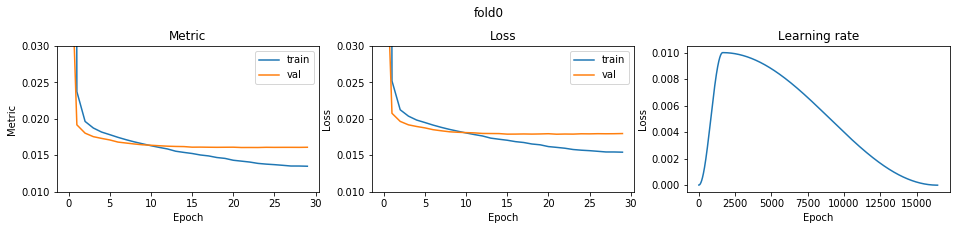

fold 1


epoch1 save best model... 0.05513784012233757
epoch2 save best model... 0.01933877207304859
epoch3 save best model... 0.018218671065693866
epoch4 save best model... 0.017780812498369637
epoch5 save best model... 0.017532222771643236
epoch6 save best model... 0.017311390026330975
epoch7 save best model... 0.01712528294990827
epoch8 save best model... 0.01705004843866453
epoch9 save best model... 0.016881587411160078
epoch10 save best model... 0.016774471887398158
epoch11 save best model... 0.016720123968867375
epoch12 save best model... 0.016659218839168766
epoch13 save best model... 0.016623354920305568
epoch14 save best model... 0.01658631154962222
epoch16 save best model... 0.01658294456282036
epoch17 save best model... 0.016489960307984913
fold1 score: 0.016489960303091543


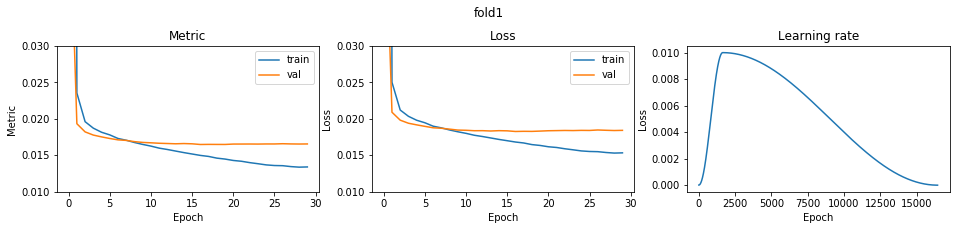

fold 2


epoch1 save best model... 0.054941579458463105
epoch2 save best model... 0.01921612118903652
epoch3 save best model... 0.01809067380232416
epoch4 save best model... 0.01764041996429642
epoch5 save best model... 0.017311208012924836
epoch6 save best model... 0.01705331592779207
epoch7 save best model... 0.016991259234599425
epoch8 save best model... 0.016707241665686514
epoch9 save best model... 0.016548161017399737
epoch11 save best model... 0.016460640809829116
epoch12 save best model... 0.016375775098220094
epoch13 save best model... 0.01635578874601308
epoch14 save best model... 0.016270683551668497
epoch15 save best model... 0.016230750866964253
epoch17 save best model... 0.01622402952976761
epoch21 save best model... 0.016220188406833987
fold2 score: 0.016220188296581582


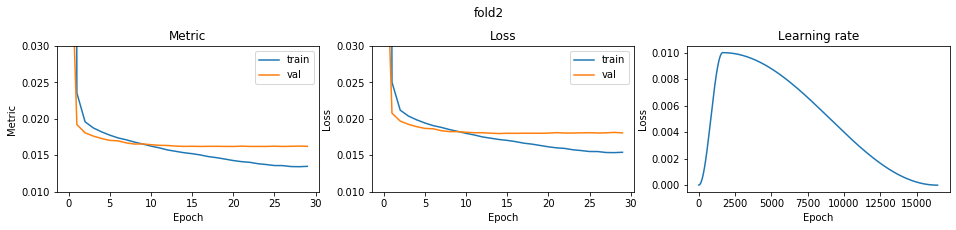

fold 3


epoch1 save best model... 0.056039608339513894
epoch2 save best model... 0.01936140897851395
epoch3 save best model... 0.018237735572056782
epoch4 save best model... 0.017722713971480827
epoch5 save best model... 0.01749918217683775
epoch6 save best model... 0.017282696241822628
epoch7 save best model... 0.01715468672021443
epoch8 save best model... 0.01695584789860425
epoch9 save best model... 0.016848923206108715
epoch10 save best model... 0.016763438499513547
epoch11 save best model... 0.01668937817589297
epoch12 save best model... 0.016617575089674198
epoch13 save best model... 0.016590107159353877
epoch14 save best model... 0.01647524562640994
epoch17 save best model... 0.016448936694999628
epoch18 save best model... 0.016425831293038057
epoch19 save best model... 0.01642335525211074
epoch20 save best model... 0.016417425142384742
epoch21 save best model... 0.01641558039050914
epoch22 save best model... 0.016405554010123353
fold3 score: 0.01640555398245403


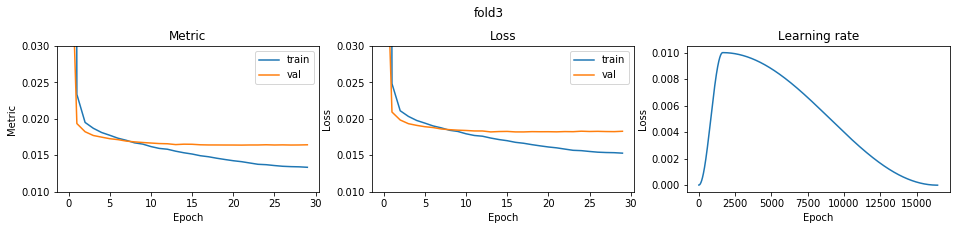

fold 4


epoch1 save best model... 0.05458881187853074
epoch2 save best model... 0.01909309660672191
epoch3 save best model... 0.018078518074201015
epoch4 save best model... 0.017700142828760358
epoch5 save best model... 0.017336614325150407
epoch6 save best model... 0.017180685718079226
epoch7 save best model... 0.016993637200113987
epoch8 save best model... 0.01692183580639897
epoch9 save best model... 0.016828333564815463
epoch10 save best model... 0.016722133314419445
epoch11 save best model... 0.016607839375276094
epoch12 save best model... 0.016555035207632733
epoch14 save best model... 0.016458998974794543
epoch16 save best model... 0.01643726999886283
epoch17 save best model... 0.016405905443317933
epoch18 save best model... 0.016401014743046092
epoch20 save best model... 0.01638685720580246
epoch21 save best model... 0.016358252397498673
epoch22 save best model... 0.016336704851690347
epoch23 save best model... 0.01633667600148088
fold4 score: 0.01633667582989471


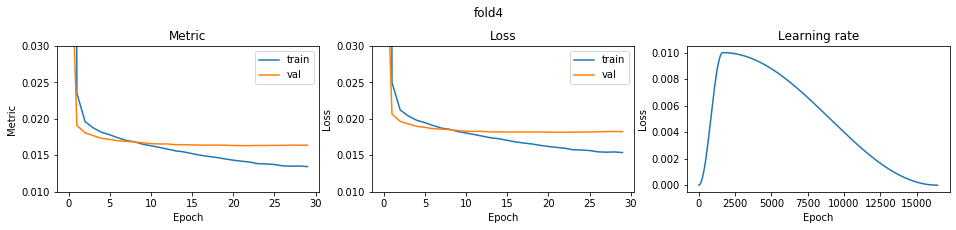

CV score: 0.016305631972616384

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.03593875229664164
epoch2 save best model... 0.020278693365616246
epoch3 save best model... 0.018728863404626726
epoch4 save best model... 0.017946874505600518
epoch5 save best model... 0.017741479390302933
epoch6 save best model... 0.017422543421964712
epoch7 save best model... 0.01720565876463144
epoch9 save best model... 0.017008870172235853
epoch10 save best model... 0.016920435293694292
epoch11 save best model... 0.016893139644472907
epoch12 save best model... 0.01676859616011313
epoch13 save best model... 0.016675077002402183
epoch14 save best model... 0.01667012634574688
epoch16 save best model... 0.0165164880293309
epoch18 save best model... 0.016449400465214172
epoch19 save best model... 0.016346364059742192
epoch20 save best model... 0.016289591622922848
fold0 score: 0.016289591466300178


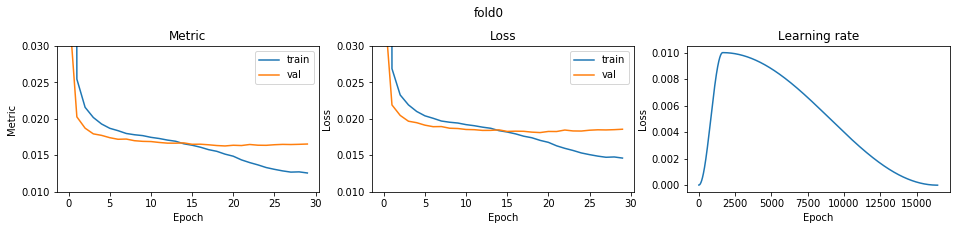

fold 1


epoch1 save best model... 0.039309998784502
epoch2 save best model... 0.019875608796691344
epoch3 save best model... 0.018597550062077767
epoch4 save best model... 0.018199081433562216
epoch5 save best model... 0.017932987023093185
epoch6 save best model... 0.01751525622811003
epoch8 save best model... 0.017324650754583847
epoch10 save best model... 0.017270524736547298
epoch11 save best model... 0.01712197750105717
epoch12 save best model... 0.017076722266673228
epoch13 save best model... 0.016920143798864508
epoch15 save best model... 0.01684360275132886
epoch16 save best model... 0.01678433968231683
epoch17 save best model... 0.016719817222531238
epoch18 save best model... 0.016624547086196057
epoch19 save best model... 0.016589862594750617
fold1 score: 0.016589862461199388


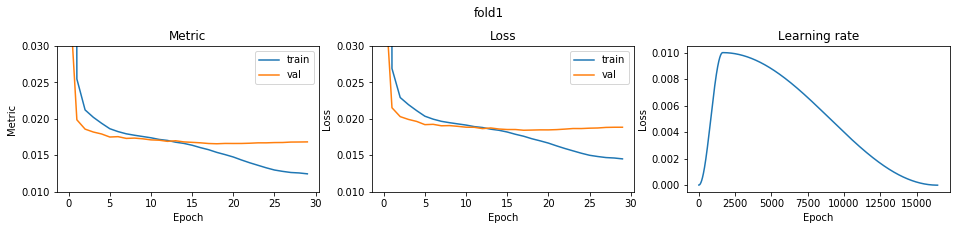

fold 2


epoch1 save best model... 0.039507468955667285
epoch2 save best model... 0.021334054109789592
epoch3 save best model... 0.01902111947488088
epoch4 save best model... 0.01803709930061486
epoch5 save best model... 0.01776151030412885
epoch6 save best model... 0.017410745945249637
epoch7 save best model... 0.01730653194795066
epoch8 save best model... 0.017187480069527146
epoch9 save best model... 0.017022883528230278
epoch11 save best model... 0.016922730700838374
epoch12 save best model... 0.016832022094837244
epoch14 save best model... 0.01681826995631799
epoch15 save best model... 0.016542386842900485
epoch18 save best model... 0.01649311216945738
epoch19 save best model... 0.016437339669445307
epoch20 save best model... 0.016362035071138207
epoch22 save best model... 0.016349795781369632
fold2 score: 0.01634979554069744


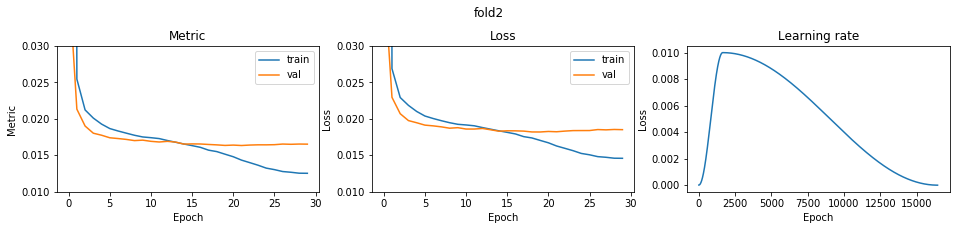

fold 3


epoch1 save best model... 0.03792232179458429
epoch2 save best model... 0.02009789330676911
epoch3 save best model... 0.01873793829368228
epoch4 save best model... 0.018351948702949733
epoch5 save best model... 0.017835969376061665
epoch6 save best model... 0.017553476731723562
epoch8 save best model... 0.017359513297235774
epoch9 save best model... 0.01728153572818752
epoch11 save best model... 0.017016623181488222
epoch13 save best model... 0.016950022756781827
epoch15 save best model... 0.016805333820657468
epoch16 save best model... 0.016730814567578273
epoch18 save best model... 0.016610628864165727
epoch20 save best model... 0.01659873165487225
epoch21 save best model... 0.016510042370400966
fold3 score: 0.01651004221915796


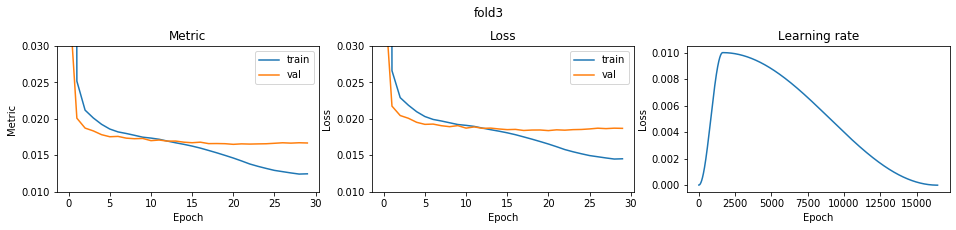

fold 4


epoch1 save best model... 0.039448787711543754
epoch2 save best model... 0.019680709584461258
epoch3 save best model... 0.018628233865938724
epoch4 save best model... 0.018089656116852457
epoch5 save best model... 0.017643334294387174
epoch6 save best model... 0.017528534234248966
epoch7 save best model... 0.017256427142590895
epoch8 save best model... 0.017110590907853256
epoch11 save best model... 0.016889624353201217
epoch14 save best model... 0.016838172629288904
epoch15 save best model... 0.016693301110237767
epoch16 save best model... 0.016626723733961853
epoch17 save best model... 0.016591094212356217
epoch18 save best model... 0.01654640128645104
epoch19 save best model... 0.01651714944019744
epoch20 save best model... 0.016425881924739868
fold4 score: 0.01642588179626658


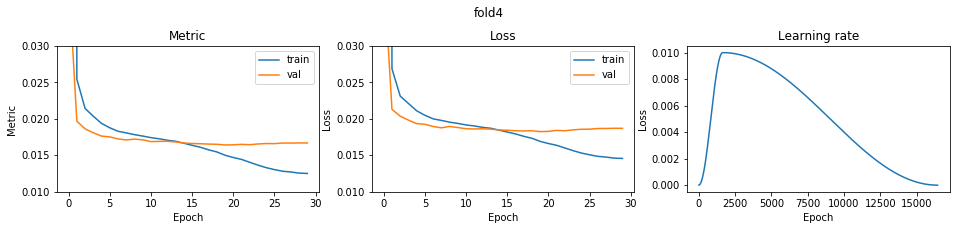

CV score: 0.016433031343862616

optimizer: QHAdam
fold 0


epoch1 save best model... 0.022462377234750294
epoch2 save best model... 0.01945870165927399
epoch3 save best model... 0.018739591884280392
epoch4 save best model... 0.01783208905683156
epoch5 save best model... 0.017647887830853734
epoch6 save best model... 0.017428908801737298
epoch7 save best model... 0.017324531951533093
epoch8 save best model... 0.017253408743098275
epoch9 save best model... 0.017205212884720475
epoch11 save best model... 0.017090874957026818
epoch14 save best model... 0.017060106722871372
epoch15 save best model... 0.01697644369341518
epoch17 save best model... 0.01684225156546861
epoch19 save best model... 0.01671158215943257
epoch20 save best model... 0.016536600128291407
epoch21 save best model... 0.016482627841565494
epoch22 save best model... 0.016363703748020333
epoch23 save best model... 0.01632219302194333
epoch24 save best model... 0.01622133684007277
epoch25 save best model... 0.01620218858402859
epoch26 save best model... 0.016197807951098424
epoch27 s

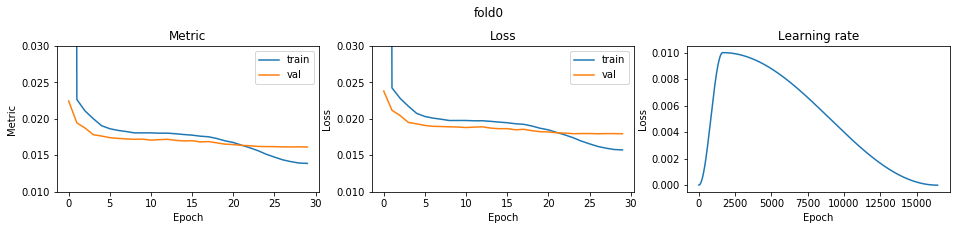

fold 1


epoch1 save best model... 0.022010450025413106
epoch2 save best model... 0.020156565656824818
epoch3 save best model... 0.01835998744162945
epoch4 save best model... 0.0180486373104262
epoch5 save best model... 0.017698774056958567
epoch6 save best model... 0.017598916074962584
epoch7 save best model... 0.017548799772799273
epoch8 save best model... 0.017499878272833506
epoch9 save best model... 0.017490406297648052
epoch10 save best model... 0.017358008078258085
epoch12 save best model... 0.01727541926785655
epoch14 save best model... 0.017179314663311594
epoch17 save best model... 0.017091337226010396
epoch18 save best model... 0.01703723735630336
epoch19 save best model... 0.0169156355987899
epoch20 save best model... 0.016786224736500422
epoch21 save best model... 0.016698734872136498
epoch22 save best model... 0.016590556505397827
epoch23 save best model... 0.016563532847463813
epoch24 save best model... 0.01650939475767031
epoch25 save best model... 0.016403662380128997
epoch27 s

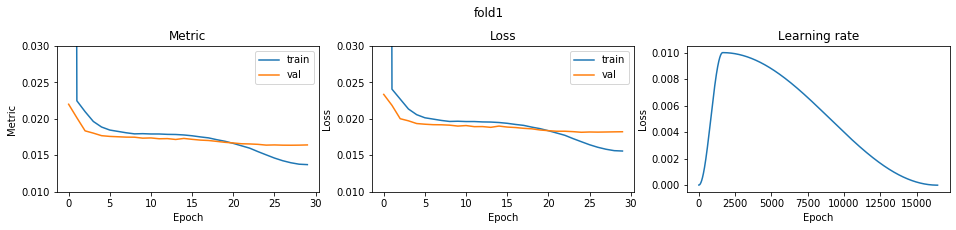

fold 2


epoch1 save best model... 0.021983064026978163
epoch2 save best model... 0.01924462485689255
epoch3 save best model... 0.018525865453293926
epoch4 save best model... 0.017971165063813258
epoch5 save best model... 0.017638839377477802
epoch6 save best model... 0.017409806112606247
epoch7 save best model... 0.01737377586725511
epoch8 save best model... 0.01720063447167999
epoch10 save best model... 0.017156310525070727
epoch13 save best model... 0.017110670552397813
epoch16 save best model... 0.01700512715461491
epoch18 save best model... 0.01693607275929123
epoch19 save best model... 0.016854844477488543
epoch20 save best model... 0.01663669691319026
epoch21 save best model... 0.016514153253922813
epoch22 save best model... 0.016406302334599436
epoch23 save best model... 0.01639866467869161
epoch24 save best model... 0.016311742472094198
epoch25 save best model... 0.016271908966347823
epoch26 save best model... 0.016269244790275823
epoch27 save best model... 0.016263905078075923
epoch28

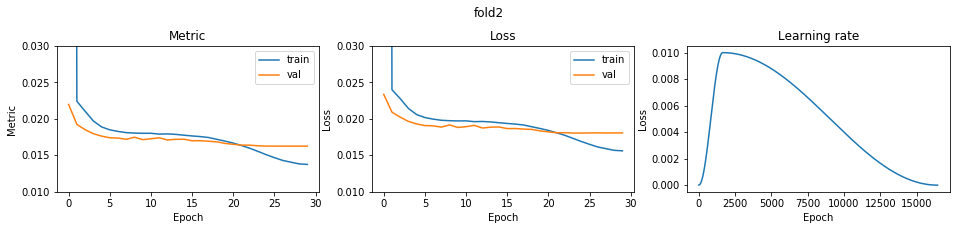

fold 3


epoch1 save best model... 0.022074221302850642
epoch2 save best model... 0.019470390621021152
epoch3 save best model... 0.018826570464955783
epoch4 save best model... 0.018197273462586497
epoch5 save best model... 0.01789792269968973
epoch6 save best model... 0.0176660206461652
epoch7 save best model... 0.017461805341336747
epoch11 save best model... 0.0173617270005048
epoch13 save best model... 0.017313956851585172
epoch15 save best model... 0.01729181556833021
epoch17 save best model... 0.017042325535504856
epoch19 save best model... 0.016918165431886165
epoch20 save best model... 0.01685381861603002
epoch21 save best model... 0.016712017700602225
epoch22 save best model... 0.016662190468018718
epoch23 save best model... 0.01656983066689656
epoch24 save best model... 0.016492627500418515
epoch26 save best model... 0.016452611188970692
epoch27 save best model... 0.016439211220906916
epoch28 save best model... 0.016428412472858922
fold3 score: 0.016428412415022606


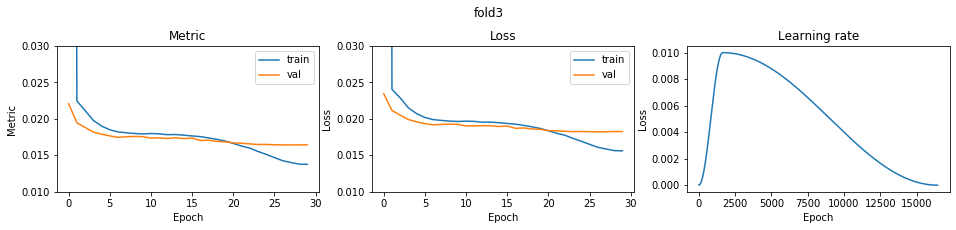

fold 4


epoch1 save best model... 0.022492190941760914
epoch2 save best model... 0.019476526407928022
epoch3 save best model... 0.018387012630022195
epoch4 save best model... 0.01776533075279486
epoch5 save best model... 0.017686170797820516
epoch6 save best model... 0.017310532583411708
epoch9 save best model... 0.017308113141439364
epoch10 save best model... 0.01728553081860507
epoch13 save best model... 0.01721684379897723
epoch15 save best model... 0.01718116472379765
epoch16 save best model... 0.01706342849167645
epoch17 save best model... 0.016987678843098514
epoch18 save best model... 0.016971434424111538
epoch19 save best model... 0.016866680436633984
epoch20 save best model... 0.016763823154830035
epoch21 save best model... 0.016713826668476324
epoch22 save best model... 0.016667793799777238
epoch23 save best model... 0.01649779923608132
epoch24 save best model... 0.016436231292886044
fold4 score: 0.016436231258101543


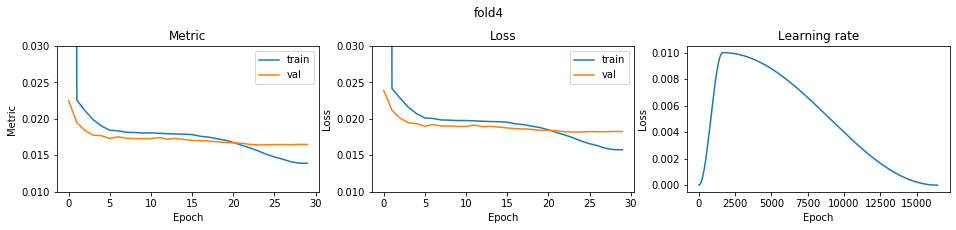

CV score: 0.016330739905402666

optimizer: RAdam
fold 0


epoch1 save best model... 0.03767477125438579
epoch2 save best model... 0.020076675613777784
epoch3 save best model... 0.018716720850599382
epoch4 save best model... 0.01793607881458175
epoch5 save best model... 0.017699256098928917
epoch6 save best model... 0.017536823207126392
epoch7 save best model... 0.017256850509104533
epoch8 save best model... 0.017151826349403158
epoch9 save best model... 0.017112035841462554
epoch10 save best model... 0.016941543292585157
epoch11 save best model... 0.01691680054916472
epoch12 save best model... 0.01674894359989563
epoch13 save best model... 0.016612015877572443
epoch14 save best model... 0.016590080075050813
epoch16 save best model... 0.016508947244520747
epoch17 save best model... 0.016429206857495944
epoch18 save best model... 0.016352245888772477
epoch19 save best model... 0.01625123373561609
epoch21 save best model... 0.016246920815565048
fold0 score: 0.016246920719928202


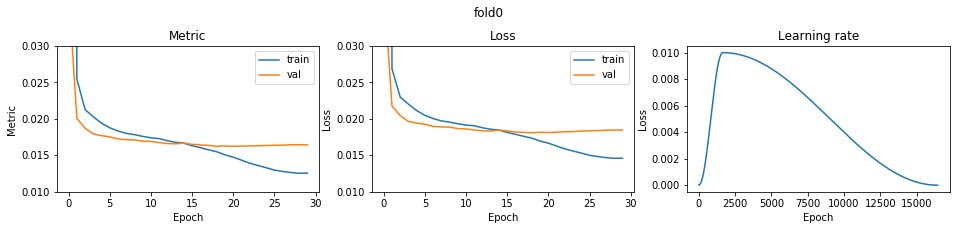

fold 1


epoch1 save best model... 0.03803842346525377
epoch2 save best model... 0.020159084916854943
epoch3 save best model... 0.018896021209886364
epoch4 save best model... 0.01817619836173899
epoch5 save best model... 0.017861572616897213
epoch6 save best model... 0.01773399397294555
epoch7 save best model... 0.017458623185614624
epoch8 save best model... 0.017324832977426163
epoch10 save best model... 0.017114220026648787
epoch12 save best model... 0.017016141321259688
epoch13 save best model... 0.01687775572834464
epoch16 save best model... 0.016822970237164475
epoch17 save best model... 0.016764311003206966
epoch18 save best model... 0.016677833621437484
epoch19 save best model... 0.016629702396950573
epoch20 save best model... 0.01659614541651679
epoch21 save best model... 0.0165908203803395
fold1 score: 0.01659082014759761


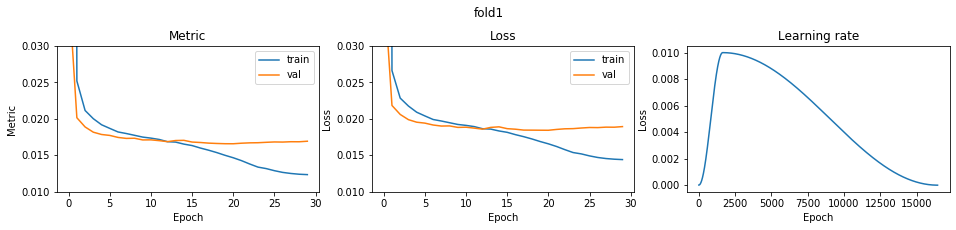

fold 2


epoch1 save best model... 0.03666221929638118
epoch2 save best model... 0.020093187615300847
epoch3 save best model... 0.018916943060447656
epoch4 save best model... 0.01801452971591707
epoch5 save best model... 0.01774541127346295
epoch6 save best model... 0.0174009523007108
epoch7 save best model... 0.017393827036033326
epoch8 save best model... 0.01711738033559259
epoch9 save best model... 0.01710779395690334
epoch10 save best model... 0.017011565743635947
epoch12 save best model... 0.01691127454874306
epoch13 save best model... 0.016756834867152546
epoch14 save best model... 0.016632040916955002
epoch15 save best model... 0.016518258329461365
epoch16 save best model... 0.01647816215743438
epoch17 save best model... 0.016467720273127585
epoch18 save best model... 0.016451198239737556
epoch19 save best model... 0.016393293875935248
epoch20 save best model... 0.016358780391144235
epoch21 save best model... 0.016325615895167248
fold2 score: 0.016325615849300673


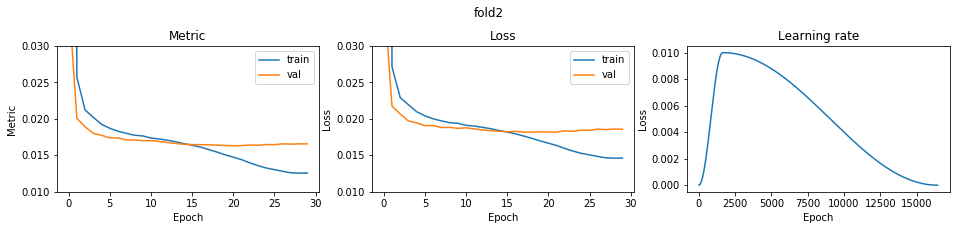

fold 3


epoch1 save best model... 0.03926879894455093
epoch2 save best model... 0.019932709508713394
epoch3 save best model... 0.018851748295128347
epoch4 save best model... 0.018379755908780326
epoch5 save best model... 0.01788342269752726
epoch6 save best model... 0.017665380549644692
epoch7 save best model... 0.01751588392272965
epoch8 save best model... 0.017371904038334083
epoch9 save best model... 0.01720724350057865
epoch10 save best model... 0.017067014496849855
epoch11 save best model... 0.017020740748673744
epoch12 save best model... 0.01699625624678944
epoch13 save best model... 0.01684636469540061
epoch16 save best model... 0.016713461477589498
epoch17 save best model... 0.016645484725289164
epoch18 save best model... 0.01663804984140233
epoch19 save best model... 0.016621433108926227
epoch20 save best model... 0.016581687067713853
epoch21 save best model... 0.01655675670204171
epoch23 save best model... 0.01652608614262185
fold3 score: 0.01652608593753438


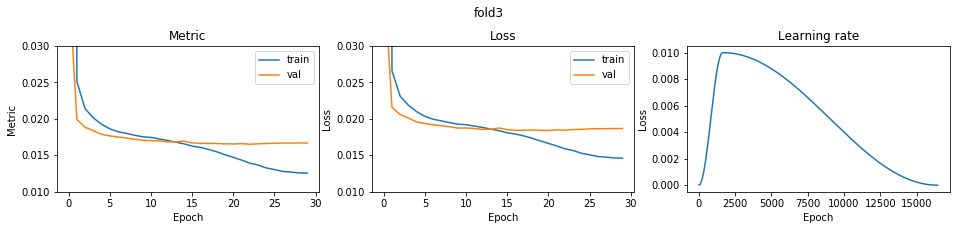

fold 4


epoch1 save best model... 0.039682962916842354
epoch2 save best model... 0.019671961583689297
epoch3 save best model... 0.018624831017760184
epoch4 save best model... 0.018041215703349586
epoch5 save best model... 0.017567377205267718
epoch6 save best model... 0.01745053541789294
epoch7 save best model... 0.01738338427859993
epoch8 save best model... 0.017274706461095593
epoch9 save best model... 0.01715315873299753
epoch11 save best model... 0.017078932208817343
epoch12 save best model... 0.016864782804305027
epoch13 save best model... 0.016817290095319643
epoch14 save best model... 0.016697203807515815
epoch16 save best model... 0.016660768338022987
epoch17 save best model... 0.016598750440009226
epoch18 save best model... 0.016583829079086388
epoch20 save best model... 0.016499912664548817
fold4 score: 0.01649991251387093


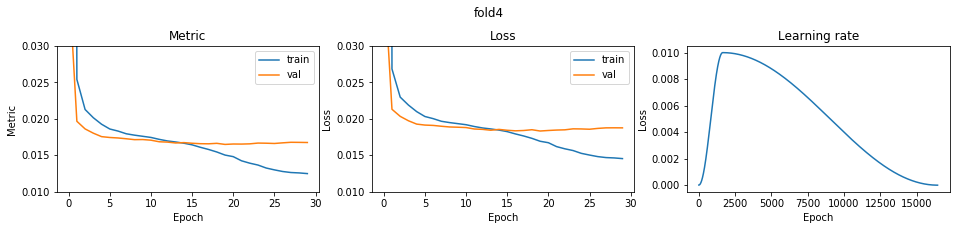

CV score: 0.016437869179539856

optimizer: Ranger
fold 0


epoch1 save best model... 0.2441887222145576
epoch2 save best model... 0.020742708450535434
epoch3 save best model... 0.018780527380135987
epoch4 save best model... 0.017972333687686432
epoch5 save best model... 0.017624163558889086
epoch6 save best model... 0.017391602588915065
epoch7 save best model... 0.01735489842288858
epoch8 save best model... 0.017016678635277074
epoch9 save best model... 0.016910841476367382
epoch10 save best model... 0.016869139215635275
epoch11 save best model... 0.016859004395358382
epoch12 save best model... 0.016631701868663886
epoch13 save best model... 0.01657721099734374
epoch15 save best model... 0.016446089986414735
epoch16 save best model... 0.016383125980072792
epoch17 save best model... 0.016272953732240445
epoch19 save best model... 0.01623429751961337
fold0 score: 0.01623429735254248


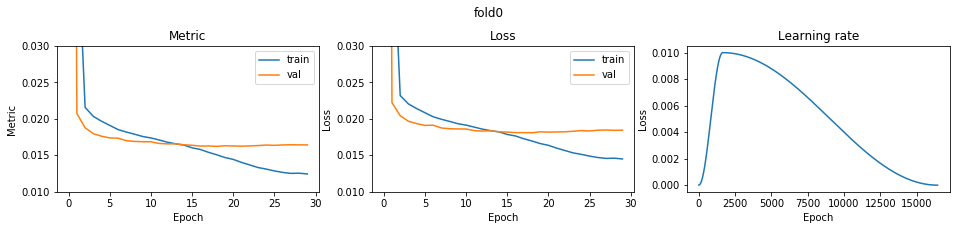

fold 1


epoch1 save best model... 0.23007108080656008
epoch2 save best model... 0.020961262755084076
epoch3 save best model... 0.01924380438737987
epoch4 save best model... 0.01830904829167517
epoch5 save best model... 0.01795249609974773
epoch6 save best model... 0.01769383370750693
epoch7 save best model... 0.01735642064837232
epoch8 save best model... 0.017272013463003538
epoch9 save best model... 0.01711912631333268
epoch10 save best model... 0.016976697669392308
epoch11 save best model... 0.01697483169639347
epoch12 save best model... 0.016862369627337653
epoch13 save best model... 0.016849327992455213
epoch14 save best model... 0.01676992679600035
epoch15 save best model... 0.016610823515662572
epoch16 save best model... 0.016594784327511717
epoch18 save best model... 0.016524460489865275
epoch20 save best model... 0.016515673023191704
fold1 score: 0.016515673069813757


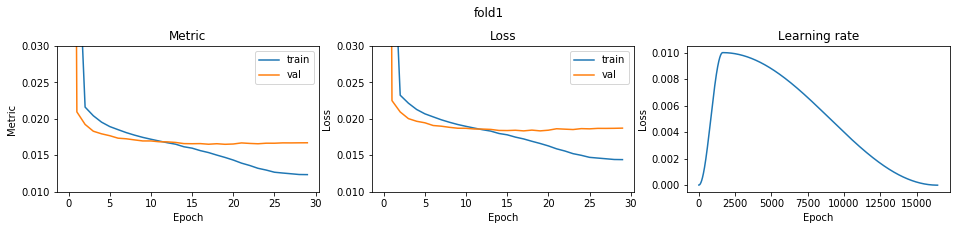

fold 2


epoch1 save best model... 0.23766950000307505
epoch2 save best model... 0.02052294614341379
epoch3 save best model... 0.01891193405497377
epoch4 save best model... 0.018280134523806443
epoch5 save best model... 0.017910729533099155
epoch6 save best model... 0.017591317900638764
epoch7 save best model... 0.0173085141368083
epoch8 save best model... 0.017269260583814224
epoch9 save best model... 0.017103369567372663
epoch10 save best model... 0.016863615242953208
epoch11 save best model... 0.016711490175086902
epoch12 save best model... 0.01663055943461391
epoch14 save best model... 0.016615110895738402
epoch15 save best model... 0.016458391257336606
epoch17 save best model... 0.016446159385682835
epoch18 save best model... 0.016415876847148403
epoch19 save best model... 0.016365158523770938
epoch20 save best model... 0.01636235570370825
epoch21 save best model... 0.01634171430813435
fold2 score: 0.016341714094789267


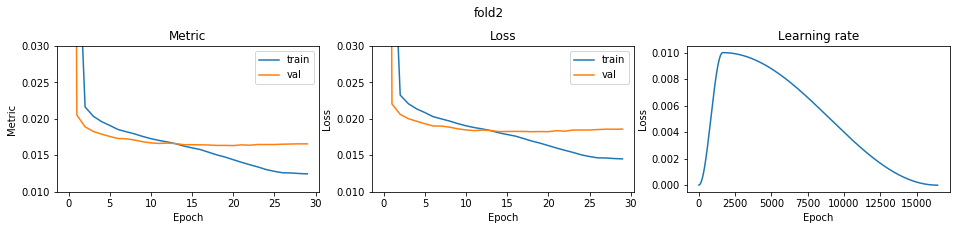

fold 3


epoch1 save best model... 0.241482963431669
epoch2 save best model... 0.020783038501010397
epoch3 save best model... 0.0189159125463023
epoch4 save best model... 0.01821409914438912
epoch5 save best model... 0.017982936274166937
epoch6 save best model... 0.01760993700915765
epoch7 save best model... 0.01745446043551511
epoch8 save best model... 0.01736106558454675
epoch9 save best model... 0.017158744247855115
epoch10 save best model... 0.017044077448733576
epoch12 save best model... 0.016800370651184834
epoch13 save best model... 0.016795924795973954
epoch14 save best model... 0.016674312418390378
epoch16 save best model... 0.016588663351393234
epoch17 save best model... 0.016583674372617232
epoch18 save best model... 0.0165398318307784
epoch19 save best model... 0.016533371109031733
epoch20 save best model... 0.016493045194138155
epoch21 save best model... 0.016455963574315936
fold3 score: 0.01645596348656692


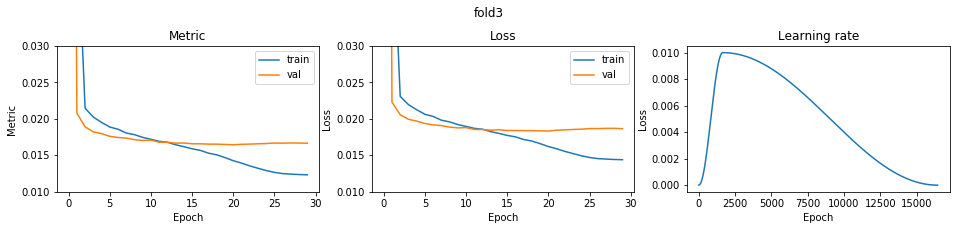

fold 4


epoch1 save best model... 0.2408490686318869
epoch2 save best model... 0.020402345416859504
epoch3 save best model... 0.01871708418944838
epoch4 save best model... 0.01808624859508933
epoch5 save best model... 0.017738324222165522
epoch6 save best model... 0.01754969789143779
epoch7 save best model... 0.01730298185360391
epoch8 save best model... 0.017244187380549985
epoch9 save best model... 0.01697175060112479
epoch12 save best model... 0.01679176951807357
epoch13 save best model... 0.016700476553961466
epoch15 save best model... 0.016556573259922124
epoch18 save best model... 0.016501434074379588
epoch20 save best model... 0.01649635489690616
epoch21 save best model... 0.016487764422877232
fold4 score: 0.016487764297972864


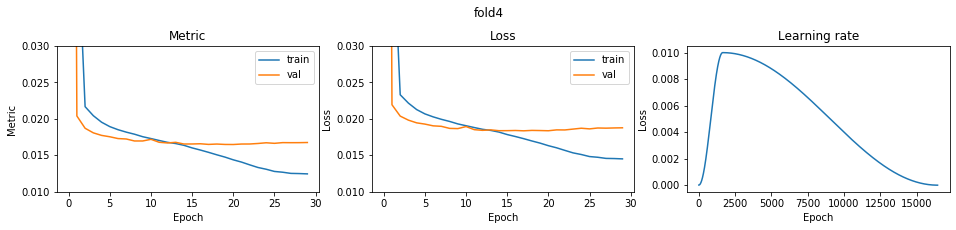

CV score: 0.01640708049103489

optimizer: RangerQH
fold 0


epoch1 save best model... 0.032753822691144595
epoch2 save best model... 0.01975751472021833
epoch3 save best model... 0.018491691025928646
epoch4 save best model... 0.01805414895618288
epoch5 save best model... 0.017849964194491946
epoch6 save best model... 0.01739128728509628
epoch7 save best model... 0.017236488612882097
epoch8 save best model... 0.017124001343219047
epoch9 save best model... 0.01687838595555692
epoch11 save best model... 0.016851550453514337
epoch12 save best model... 0.01672376741513033
epoch13 save best model... 0.016554767447513167
epoch15 save best model... 0.016480406850644287
epoch18 save best model... 0.016284670880178927
epoch21 save best model... 0.01622529415782872
fold0 score: 0.016225294161312576


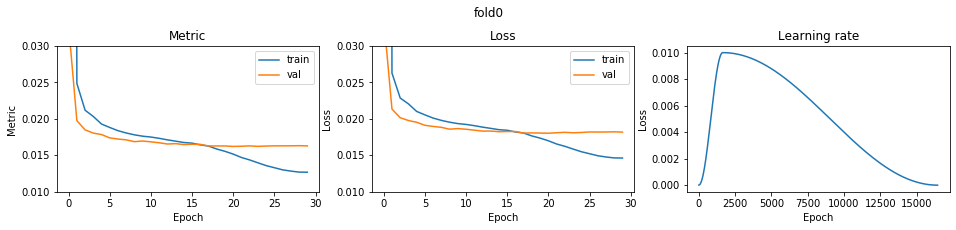

fold 1


epoch1 save best model... 0.03161110194248446
epoch2 save best model... 0.020467553010193845
epoch3 save best model... 0.01874755742569452
epoch4 save best model... 0.018105243092267437
epoch5 save best model... 0.017906029021384832
epoch6 save best model... 0.01749658146327776
epoch7 save best model... 0.01735864789792782
epoch8 save best model... 0.017313711853614293
epoch9 save best model... 0.01709217921609819
epoch10 save best model... 0.01707704041401885
epoch11 save best model... 0.017057362559390898
epoch12 save best model... 0.016942409710442117
epoch14 save best model... 0.016841748467499914
epoch16 save best model... 0.01668881598921986
epoch17 save best model... 0.0166636536843815
epoch19 save best model... 0.01661514757995957
epoch20 save best model... 0.01653195190563625
epoch22 save best model... 0.016507969168688543
fold1 score: 0.016507969027673958


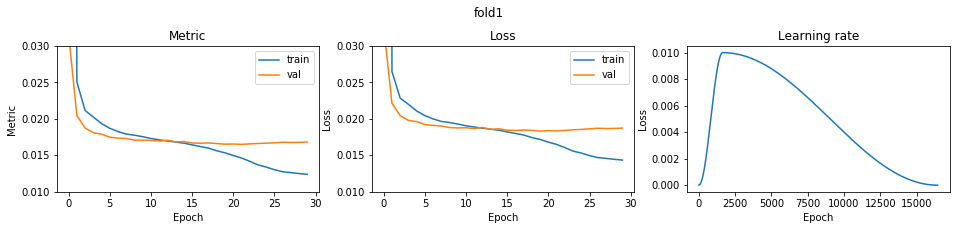

fold 2


epoch1 save best model... 0.03324401388647182
epoch2 save best model... 0.020265995003461268
epoch3 save best model... 0.01870898702125644
epoch4 save best model... 0.018070584271713416
epoch5 save best model... 0.0176694772818853
epoch6 save best model... 0.017292576043096943
epoch7 save best model... 0.017244728681868833
epoch8 save best model... 0.017225431900715047
epoch9 save best model... 0.016900598569748734
epoch12 save best model... 0.016888700458727222
epoch13 save best model... 0.016751930667403606
epoch15 save best model... 0.016610611468854012
epoch16 save best model... 0.016601252487350716
epoch17 save best model... 0.01651948227257039
epoch18 save best model... 0.01647118102516372
epoch19 save best model... 0.01635736339456279
epoch20 save best model... 0.016351097147961863
epoch21 save best model... 0.01633983475955466
epoch22 save best model... 0.016336908350079254
epoch23 save best model... 0.01631291992652556
fold2 score: 0.016312919793128045


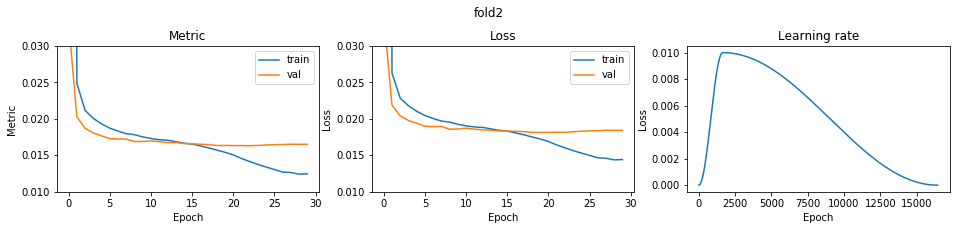

fold 3


epoch1 save best model... 0.03434870786761233
epoch2 save best model... 0.02042095213958777
epoch3 save best model... 0.018931410059010386
epoch4 save best model... 0.018202572205615206
epoch5 save best model... 0.018018018094088737
epoch6 save best model... 0.017606451269027042
epoch7 save best model... 0.01758524489701473
epoch8 save best model... 0.017468535680756618
epoch9 save best model... 0.01715425621327819
epoch11 save best model... 0.017061780244621166
epoch12 save best model... 0.016905867122113706
epoch14 save best model... 0.01688313526154447
epoch15 save best model... 0.016814464127436993
epoch16 save best model... 0.01664072651042686
epoch18 save best model... 0.01657701010109352
epoch19 save best model... 0.016550750504322094
epoch20 save best model... 0.016545513006253912
epoch21 save best model... 0.016462063019276343
epoch22 save best model... 0.016461768830386
fold3 score: 0.01646176874435775


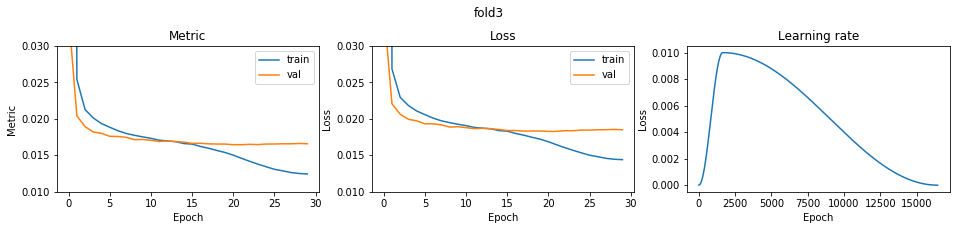

fold 4


epoch1 save best model... 0.03185309500333796
epoch2 save best model... 0.02080768441743215
epoch3 save best model... 0.01845979861584163
epoch4 save best model... 0.01782467556875496
epoch5 save best model... 0.01761616389341398
epoch6 save best model... 0.017355220604068463
epoch7 save best model... 0.017192381175324015
epoch8 save best model... 0.01718813995607961
epoch9 save best model... 0.017020591776521033
epoch12 save best model... 0.016898528184393816
epoch13 save best model... 0.016812458494784212
epoch15 save best model... 0.016640454223527994
epoch18 save best model... 0.01658810484000314
epoch20 save best model... 0.016531504445830212
epoch21 save best model... 0.01652437869781853
fold4 score: 0.016524378611786593


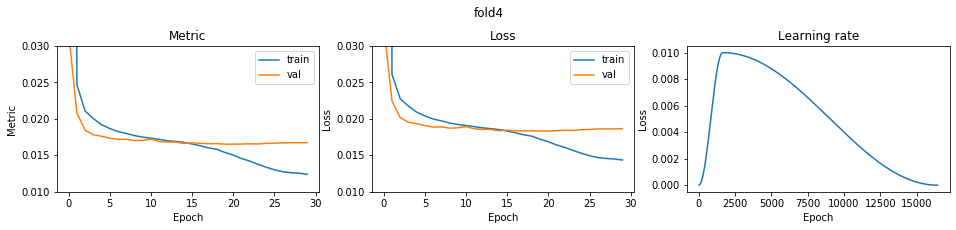

CV score: 0.016406465705127382

optimizer: RangerVA
fold 0


epoch1 save best model... 0.6925400557985066
epoch2 save best model... 0.36099114624405776
epoch3 save best model... 0.032186577078761165
epoch4 save best model... 0.023151344884874338
epoch5 save best model... 0.021379368805702022
epoch6 save best model... 0.02079663337855377
epoch7 save best model... 0.020303310841695323
epoch8 save best model... 0.01990783944267754
epoch9 save best model... 0.019734446093406112
epoch10 save best model... 0.01959675715765269
epoch11 save best model... 0.019349311580690545
epoch12 save best model... 0.01913196893497996
epoch13 save best model... 0.019018812830600217
epoch14 save best model... 0.01890004282320822
epoch15 save best model... 0.018802197461688982
epoch16 save best model... 0.01868791969446359
epoch17 save best model... 0.01863716909734019
epoch19 save best model... 0.01854844916196103
epoch20 save best model... 0.018466488434031505
epoch21 save best model... 0.01842278367786717
epoch23 save best model... 0.01839102004529539
epoch25 save b

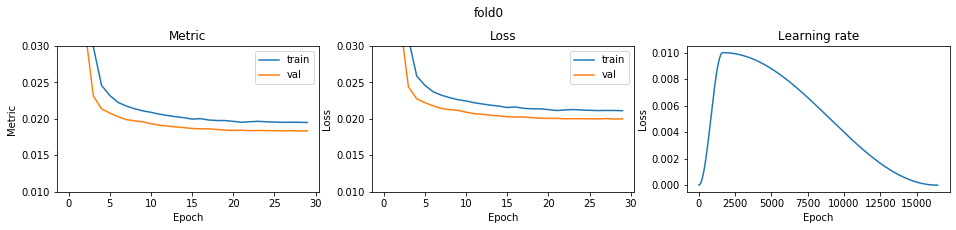

fold 1


epoch1 save best model... 0.6906125059456998
epoch2 save best model... 0.36032435165556503
epoch3 save best model... 0.032025886297660525
epoch4 save best model... 0.02306164962516053
epoch5 save best model... 0.021465586352814137
epoch6 save best model... 0.020939082271398457
epoch7 save best model... 0.02045535544809026
epoch8 save best model... 0.020179303242863378
epoch9 save best model... 0.01986446466121214
epoch10 save best model... 0.019664804015531848
epoch11 save best model... 0.019438280393177458
epoch12 save best model... 0.019198853904065224
epoch13 save best model... 0.019095014306292443
epoch14 save best model... 0.018937354662096374
epoch15 save best model... 0.01890455360281818
epoch16 save best model... 0.018754973652392565
epoch17 save best model... 0.018708861744683596
epoch18 save best model... 0.018616103441351554
epoch19 save best model... 0.01858506121605424
epoch20 save best model... 0.01855218574985281
epoch21 save best model... 0.018508332769822954
epoch23 sa

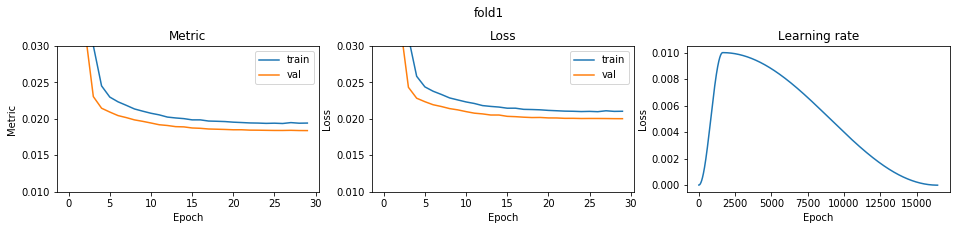

fold 2


epoch1 save best model... 0.6912818942724043
epoch2 save best model... 0.3747653138613098
epoch3 save best model... 0.032340396047113806
epoch4 save best model... 0.023129174139076496
epoch5 save best model... 0.021514435808644747
epoch6 save best model... 0.02079061225165292
epoch7 save best model... 0.020422664385880553
epoch8 save best model... 0.020160778519636165
epoch9 save best model... 0.019855599332661095
epoch10 save best model... 0.019706902612577026
epoch11 save best model... 0.019492309470061534
epoch12 save best model... 0.01934600755611363
epoch13 save best model... 0.019198688094907983
epoch14 save best model... 0.019011049088974236
epoch15 save best model... 0.01887793220557556
epoch16 save best model... 0.01877725566572903
epoch17 save best model... 0.018770617164890407
epoch18 save best model... 0.018680078575018803
epoch19 save best model... 0.0186251952709903
epoch20 save best model... 0.018574144953925915
epoch21 save best model... 0.018522679333834585
epoch22 sav

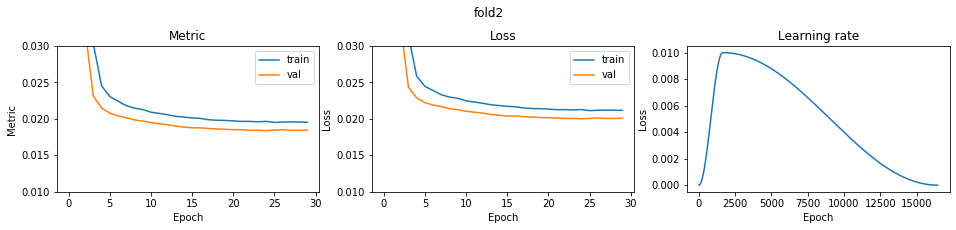

fold 3


epoch1 save best model... 0.6927524973971425
epoch2 save best model... 0.36803772172515103
epoch3 save best model... 0.032948737056896195
epoch4 save best model... 0.023287118401946947
epoch5 save best model... 0.02172705973657633
epoch6 save best model... 0.021011561400984712
epoch7 save best model... 0.020564774690293504
epoch8 save best model... 0.02030513001677998
epoch9 save best model... 0.02001665457955865
epoch10 save best model... 0.019756389485252067
epoch11 save best model... 0.019573818921516724
epoch12 save best model... 0.019423847742684203
epoch13 save best model... 0.019319126851737905
epoch14 save best model... 0.019223195420056242
epoch15 save best model... 0.019047931384439484
epoch16 save best model... 0.018955101447863026
epoch17 save best model... 0.018898371470018643
epoch18 save best model... 0.018825214286599997
epoch19 save best model... 0.018768496397280204
epoch20 save best model... 0.01874038132972557
epoch21 save best model... 0.018723147436721856
epoch23 

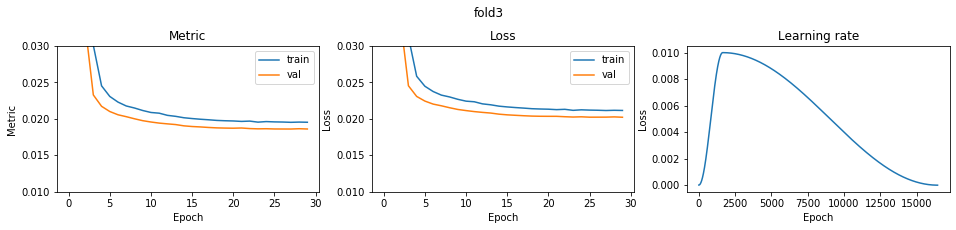

fold 4


epoch1 save best model... 0.6917155422219383
epoch2 save best model... 0.36674582535965294
epoch3 save best model... 0.032602371488419914
epoch4 save best model... 0.02293951078265023
epoch5 save best model... 0.02124478878338815
epoch6 save best model... 0.020631943709282778
epoch7 save best model... 0.020235603934913398
epoch8 save best model... 0.019963861759200455
epoch9 save best model... 0.01972272619520206
epoch10 save best model... 0.01953271364364646
epoch11 save best model... 0.01929949102223191
epoch12 save best model... 0.019149999403668426
epoch13 save best model... 0.019041744837694396
epoch14 save best model... 0.01885081856662157
epoch15 save best model... 0.018846866742183787
epoch16 save best model... 0.018755700831261202
epoch17 save best model... 0.01862000730694834
epoch18 save best model... 0.018592680728483038
epoch19 save best model... 0.018567081771638235
epoch20 save best model... 0.018501374116570504
epoch22 save best model... 0.018428906263753875
epoch26 sav

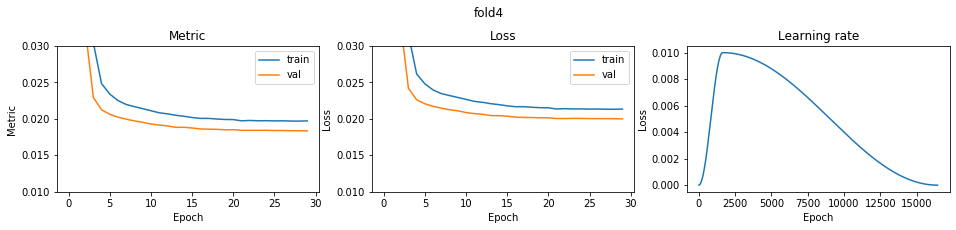

CV score: 0.018421628408719797

optimizer: SWATS
fold 0


epoch1 save best model... 0.06295668096843776
epoch2 save best model... 0.020031358884617788
epoch3 save best model... 0.018612235416244537
epoch4 save best model... 0.017970057504764995
epoch5 save best model... 0.01757057778673047
epoch6 save best model... 0.017232356007488823
epoch7 save best model... 0.01708648535836666
epoch8 save best model... 0.016861080598077633
epoch9 save best model... 0.016844729065962967
epoch10 save best model... 0.01669856958549495
epoch11 save best model... 0.016616598614289983
epoch12 save best model... 0.016489591131279572
epoch13 save best model... 0.016384003531179286
epoch14 save best model... 0.016306585801133127
epoch15 save best model... 0.016278733494680942
epoch17 save best model... 0.016199775461472384
epoch18 save best model... 0.016170970105262715
epoch19 save best model... 0.016162741992088003
epoch20 save best model... 0.01614616854256337
epoch21 save best model... 0.016094577446970283
epoch30 save best model... 0.016080114902644195
fold0 

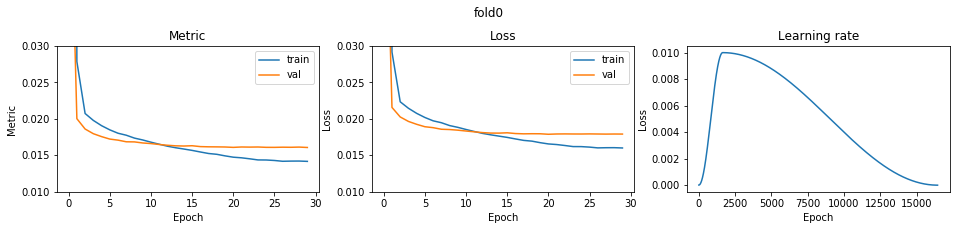

fold 1


epoch1 save best model... 0.06077592194379123
epoch2 save best model... 0.020482744878562418
epoch3 save best model... 0.018721458886398437
epoch4 save best model... 0.017987344529005276
epoch5 save best model... 0.017628794351809522
epoch7 save best model... 0.017267283434156514
epoch8 save best model... 0.017121884359038754
epoch9 save best model... 0.016968069872022096
epoch10 save best model... 0.016820883198445383
epoch11 save best model... 0.016723093728024125
epoch13 save best model... 0.01659105055409321
epoch14 save best model... 0.016549766561074583
epoch15 save best model... 0.016488641674897074
epoch17 save best model... 0.016464384331260327
epoch19 save best model... 0.016454866315976827
epoch20 save best model... 0.016441921760173422
epoch21 save best model... 0.01642587459222837
epoch22 save best model... 0.016408439436628244
epoch23 save best model... 0.016401650588836383
epoch26 save best model... 0.016395209548966463
fold1 score: 0.01639520944230888


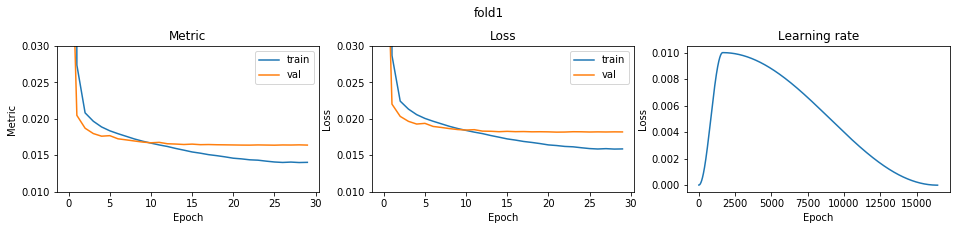

fold 2


epoch1 save best model... 0.06040057164355247
epoch2 save best model... 0.020481577744432884
epoch3 save best model... 0.018597084253739526
epoch4 save best model... 0.017937366336101986
epoch5 save best model... 0.01765220944287362
epoch6 save best model... 0.0172412345431173
epoch7 save best model... 0.017083106423295503
epoch8 save best model... 0.01691363328772027
epoch9 save best model... 0.016807599538946973
epoch10 save best model... 0.016660772915653703
epoch11 save best model... 0.01652875570353315
epoch12 save best model... 0.016454573284421268
epoch13 save best model... 0.016433127209167325
epoch21 save best model... 0.01642733848872082
epoch26 save best model... 0.01642077062516644
fold2 score: 0.016420770638081124


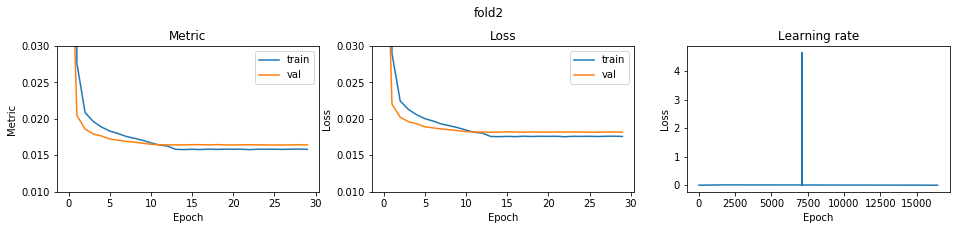

fold 3


epoch1 save best model... 0.05866293643594874
epoch2 save best model... 0.020360625429176524
epoch3 save best model... 0.01898739239994377
epoch4 save best model... 0.018252682657000145
epoch5 save best model... 0.017792672088586117
epoch6 save best model... 0.0175783536581488
epoch7 save best model... 0.017371624195205732
epoch8 save best model... 0.01716935982533088
epoch9 save best model... 0.017086957476116667
epoch10 save best model... 0.01689721041471445
epoch11 save best model... 0.01682103030969111
epoch12 save best model... 0.016796939860359003
epoch13 save best model... 0.01668596344200177
epoch14 save best model... 0.016631997135682097
epoch15 save best model... 0.01657479748274104
epoch16 save best model... 0.016529289041147283
epoch17 save best model... 0.01651238748095166
epoch18 save best model... 0.01644304154360145
epoch19 save best model... 0.016436103432691723
epoch20 save best model... 0.016420427700059154
epoch23 save best model... 0.016420427046648325
epoch24 save

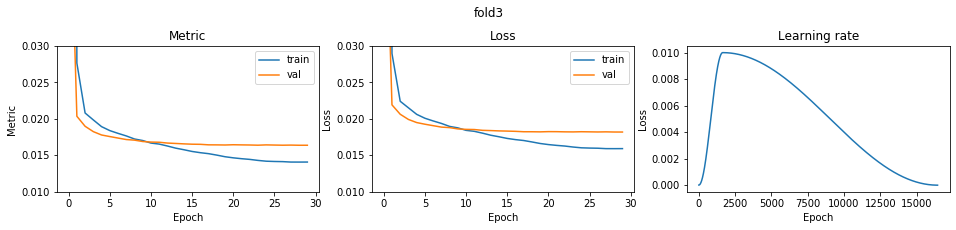

fold 4


epoch1 save best model... 0.062238555018003
epoch2 save best model... 0.019968585521491895
epoch3 save best model... 0.01847283931784247
epoch4 save best model... 0.018141714725770683
epoch5 save best model... 0.01754422770783407
epoch6 save best model... 0.017291658042435765
epoch7 save best model... 0.01708084236881388
epoch8 save best model... 0.016972606646529227
epoch9 save best model... 0.016887267223709944
epoch10 save best model... 0.01681983552380955
epoch11 save best model... 0.016740037329444037
epoch12 save best model... 0.01660912839657625
epoch13 save best model... 0.01654843688690038
epoch15 save best model... 0.016546743533283403
epoch16 save best model... 0.016463752821138752
epoch18 save best model... 0.01643051601827552
epoch20 save best model... 0.016415882998216124
epoch21 save best model... 0.01636421225481329
fold4 score: 0.016364212192744098


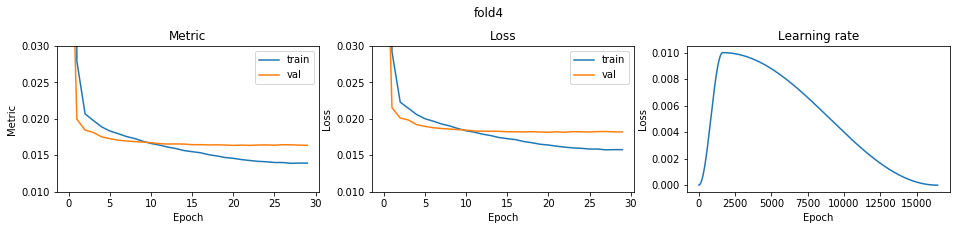

CV score: 0.016328951011932696

optimizer: Yogi
fold 0


epoch1 save best model... 0.08292876828232768
epoch2 save best model... 0.020523203903457028
epoch3 save best model... 0.01879519962436246
epoch4 save best model... 0.018050748058902374
epoch5 save best model... 0.017631345667403216
epoch6 save best model... 0.01743556041363839
epoch7 save best model... 0.0171891894513966
epoch8 save best model... 0.017077282385090216
epoch9 save best model... 0.016910424846349654
epoch10 save best model... 0.01677921853518296
epoch11 save best model... 0.01673891172407021
epoch12 save best model... 0.01664451721436206
epoch13 save best model... 0.016586041657555346
epoch14 save best model... 0.01653043277188287
epoch15 save best model... 0.016432896331970946
epoch16 save best model... 0.01638344719174375
epoch17 save best model... 0.016323073927932558
epoch18 save best model... 0.01629661373318871
epoch19 save best model... 0.016259594313409984
epoch20 save best model... 0.016235415962501377
epoch22 save best model... 0.016198971174266996
epoch23 save

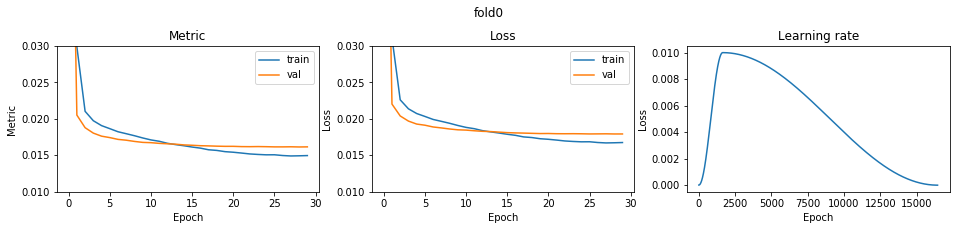

fold 1


epoch1 save best model... 0.072869276669064
epoch2 save best model... 0.020489622269476784
epoch3 save best model... 0.018968790296807217
epoch4 save best model... 0.018397009367703387
epoch5 save best model... 0.01790320606361994
epoch6 save best model... 0.017749048301796893
epoch7 save best model... 0.01759284238105457
epoch8 save best model... 0.017275063309960252
epoch9 save best model... 0.01719538491634335
epoch10 save best model... 0.01707348077521696
epoch11 save best model... 0.017011095606525656
epoch12 save best model... 0.01688472194587364
epoch13 save best model... 0.016808960370347667
epoch14 save best model... 0.016798583034822352
epoch15 save best model... 0.016682172776809938
epoch17 save best model... 0.016639052837829054
epoch18 save best model... 0.01660540772020124
epoch19 save best model... 0.01656290841106165
epoch20 save best model... 0.016511745375531645
epoch22 save best model... 0.016494314316350362
epoch25 save best model... 0.01649370799755678
epoch28 save

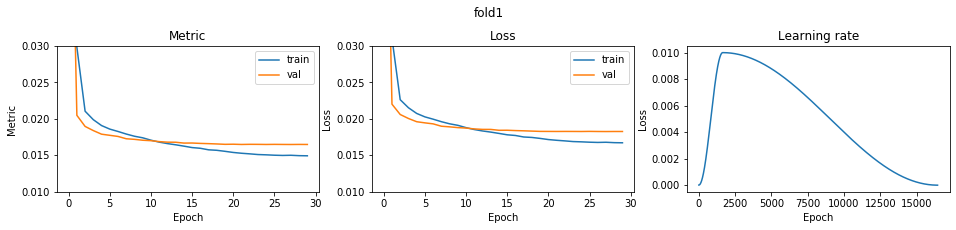

fold 2


epoch1 save best model... 0.07900224384332089
epoch2 save best model... 0.02035406743269435
epoch3 save best model... 0.01886815437866686
epoch4 save best model... 0.01800556602896509
epoch5 save best model... 0.01777131723099545
epoch6 save best model... 0.017372093810836747
epoch7 save best model... 0.017195574590827236
epoch8 save best model... 0.0171196643334399
epoch9 save best model... 0.016976722225200535
epoch10 save best model... 0.016788676591183906
epoch11 save best model... 0.01669707169022524
epoch12 save best model... 0.016663559881164372
epoch13 save best model... 0.016609691434401292
epoch14 save best model... 0.016523401568883316
epoch15 save best model... 0.016439087374874713
epoch16 save best model... 0.016394940262210955
epoch17 save best model... 0.016379836323722183
epoch18 save best model... 0.016338243386030238
epoch19 save best model... 0.016302643439718274
epoch20 save best model... 0.01629329547112034
epoch21 save best model... 0.01626084853934689
epoch22 sav

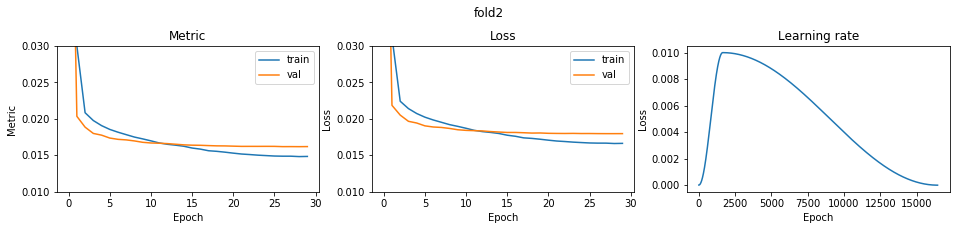

fold 3


epoch1 save best model... 0.0811530204324353
epoch2 save best model... 0.020509368622493092
epoch3 save best model... 0.019105511915218722
epoch4 save best model... 0.01836253187676429
epoch5 save best model... 0.017902912925886402
epoch6 save best model... 0.017681859318667635
epoch7 save best model... 0.01753183891423946
epoch8 save best model... 0.017349165259247352
epoch9 save best model... 0.01717865778672125
epoch10 save best model... 0.01706366981284222
epoch11 save best model... 0.017012091310682084
epoch12 save best model... 0.016949091021794666
epoch13 save best model... 0.016858196088827822
epoch14 save best model... 0.0167967257872733
epoch15 save best model... 0.016717001163996843
epoch16 save best model... 0.01661795418930149
epoch17 save best model... 0.016616130935490674
epoch18 save best model... 0.016615105845492358
epoch19 save best model... 0.016577448232146085
epoch20 save best model... 0.01647971329832946
epoch24 save best model... 0.01642928572842567
epoch30 save

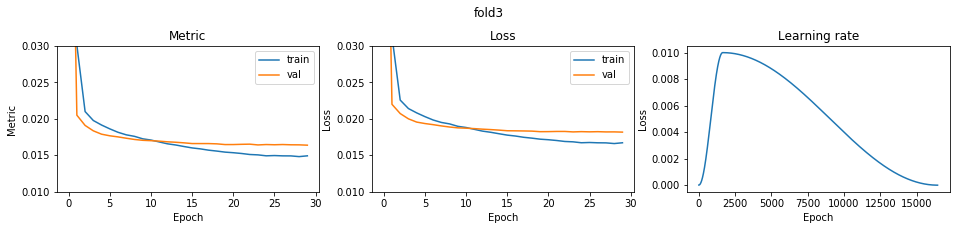

fold 4


epoch1 save best model... 0.07168881091414389
epoch2 save best model... 0.02042390334341412
epoch3 save best model... 0.018705607003666
epoch4 save best model... 0.018058590740304872
epoch5 save best model... 0.01771590222046628
epoch6 save best model... 0.017505716223583677
epoch7 save best model... 0.01731028139107523
epoch8 save best model... 0.017121119778136594
epoch9 save best model... 0.01706489633285103
epoch10 save best model... 0.01694506112324893
epoch11 save best model... 0.01688325391543482
epoch12 save best model... 0.016817357602841084
epoch13 save best model... 0.01671725030275643
epoch14 save best model... 0.016707195504939775
epoch15 save best model... 0.01660594798174765
epoch16 save best model... 0.016565383733557815
epoch17 save best model... 0.016535564616814696
epoch18 save best model... 0.016513032657953494
epoch19 save best model... 0.016480657314045827
epoch20 save best model... 0.016450826096897922
epoch21 save best model... 0.016448689059933526
epoch22 save 

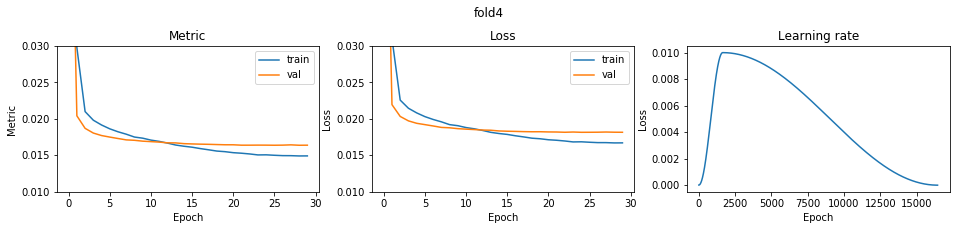

CV score: 0.016322339546969072

optimizer: Adam
fold 0


epoch1 save best model... 0.02334500670110582
epoch2 save best model... 0.01884810070853027
epoch3 save best model... 0.018375445014727144
epoch4 save best model... 0.017843013170232534
epoch5 save best model... 0.01749656478405542
epoch6 save best model... 0.017292796997756512
epoch7 save best model... 0.017213604625543593
epoch8 save best model... 0.017193454153547255
epoch9 save best model... 0.017057539624478115
epoch13 save best model... 0.016960680085087963
epoch17 save best model... 0.01682166710139543
epoch19 save best model... 0.016696965019802026
epoch20 save best model... 0.01666957783196673
epoch21 save best model... 0.01652597402877987
epoch22 save best model... 0.01640757287349679
epoch23 save best model... 0.016308504488140956
epoch24 save best model... 0.01624930022381976
epoch25 save best model... 0.016217964791728857
epoch26 save best model... 0.01618542116695425
fold0 score: 0.01618542107017598


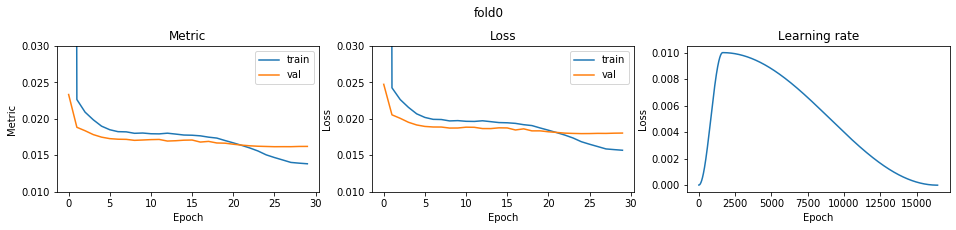

fold 1


epoch1 save best model... 0.021800836610170043
epoch2 save best model... 0.019462597510790356
epoch3 save best model... 0.018889313225890516
epoch4 save best model... 0.018162917374620734
epoch5 save best model... 0.017773941850154323
epoch6 save best model... 0.017537039068673297
epoch8 save best model... 0.017535419352513886
epoch9 save best model... 0.01742372498608825
epoch10 save best model... 0.017416200437811138
epoch11 save best model... 0.017237344265703895
epoch15 save best model... 0.017227287874462652
epoch16 save best model... 0.017181463175474254
epoch18 save best model... 0.017042198017032467
epoch19 save best model... 0.016931630895314128
epoch20 save best model... 0.01686562957464087
epoch21 save best model... 0.016823024181939795
epoch22 save best model... 0.016636985726102824
epoch23 save best model... 0.016604856117086356
epoch24 save best model... 0.016591184162066883
epoch25 save best model... 0.01652694754128502
epoch26 save best model... 0.016518163732211637
epo

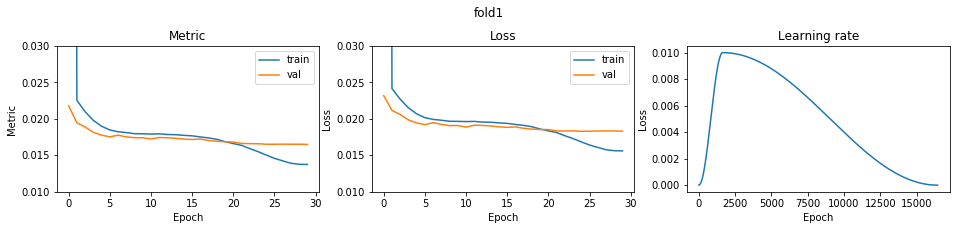

fold 2


epoch1 save best model... 0.022286069166703767
epoch2 save best model... 0.019701890395748423
epoch3 save best model... 0.018498124009837292
epoch4 save best model... 0.01773180562928981
epoch5 save best model... 0.01767095043897921
epoch6 save best model... 0.017518783354438718
epoch7 save best model... 0.0172071614968774
epoch11 save best model... 0.01717435156170675
epoch12 save best model... 0.017094140017002407
epoch14 save best model... 0.017076969638383656
epoch16 save best model... 0.01707205195705612
epoch17 save best model... 0.016921134718020498
epoch18 save best model... 0.01680180939212764
epoch19 save best model... 0.01673434453739049
epoch21 save best model... 0.016551668565583665
epoch22 save best model... 0.01648355018085229
epoch23 save best model... 0.016427006119873657
epoch24 save best model... 0.01627011513339615
epoch26 save best model... 0.01623798318875253
epoch29 save best model... 0.016225329946576328
fold2 score: 0.01622532998478411


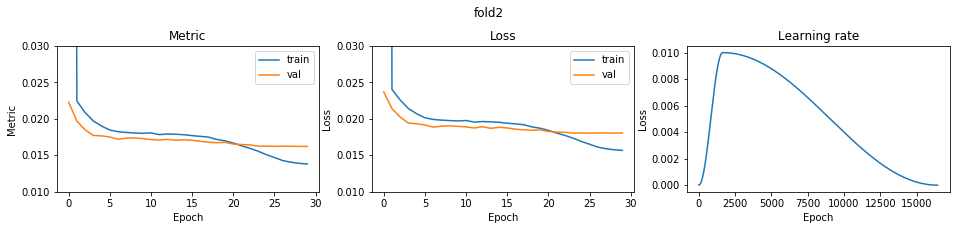

fold 3


epoch1 save best model... 0.022012028827889905
epoch2 save best model... 0.01934371223516236
epoch3 save best model... 0.018651183482454686
epoch4 save best model... 0.017978290308495997
epoch5 save best model... 0.01781771693141083
epoch6 save best model... 0.017613859701655583
epoch7 save best model... 0.017531202370322102
epoch9 save best model... 0.017428231459526784
epoch10 save best model... 0.017333726601883055
epoch11 save best model... 0.01731936976967002
epoch12 save best model... 0.01729462043189174
epoch14 save best model... 0.017255022777732384
epoch16 save best model... 0.017167655520718163
epoch17 save best model... 0.017155281044882224
epoch18 save best model... 0.01709959750108268
epoch19 save best model... 0.016946209268750526
epoch20 save best model... 0.016919381916098687
epoch21 save best model... 0.01672396521616498
epoch22 save best model... 0.01658289952750969
epoch23 save best model... 0.016454190535127165
epoch24 save best model... 0.01639471058956515
epoch25 

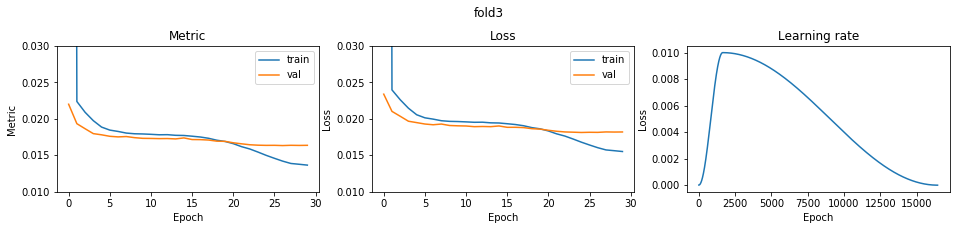

fold 4


epoch1 save best model... 0.02195087646076918
epoch2 save best model... 0.019159636459820363
epoch3 save best model... 0.018385695696623832
epoch4 save best model... 0.018037766197819372
epoch5 save best model... 0.017566052982095706
epoch6 save best model... 0.017391883138490837
epoch7 save best model... 0.017388922874317217
epoch8 save best model... 0.017383721311298752
epoch9 save best model... 0.017382901899754187
epoch10 save best model... 0.01722763506462267
epoch11 save best model... 0.017197982449262725
epoch15 save best model... 0.01719371181592379
epoch16 save best model... 0.017088388479770858
epoch17 save best model... 0.01701993683442168
epoch18 save best model... 0.016978645521578864
epoch19 save best model... 0.016782355409090094
epoch20 save best model... 0.01677297508993222
epoch21 save best model... 0.016670221491273417
epoch22 save best model... 0.01660751892860495
epoch23 save best model... 0.016533481299554703
epoch24 save best model... 0.01647574206801441
epoch25 

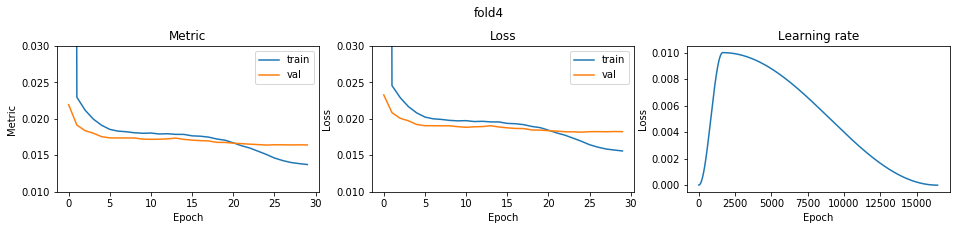

CV score: 0.016332079810596336

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.031904087254696935
epoch2 save best model... 0.020010092498942495
epoch3 save best model... 0.01833413809215425
epoch4 save best model... 0.017810509779866028
epoch5 save best model... 0.01770680143258159
epoch6 save best model... 0.017254235879740846
epoch7 save best model... 0.017142578092210658
epoch8 save best model... 0.016974555102764608
epoch9 save best model... 0.016842136849439224
epoch10 save best model... 0.01678629609881338
epoch12 save best model... 0.01666991872572953
epoch13 save best model... 0.016592184414319134
epoch15 save best model... 0.01650106289460067
epoch16 save best model... 0.0164804602542506
epoch17 save best model... 0.016448962155110065
epoch18 save best model... 0.016426242529446414
epoch19 save best model... 0.016363983407854218
epoch20 save best model... 0.01622119604149549
epoch21 save best model... 0.016215571461156316
epoch23 save best model... 0.016212052341491187
fold0 score: 0.016212052137437257


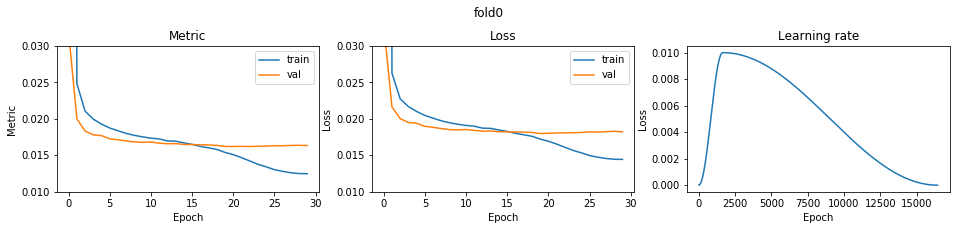

fold 1


epoch1 save best model... 0.03259485957799889
epoch2 save best model... 0.02015483616979648
epoch3 save best model... 0.018694084574374856
epoch4 save best model... 0.01833347052651485
epoch5 save best model... 0.01787720986286093
epoch6 save best model... 0.017462754200683092
epoch7 save best model... 0.017319063682980813
epoch9 save best model... 0.017132927045501102
epoch11 save best model... 0.017059660253345654
epoch12 save best model... 0.016995629769325338
epoch13 save best model... 0.016936850767794002
epoch15 save best model... 0.016827872401966162
epoch16 save best model... 0.016722864751048568
epoch18 save best model... 0.016605780403708834
epoch19 save best model... 0.016554622344569128
epoch20 save best model... 0.016532459150720536
fold1 score: 0.016532459033027663


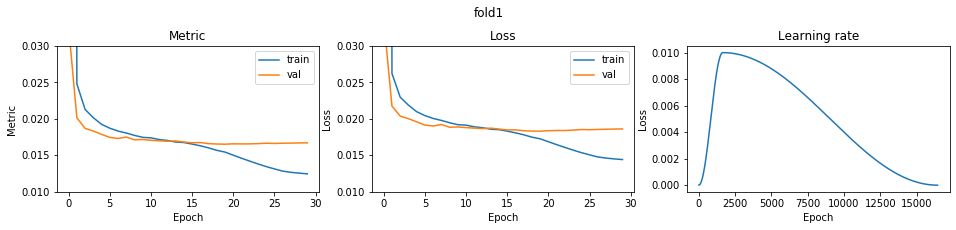

fold 2


epoch1 save best model... 0.03313828399585249
epoch2 save best model... 0.020296128728573618
epoch3 save best model... 0.018781226575434018
epoch4 save best model... 0.018015805149345226
epoch5 save best model... 0.017898813694482936
epoch6 save best model... 0.017407863317484
epoch7 save best model... 0.017168072834661867
epoch9 save best model... 0.016967653771779632
epoch10 save best model... 0.016948538677676525
epoch11 save best model... 0.01687656086142771
epoch12 save best model... 0.016711435076396757
epoch15 save best model... 0.016704821002564173
epoch16 save best model... 0.016553011731562702
epoch18 save best model... 0.016440465585446408
epoch19 save best model... 0.016408478078345595
epoch20 save best model... 0.016386422639940588
epoch21 save best model... 0.016271123660681227
epoch23 save best model... 0.016240848629171186
fold2 score: 0.0162408485615314


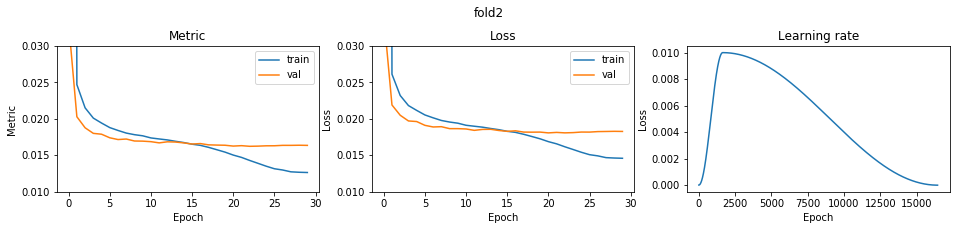

fold 3


epoch1 save best model... 0.03297498599628245
epoch2 save best model... 0.02011240139467841
epoch3 save best model... 0.018747096784955956
epoch4 save best model... 0.018255786971106344
epoch5 save best model... 0.017861437862463178
epoch6 save best model... 0.017764753213148046
epoch7 save best model... 0.017432292287316437
epoch8 save best model... 0.017418173714148426
epoch9 save best model... 0.01711967760243014
epoch10 save best model... 0.01699567051786836
epoch12 save best model... 0.016955808736383915
epoch13 save best model... 0.016930297947571463
epoch14 save best model... 0.016834372298575616
epoch15 save best model... 0.01678771742138002
epoch16 save best model... 0.016707224937703182
epoch17 save best model... 0.01666428455382857
epoch18 save best model... 0.0166460357606411
epoch19 save best model... 0.01654261613735645
epoch20 save best model... 0.016485408360906506
fold3 score: 0.016485408365653403


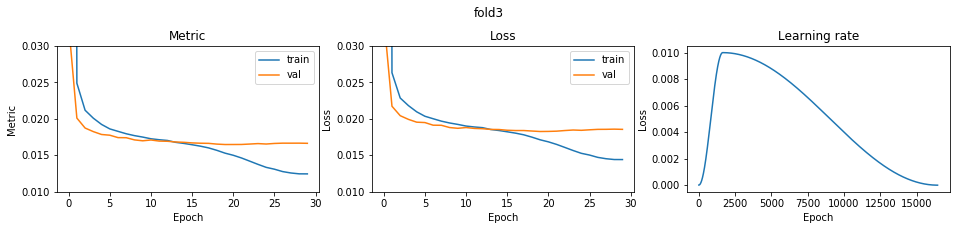

fold 4


epoch1 save best model... 0.032029761921334374
epoch2 save best model... 0.020357224097420253
epoch3 save best model... 0.018444970744006455
epoch4 save best model... 0.0178811564812424
epoch5 save best model... 0.017732227981888216
epoch6 save best model... 0.017453924269926712
epoch7 save best model... 0.01735181545749612
epoch8 save best model... 0.01733582021333362
epoch9 save best model... 0.017035286431041692
epoch10 save best model... 0.01699799312478046
epoch12 save best model... 0.01690390580089801
epoch13 save best model... 0.016881912730736044
epoch14 save best model... 0.016842413651661475
epoch15 save best model... 0.016605265910370204
epoch18 save best model... 0.01649718963008603
epoch21 save best model... 0.01648497450290617
epoch23 save best model... 0.016480689615028188
fold4 score: 0.0164806895418175


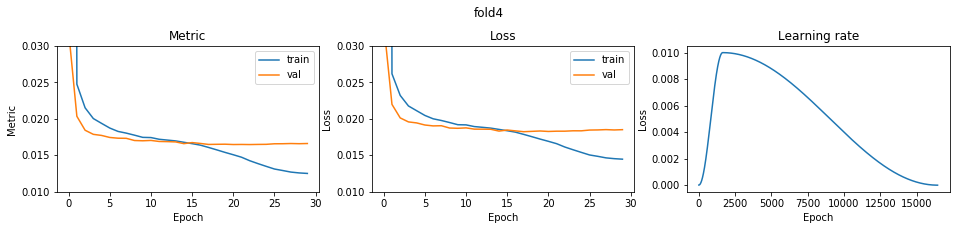

CV score: 0.016390291859379742

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.16813153306145331
epoch2 save best model... 0.02132548273356466
epoch3 save best model... 0.0189560010180658
epoch4 save best model... 0.018062914152691196
epoch5 save best model... 0.01790531098011007
epoch6 save best model... 0.01751996745230261
epoch7 save best model... 0.01724605451259499
epoch8 save best model... 0.017189295530522876
epoch9 save best model... 0.01689885185781128
epoch10 save best model... 0.01677433955896824
epoch11 save best model... 0.01677068501524203
epoch12 save best model... 0.016604199460739426
epoch13 save best model... 0.01654424437561448
epoch14 save best model... 0.01645533909728424
epoch15 save best model... 0.01640099813834953
epoch16 save best model... 0.016335049954270583
epoch17 save best model... 0.016261882419381844
epoch19 save best model... 0.0162412196771159
fold0 score: 0.016241219649834576


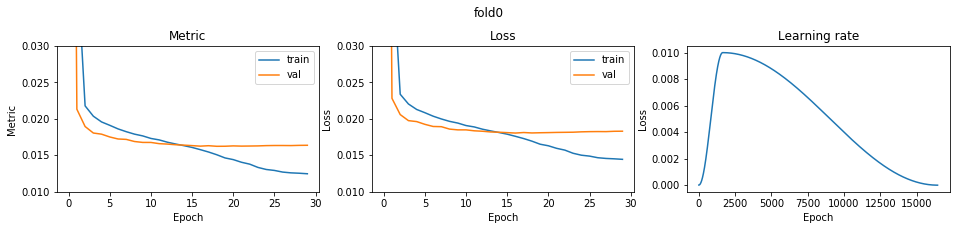

fold 1


epoch1 save best model... 0.15667612169945422
epoch2 save best model... 0.020741418368162068
epoch3 save best model... 0.019500228760759335
epoch4 save best model... 0.018456144767222845
epoch5 save best model... 0.0181476317845178
epoch6 save best model... 0.017767893390228818
epoch8 save best model... 0.017434658727967865
epoch9 save best model... 0.0173483539892984
epoch10 save best model... 0.017038124238728025
epoch11 save best model... 0.016982078531875403
epoch12 save best model... 0.016818837661403924
epoch14 save best model... 0.016697759761061883
epoch15 save best model... 0.016671370380484017
epoch16 save best model... 0.016578168194468553
epoch18 save best model... 0.016547378447135126
epoch19 save best model... 0.016501117539697123
epoch20 save best model... 0.01648024943423593
fold1 score: 0.016480249401279283


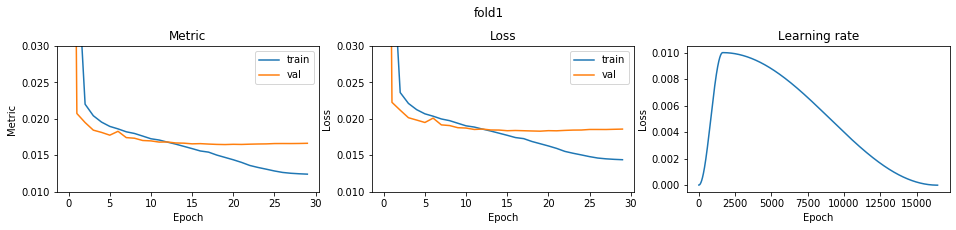

fold 2


epoch1 save best model... 0.16232618858613793
epoch2 save best model... 0.021274543438835877
epoch3 save best model... 0.01900060054748286
epoch4 save best model... 0.018489090375233875
epoch5 save best model... 0.018027973933178083
epoch6 save best model... 0.017581354185860747
epoch7 save best model... 0.017493499256415843
epoch8 save best model... 0.017439603344018503
epoch9 save best model... 0.017029075160169348
epoch10 save best model... 0.016884513375663178
epoch12 save best model... 0.01672573829879044
epoch13 save best model... 0.01662545694527593
epoch15 save best model... 0.01653780850313823
epoch16 save best model... 0.016449091138220996
epoch17 save best model... 0.016400849761339074
epoch18 save best model... 0.016321793476348382
epoch19 save best model... 0.01631803275229217
epoch20 save best model... 0.016302715634299483
epoch22 save best model... 0.016277491662283778
fold2 score: 0.016277491458799854


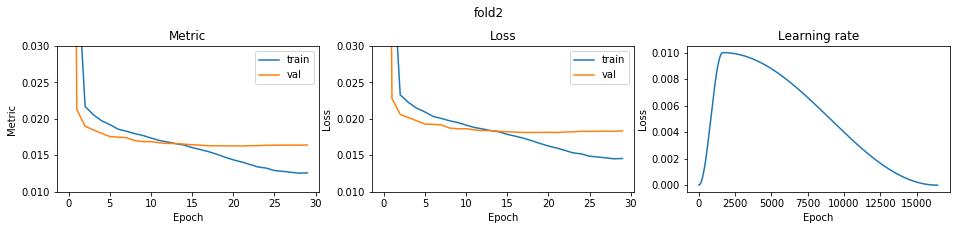

fold 3


epoch1 save best model... 0.1586586554053161
epoch2 save best model... 0.020949202764075005
epoch3 save best model... 0.019439134963603524
epoch4 save best model... 0.018455643287026122
epoch5 save best model... 0.01812805389870883
epoch6 save best model... 0.017706193934472654
epoch7 save best model... 0.01749944571482022
epoch8 save best model... 0.017430823275942465
epoch9 save best model... 0.017130128839445685
epoch11 save best model... 0.017043122254600557
epoch12 save best model... 0.01686838968340859
epoch14 save best model... 0.016738102450576487
epoch15 save best model... 0.016612113932474328
epoch17 save best model... 0.016604751714660124
epoch18 save best model... 0.016436047752330544
fold3 score: 0.016436047595565034


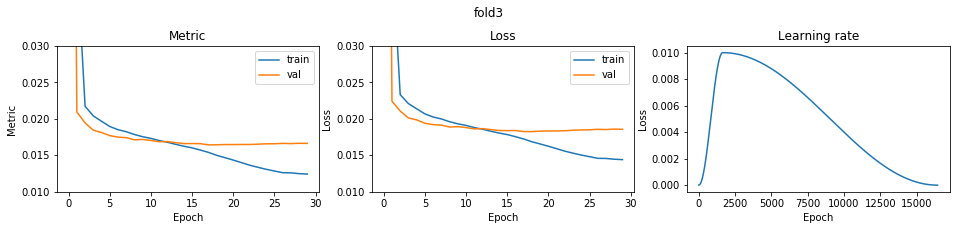

fold 4


epoch1 save best model... 0.1584150689881049
epoch2 save best model... 0.020609191001513823
epoch3 save best model... 0.018963057098481676
epoch4 save best model... 0.018211452680340797
epoch5 save best model... 0.017785173518782595
epoch6 save best model... 0.0174418111121736
epoch7 save best model... 0.01739827958582678
epoch8 save best model... 0.017147365037207585
epoch9 save best model... 0.017040549982381574
epoch10 save best model... 0.016960884627710036
epoch11 save best model... 0.01684532305925813
epoch12 save best model... 0.01674453989307742
epoch14 save best model... 0.01664498130194758
epoch15 save best model... 0.016611800697082676
epoch16 save best model... 0.016559190980682748
epoch17 save best model... 0.016534689301306676
epoch19 save best model... 0.016481552679083206
epoch20 save best model... 0.01648027956579093
fold4 score: 0.016480279502924442


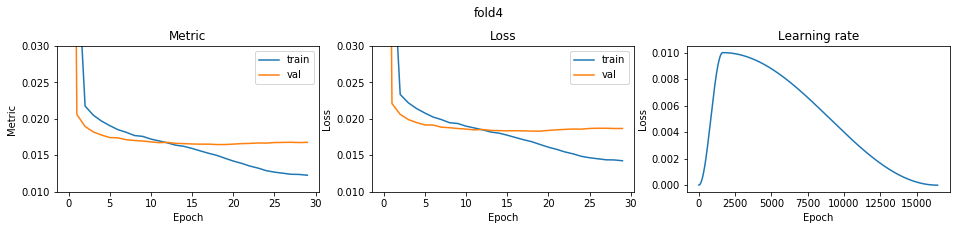

CV score: 0.01638305790322717

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.45963272392614013
epoch2 save best model... 0.02176611544415864
epoch3 save best model... 0.019895329959435996
epoch4 save best model... 0.01887947166919844
epoch5 save best model... 0.01842480129678999
epoch6 save best model... 0.018107376969790676
epoch7 save best model... 0.017763904774039645
epoch8 save best model... 0.017627306608377122
epoch9 save best model... 0.01746084222268814
epoch10 save best model... 0.017396646415589884
epoch11 save best model... 0.017284319880747308
epoch12 save best model... 0.017108197292155992
epoch13 save best model... 0.017057702623324678
epoch14 save best model... 0.016998553630770748
epoch15 save best model... 0.016908545633417326
epoch16 save best model... 0.016873563463738132
epoch17 save best model... 0.016818687024447804
epoch18 save best model... 0.01681762368233709
epoch19 save best model... 0.016736234071959396
epoch20 save best model... 0.016653179992541907
epoch22 save best model... 0.016652194359647387
epoch24

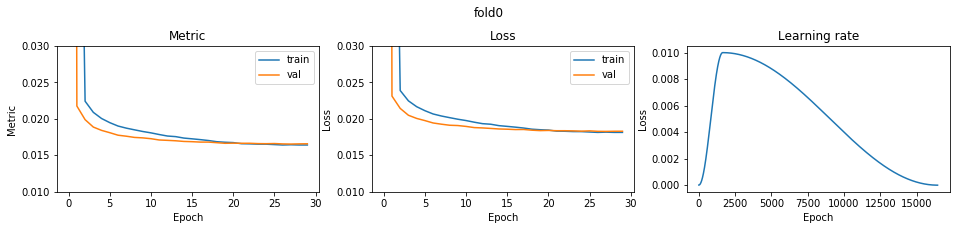

fold 1


epoch1 save best model... 0.47110203425252484
epoch2 save best model... 0.021647192759315852
epoch3 save best model... 0.020103886855079092
epoch4 save best model... 0.01900190689301173
epoch5 save best model... 0.01844360046665865
epoch6 save best model... 0.018347608515435536
epoch7 save best model... 0.018046449944563676
epoch8 save best model... 0.01784577551107929
epoch9 save best model... 0.017707163431930174
epoch10 save best model... 0.017459094079623438
epoch12 save best model... 0.01732658215442587
epoch13 save best model... 0.017232790225630852
epoch14 save best model... 0.017177443964524405
epoch15 save best model... 0.017122757581429074
epoch16 save best model... 0.017078718454015773
epoch17 save best model... 0.01700009515954194
epoch18 save best model... 0.01695151432269009
epoch20 save best model... 0.016915333668424862
epoch21 save best model... 0.016889150756905457
epoch23 save best model... 0.01681737474822175
epoch26 save best model... 0.016813437119983586
epoch28 s

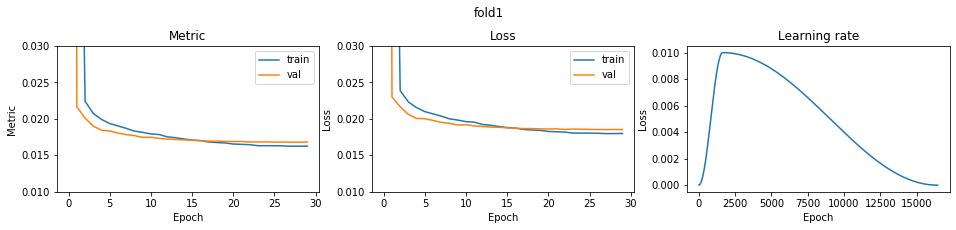

fold 2


epoch1 save best model... 0.4695746048921658
epoch2 save best model... 0.021741041885618876
epoch3 save best model... 0.020056361318955284
epoch4 save best model... 0.018803809790883284
epoch5 save best model... 0.018442694747497535
epoch6 save best model... 0.017967773299671898
epoch7 save best model... 0.017710266993430947
epoch8 save best model... 0.01763418308162362
epoch9 save best model... 0.01744413063482662
epoch10 save best model... 0.017247489649920428
epoch11 save best model... 0.017186572294835892
epoch12 save best model... 0.017048195711071575
epoch13 save best model... 0.016970858038554814
epoch14 save best model... 0.01687825422846061
epoch15 save best model... 0.01684541647201737
epoch16 save best model... 0.016813399331288965
epoch17 save best model... 0.016717135734978354
epoch18 save best model... 0.016709051311175654
epoch19 save best model... 0.01664262363234334
epoch20 save best model... 0.01663397317024414
epoch21 save best model... 0.016592849840448884
epoch22 s

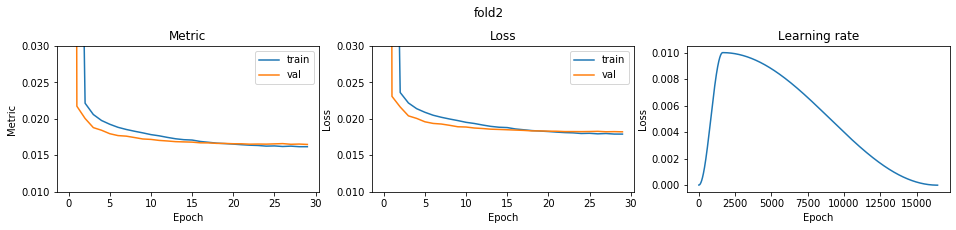

fold 3


epoch1 save best model... 0.46166751601972994
epoch2 save best model... 0.021976921104047455
epoch3 save best model... 0.019991564827892667
epoch4 save best model... 0.01925965504962654
epoch5 save best model... 0.01867384088770879
epoch6 save best model... 0.01827776163332758
epoch7 save best model... 0.018035240300373092
epoch8 save best model... 0.01799771293853505
epoch9 save best model... 0.01767682477466949
epoch10 save best model... 0.017529994017255742
epoch11 save best model... 0.01744034705738747
epoch12 save best model... 0.017355816554626056
epoch13 save best model... 0.017245600362369846
epoch15 save best model... 0.017139822631174854
epoch16 save best model... 0.017050802524801945
epoch17 save best model... 0.017047253198463445
epoch18 save best model... 0.017005788941776425
epoch19 save best model... 0.01700115694382264
epoch21 save best model... 0.01685567664487419
epoch26 save best model... 0.01684936088528951
epoch27 save best model... 0.016847456314501297
epoch28 sav

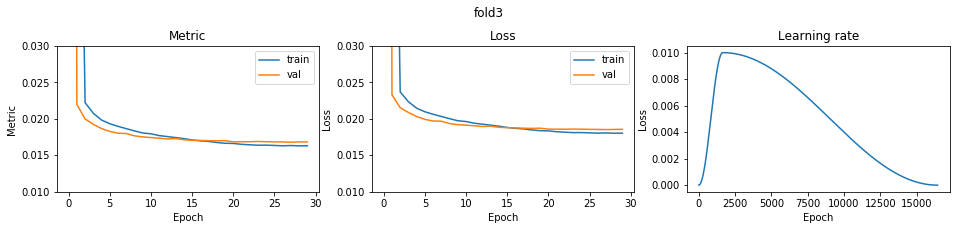

fold 4


epoch1 save best model... 0.46125949163643265
epoch2 save best model... 0.021529022553311936
epoch3 save best model... 0.019669392666777336
epoch4 save best model... 0.018771671007359762
epoch5 save best model... 0.018346063352289665
epoch6 save best model... 0.017984892321423817
epoch7 save best model... 0.01774130171347316
epoch8 save best model... 0.0175827481548444
epoch9 save best model... 0.017520036049407814
epoch10 save best model... 0.017337686881202366
epoch11 save best model... 0.017280684095427632
epoch12 save best model... 0.017132197514363057
epoch13 save best model... 0.01709446397340583
epoch14 save best model... 0.017060941844279105
epoch15 save best model... 0.017043415493075153
epoch16 save best model... 0.016966530532578267
epoch17 save best model... 0.016934234617120993
epoch18 save best model... 0.01693381518252822
epoch19 save best model... 0.01683265886403162
epoch20 save best model... 0.01681703953984658
epoch21 save best model... 0.016770068923932138
epoch24 s

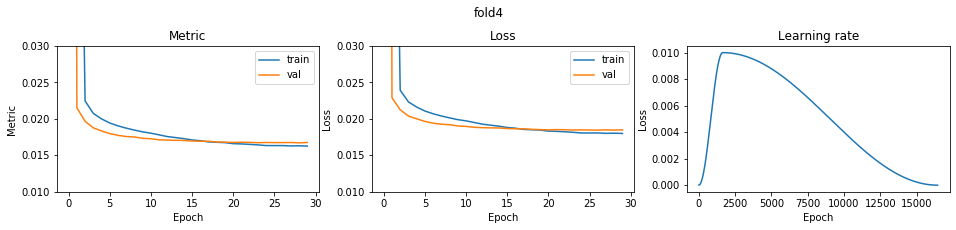

CV score: 0.01667185577514282

optimizer: LookaheadAdamW
fold 0


epoch1 save best model... 0.03272436648641198
epoch2 save best model... 0.020072440351603514
epoch3 save best model... 0.018588058507082676
epoch4 save best model... 0.01794367654329688
epoch5 save best model... 0.01762415188320134
epoch6 save best model... 0.017305664046071385
epoch7 save best model... 0.017115199228999012
epoch8 save best model... 0.01709563986298571
epoch9 save best model... 0.016771020271851424
epoch11 save best model... 0.016699637828186866
epoch12 save best model... 0.016556438545702802
epoch13 save best model... 0.01649797400353574
epoch14 save best model... 0.01640145856725871
epoch15 save best model... 0.01632174936108342
epoch16 save best model... 0.016307143636200585
epoch17 save best model... 0.016283105461007506
epoch18 save best model... 0.016253480476439677
epoch19 save best model... 0.016252522555801483
fold0 score: 0.016252522438079068


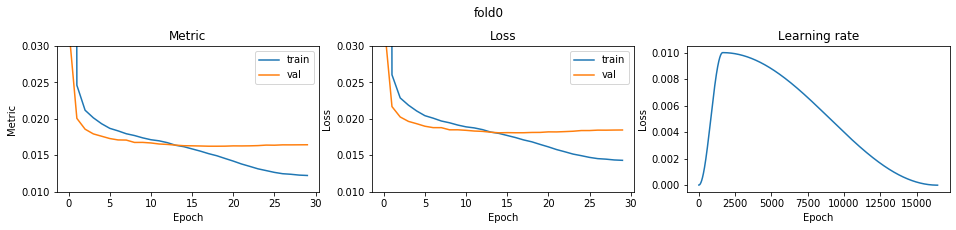

fold 1


epoch1 save best model... 0.03255336003080537
epoch2 save best model... 0.02032987544672531
epoch3 save best model... 0.018790359251705326
epoch4 save best model... 0.01796149878278222
epoch5 save best model... 0.01761082392317487
epoch6 save best model... 0.017482605406080407
epoch7 save best model... 0.017353379043482463
epoch8 save best model... 0.017261139483641563
epoch9 save best model... 0.017018779951847342
epoch10 save best model... 0.016988907897822418
epoch11 save best model... 0.016985244042135896
epoch12 save best model... 0.016825140169534156
epoch13 save best model... 0.016783121916620153
epoch15 save best model... 0.016745151857906808
epoch16 save best model... 0.016587934089668806
epoch18 save best model... 0.016544672453427577
fold1 score: 0.016544672433723425


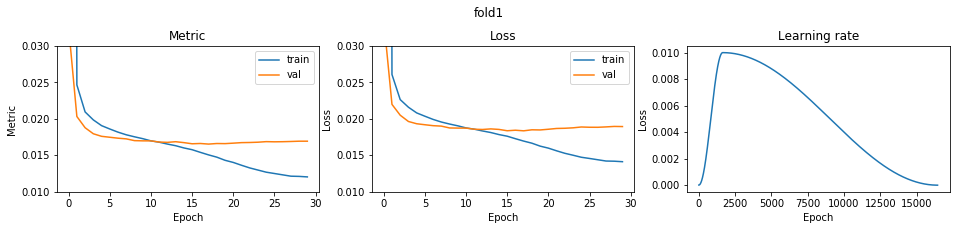

fold 2


epoch1 save best model... 0.03412973950792076
epoch2 save best model... 0.02007095008497766
epoch3 save best model... 0.018918044138152307
epoch4 save best model... 0.018278503618195677
epoch5 save best model... 0.017593057977244017
epoch6 save best model... 0.017496504262598998
epoch7 save best model... 0.017214999823623282
epoch8 save best model... 0.017073960875293188
epoch9 save best model... 0.016947990598266967
epoch10 save best model... 0.01679189221886377
epoch11 save best model... 0.016734950607491875
epoch12 save best model... 0.01669328070062559
epoch13 save best model... 0.016618233244746455
epoch14 save best model... 0.01653171434453596
epoch15 save best model... 0.01647679260334581
epoch16 save best model... 0.0164011969642939
epoch17 save best model... 0.01638086168547444
epoch18 save best model... 0.016380676444374596
epoch21 save best model... 0.016372199987453245
fold2 score: 0.016372199909040482


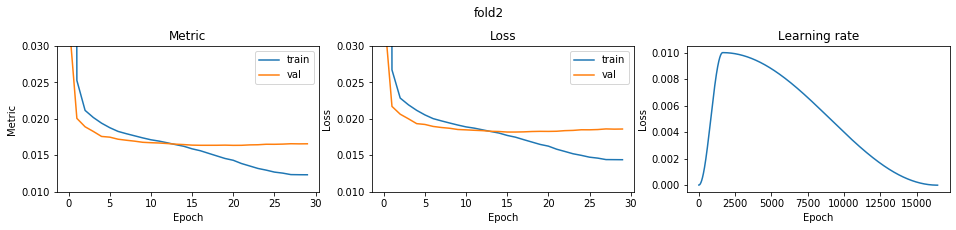

fold 3


epoch1 save best model... 0.03172474515057914
epoch2 save best model... 0.020191905612299953
epoch3 save best model... 0.018643614510604624
epoch4 save best model... 0.01808520794967041
epoch5 save best model... 0.017897767011407162
epoch6 save best model... 0.017480417393181888
epoch7 save best model... 0.01732391042970036
epoch8 save best model... 0.01727274014086278
epoch9 save best model... 0.017108741117501314
epoch10 save best model... 0.01701766496570887
epoch11 save best model... 0.016970808822279776
epoch12 save best model... 0.016805712592306468
epoch13 save best model... 0.016713531653063714
epoch14 save best model... 0.016692157125350826
epoch15 save best model... 0.01667025166994347
epoch16 save best model... 0.01657007086920236
epoch18 save best model... 0.016549520709197588
epoch19 save best model... 0.016534905700365206
fold3 score: 0.016534905574170245


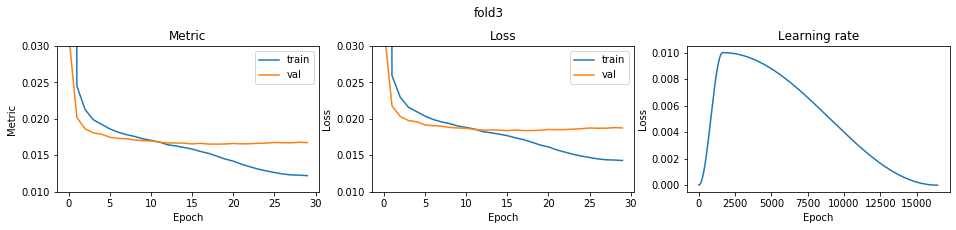

fold 4


epoch1 save best model... 0.03483716698622242
epoch2 save best model... 0.019467156360897495
epoch3 save best model... 0.01840176235943829
epoch4 save best model... 0.01809331347873108
epoch5 save best model... 0.0176835310057756
epoch6 save best model... 0.017408377850313666
epoch7 save best model... 0.01736272496886229
epoch8 save best model... 0.017229632981936183
epoch9 save best model... 0.01699236215586543
epoch10 save best model... 0.01696266695042406
epoch11 save best model... 0.016953220139077286
epoch12 save best model... 0.016791059494290102
epoch13 save best model... 0.01669348075027007
epoch14 save best model... 0.016683402175936585
epoch16 save best model... 0.01660869157319392
epoch17 save best model... 0.016551925776980326
epoch18 save best model... 0.01647898105857788
epoch19 save best model... 0.016446670129521834
fold4 score: 0.016446670286710565


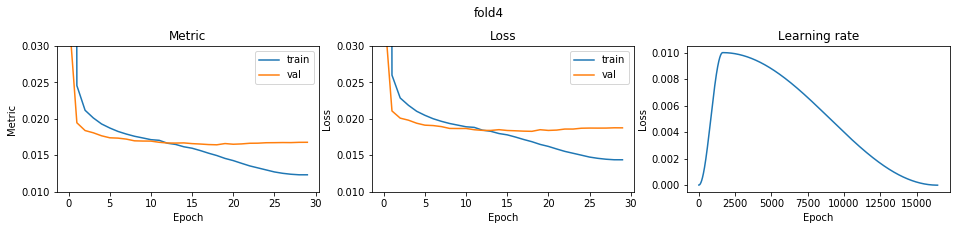

CV score: 0.016430191554803377


In [23]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [25]:
score_dict

{'AdaBelief': 0.016387571500691304,
 'AdaBound': 0.019412330158617055,
 'AdaMod': 0.016410009667571113,
 'AdamW': 0.016432326163697428,
 'AdamP': 0.016352636009008794,
 'DiffGrad': 0.016403799691823935,
 'Lamb': 0.016487573171714242,
 'NovoGrad': 0.016305631972616273,
 'PlainRAdam': 0.016433031343862658,
 'QHAdam': 0.016330739905402732,
 'RAdam': 0.016437869179539828,
 'Ranger': 0.016407080491035002,
 'RangerQH': 0.01640646570512739,
 'RangerVA': 0.01842162840871995,
 'SWATS': 0.01632895101193264,
 'Yogi': 0.016322339546968916,
 'Adam': 0.016332079810596315,
 'LookaheadAdam': 0.01639029185937974,
 'LookaheadDiffGrad': 0.016383057903227208,
 'LookaheadYogi': 0.016671855775142845,
 'LookaheadAdamW': 0.01643019155480344}

In [26]:
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

metric
AdaBelief          0.016388
AdaBound           0.019412
AdaMod             0.016410
AdamW              0.016432
AdamP              0.016353
DiffGrad           0.016404
Lamb               0.016488
NovoGrad           0.016306
PlainRAdam         0.016433
QHAdam             0.016331
RAdam              0.016438
Ranger             0.016407
RangerQH           0.016406
RangerVA           0.018422
SWATS              0.016329
Yogi               0.016322
Adam               0.016332
LookaheadAdam      0.016390
LookaheadDiffGrad  0.016383
LookaheadYogi      0.016672
LookaheadAdamW     0.016430

In [27]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))

                     metric
AdaBelief          0.016388
AdaBound           0.019412
AdaMod             0.016410
AdamW              0.016432
AdamP              0.016353
DiffGrad           0.016404
Lamb               0.016488
NovoGrad           0.016306
PlainRAdam         0.016433
QHAdam             0.016331
RAdam              0.016438
Ranger             0.016407
RangerQH           0.016406
RangerVA           0.018422
SWATS              0.016329
Yogi               0.016322
Adam               0.016332
LookaheadAdam      0.016390
LookaheadDiffGrad  0.016383
LookaheadYogi      0.016672
LookaheadAdamW     0.016430


In [37]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}

In [39]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

metric
NovoGrad           0.016306
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412

In [40]:
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))

                     metric
NovoGrad           0.016306
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412



optimizer: RangerLars
fold 0


epoch1 save best model... 0.2552713413173354
epoch2 save best model... 0.021031844215403928
epoch3 save best model... 0.01918961815960315
epoch4 save best model... 0.018257898931520945
epoch5 save best model... 0.01783448367852692
epoch6 save best model... 0.017487467914514228
epoch7 save best model... 0.01724419338132227
epoch8 save best model... 0.017045642448279472
epoch9 save best model... 0.016943158155862996
epoch10 save best model... 0.0167435646871771
epoch11 save best model... 0.01669169573881292
epoch12 save best model... 0.016512058791121074
epoch13 save best model... 0.016400923057202598
epoch14 save best model... 0.016377426568495113
epoch15 save best model... 0.01630047205071854
epoch16 save best model... 0.016203235615901902
epoch17 save best model... 0.01618356508815954
fold0 score: 0.016183564867027517


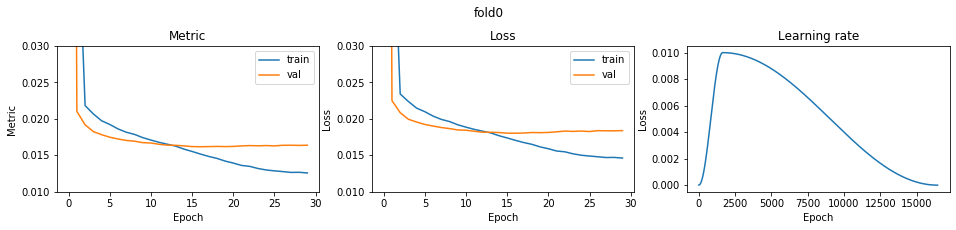

fold 1


epoch1 save best model... 0.23434139402805196
epoch2 save best model... 0.021088118236923605
epoch3 save best model... 0.01923126692924624
epoch4 save best model... 0.018365646281938913
epoch5 save best model... 0.01784043121717125
epoch6 save best model... 0.017587830638268943
epoch8 save best model... 0.017395433616915906
epoch9 save best model... 0.017234730914720615
epoch10 save best model... 0.017039416163928907
epoch11 save best model... 0.016830780636116024
epoch13 save best model... 0.016635841901561997
epoch15 save best model... 0.016608922067740207
epoch16 save best model... 0.01659491712553819
epoch17 save best model... 0.016536635543839565
epoch19 save best model... 0.016530318964866033
fold1 score: 0.016530318811633984


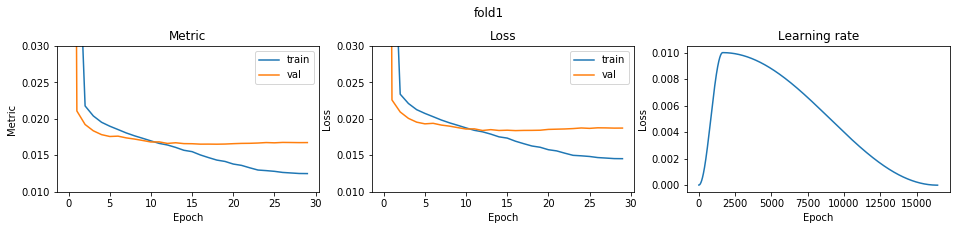

fold 2


epoch1 save best model... 0.2379083615360838
epoch2 save best model... 0.020740009961859
epoch3 save best model... 0.01919260411974196
epoch4 save best model... 0.018368804147248455
epoch5 save best model... 0.01778367606638219
epoch6 save best model... 0.01767669823725183
epoch7 save best model... 0.017472411795099358
epoch8 save best model... 0.01720943254405727
epoch9 save best model... 0.016942551066281175
epoch10 save best model... 0.016774191002716477
epoch11 save best model... 0.016693987324706554
epoch12 save best model... 0.016556576884456282
epoch14 save best model... 0.016451786670092842
epoch15 save best model... 0.016332250394225867
epoch18 save best model... 0.016294581864829568
fold2 score: 0.01629458166643227


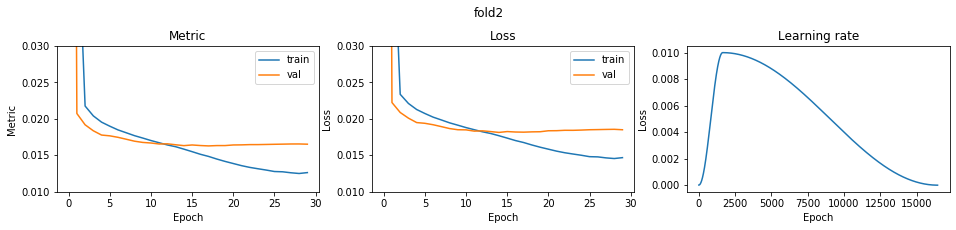

fold 3


epoch1 save best model... 0.2543273255534487
epoch2 save best model... 0.020818053925906337
epoch3 save best model... 0.0192497786333899
epoch4 save best model... 0.0183892401533545
epoch5 save best model... 0.01808182095646315
epoch6 save best model... 0.0176754283152334
epoch7 save best model... 0.017521916272156875
epoch8 save best model... 0.017261454941182988
epoch9 save best model... 0.017101566002604495
epoch10 save best model... 0.017008767992784196
epoch11 save best model... 0.016906976672250072
epoch12 save best model... 0.0167851442564491
epoch14 save best model... 0.016622584372555205
epoch15 save best model... 0.016565941281379084
epoch16 save best model... 0.016544775374590127
epoch18 save best model... 0.01647636894442158
fold3 score: 0.01647636873578237


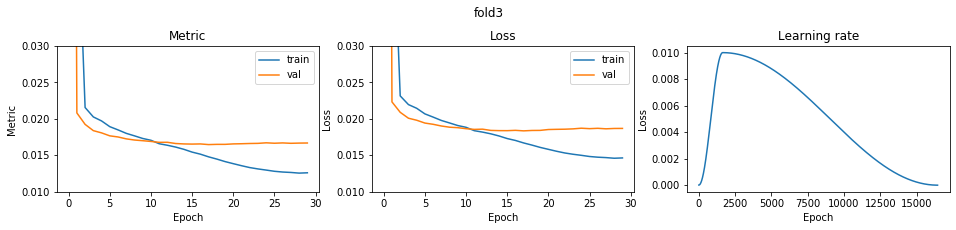

fold 4


epoch1 save best model... 0.24518570524549158
epoch2 save best model... 0.020701582891896265
epoch3 save best model... 0.018926801019112722
epoch4 save best model... 0.01818249232108134
epoch5 save best model... 0.017738854603370935
epoch6 save best model... 0.017485240357662794
epoch7 save best model... 0.017385897176565097
epoch8 save best model... 0.01713918528067699
epoch9 save best model... 0.016936091861447875
epoch10 save best model... 0.01686061526222286
epoch11 save best model... 0.016726459000590586
epoch12 save best model... 0.016675042417027684
epoch13 save best model... 0.016587214059448865
epoch14 save best model... 0.016539081097803245
epoch15 save best model... 0.016433438745694307
epoch17 save best model... 0.01643238967000284
epoch18 save best model... 0.016413216520279036
epoch19 save best model... 0.016386315587627997
fold4 score: 0.01638631552391006


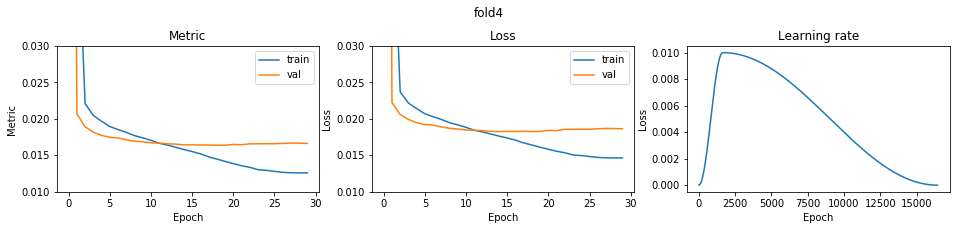

CV score: 0.016374226438150778


In [41]:
optimizer = RangerLars
CFG.optimizer = optimizer
logger.info('')
logger.info('optimizer: '+ optimizer.__name__)
oof, predictions = run_kfold_nn(CFG,
                                trn_df,
                                test_df,
                                CFG.feature_cols,
                                CFG.target_cols,
                                n_fold=5)

# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
score_dict[optimizer.__name__] = score

In [42]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
NovoGrad           0.016306
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
RangerLars         0.016374
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412


metric
NovoGrad           0.016306
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
RangerLars         0.016374
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.022328140276880903
epoch2 save best model... 0.019449921265448145
epoch3 save best model... 0.01834344113148019
epoch4 save best model... 0.017986464336650246
epoch5 save best model... 0.01747284550516779
epoch6 save best model... 0.017328341684573603
epoch7 save best model... 0.017195330071422123
epoch10 save best model... 0.01714420905145806
epoch12 save best model... 0.01704902131628067
epoch15 save best model... 0.01699916120779813
epoch16 save best model... 0.01694857446319829
epoch17 save best model... 0.016790515646032973
epoch19 save best model... 0.01671202370052593
epoch20 save best model... 0.01663153570586633
epoch21 save best model... 0.01649960139914838
epoch22 save best model... 0.016402087424688704
epoch23 save best model... 0.01636962024176786
epoch24 save best model... 0.0162549373619513
epoch25 save best model... 0.01617988785325734
epoch26 save best model... 0.0161685534394378
epoch27 save best model... 0.016142395068732236
epoch29 save b

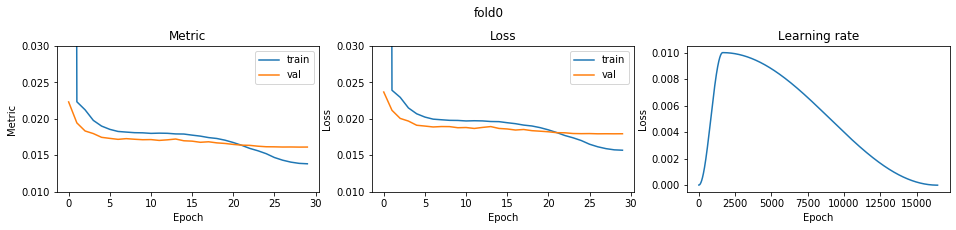

fold 1


epoch1 save best model... 0.022139129078868284
epoch2 save best model... 0.019719411137962183
epoch3 save best model... 0.018642493556759697
epoch4 save best model... 0.018271470602409093
epoch5 save best model... 0.01785259350275336
epoch6 save best model... 0.017509561148339507
epoch8 save best model... 0.017371047488915593
epoch11 save best model... 0.017345451422869196
epoch14 save best model... 0.01722373674679051
epoch16 save best model... 0.017193248699590866
epoch17 save best model... 0.017164434480959775
epoch18 save best model... 0.017078823300906494
epoch19 save best model... 0.01693244904850937
epoch21 save best model... 0.016790565275382374
epoch22 save best model... 0.016648039250409898
epoch23 save best model... 0.016595059997296248
epoch24 save best model... 0.016586543076541584
epoch25 save best model... 0.01651734905306816
epoch26 save best model... 0.01648658230848989
fold1 score: 0.016486582290454764


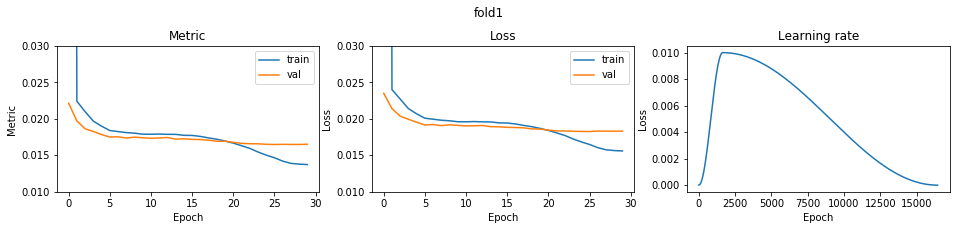

fold 2


epoch1 save best model... 0.022516456465955122
epoch2 save best model... 0.019364964381186258
epoch3 save best model... 0.018629983095946604
epoch4 save best model... 0.017917639218350562
epoch5 save best model... 0.017601797096838668
epoch6 save best model... 0.017454722223985464
epoch7 save best model... 0.01732379936490706
epoch9 save best model... 0.017229607481128346
epoch13 save best model... 0.017177702472849707
epoch14 save best model... 0.01697252427055281
epoch18 save best model... 0.01682982476431122
epoch19 save best model... 0.016730575879374134
epoch21 save best model... 0.01652671624671886
epoch22 save best model... 0.01643780795982505
epoch23 save best model... 0.016382705270446198
epoch24 save best model... 0.01627055115023393
epoch26 save best model... 0.01623418700632398
epoch27 save best model... 0.016214519399427273
fold2 score: 0.016214519276861794


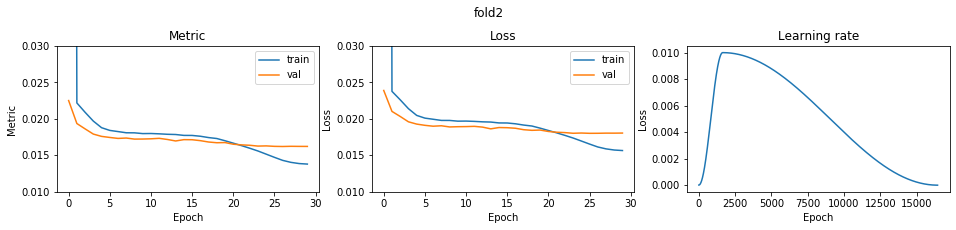

fold 3


epoch1 save best model... 0.02242003951416879
epoch2 save best model... 0.019352650507045634
epoch3 save best model... 0.018654952230937525
epoch4 save best model... 0.018064147916225747
epoch5 save best model... 0.01783315002544866
epoch6 save best model... 0.01767012827471747
epoch7 save best model... 0.01756670234050254
epoch8 save best model... 0.017396278315752
epoch11 save best model... 0.01739465239073801
epoch12 save best model... 0.017382690684280118
epoch13 save best model... 0.017202791123139695
epoch16 save best model... 0.017192156555593557
epoch17 save best model... 0.01707842158862222
epoch18 save best model... 0.01702060468605208
epoch19 save best model... 0.016914233105821463
epoch20 save best model... 0.0168121285549872
epoch21 save best model... 0.016746529339386283
epoch22 save best model... 0.016622208848442874
epoch23 save best model... 0.016554001998368456
epoch24 save best model... 0.01640817972880222
epoch26 save best model... 0.016388648477274764
fold3 score: 

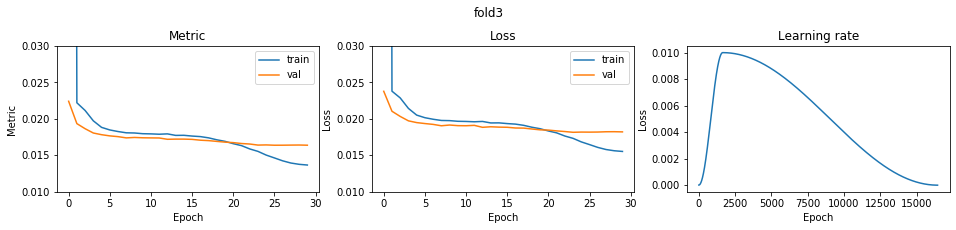

fold 4


epoch1 save best model... 0.02173254567713971
epoch2 save best model... 0.019936790179826133
epoch3 save best model... 0.018362813115815776
epoch4 save best model... 0.017865613562421945
epoch5 save best model... 0.017669910172123573
epoch6 save best model... 0.01758294535380765
epoch7 save best model... 0.017326727348691645
epoch8 save best model... 0.01726369127368126
epoch9 save best model... 0.017262982711586296
epoch10 save best model... 0.017152913966998966
epoch15 save best model... 0.01703822592778263
epoch17 save best model... 0.016947533045990865
epoch18 save best model... 0.016892360556862215
epoch19 save best model... 0.01674893964760871
epoch21 save best model... 0.01661838612992291
epoch22 save best model... 0.01661630132721402
epoch23 save best model... 0.016579594350672393
epoch24 save best model... 0.01644230402861817
epoch25 save best model... 0.01641997832949178
epoch26 save best model... 0.016356866345539317
fold4 score: 0.016356866213532925


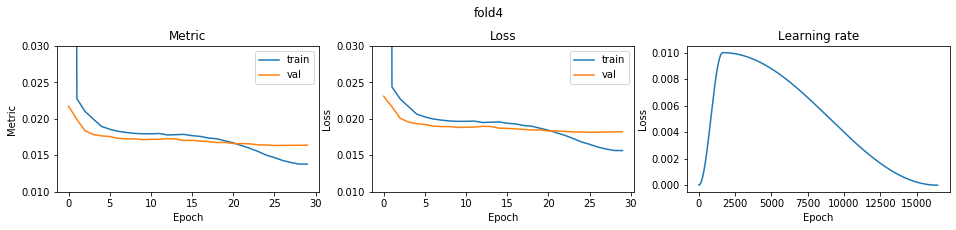

CV score: 0.016315842056319023

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.02194279491952313
epoch2 save best model... 0.019676791569366543
epoch3 save best model... 0.018413289742446708
epoch4 save best model... 0.01816901512919227
epoch5 save best model... 0.017637168547321017
epoch6 save best model... 0.017450861600577697
epoch7 save best model... 0.017209484269481858
epoch8 save best model... 0.017104112989097357
epoch9 save best model... 0.017009110176821232
epoch10 save best model... 0.01695115457380144
epoch11 save best model... 0.01692107079767013
epoch13 save best model... 0.016769662760792125
epoch14 save best model... 0.01666541795388441
epoch15 save best model... 0.016540291475170294
epoch16 save best model... 0.01645124727575817
epoch17 save best model... 0.016380813531153296
epoch18 save best model... 0.016318114917801697
epoch19 save best model... 0.016284047283130383
epoch20 save best model... 0.01620652023575572
epoch21 save best model... 0.016169993063023396
fold0 score: 0.016169992888866926


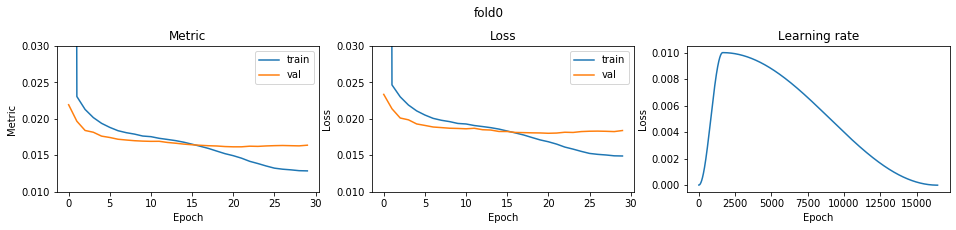

fold 1


epoch1 save best model... 0.021933749354620353
epoch2 save best model... 0.01949339537478357
epoch3 save best model... 0.018850946213687627
epoch4 save best model... 0.0183498035266734
epoch5 save best model... 0.017797770684826453
epoch6 save best model... 0.017609305536354505
epoch8 save best model... 0.017318053066426635
epoch10 save best model... 0.017185329413985737
epoch11 save best model... 0.017142612818950236
epoch12 save best model... 0.01709671375356779
epoch13 save best model... 0.016981651047386838
epoch14 save best model... 0.01687143566025352
epoch15 save best model... 0.016810721632472596
epoch16 save best model... 0.01676025989599735
epoch17 save best model... 0.016669456512593182
epoch20 save best model... 0.016574567512329604
epoch22 save best model... 0.016545764494183993
fold1 score: 0.0165457644588142


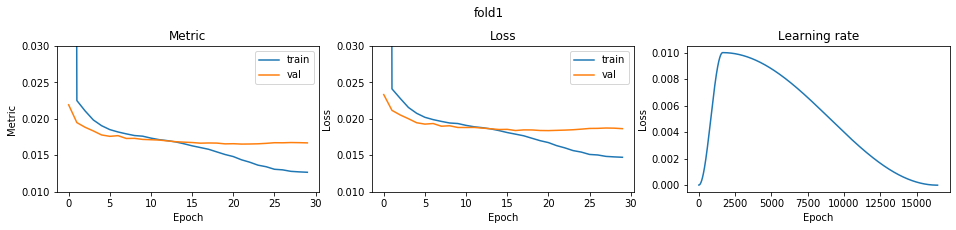

fold 2


epoch1 save best model... 0.022270800222851307
epoch2 save best model... 0.019672978929767892
epoch3 save best model... 0.018590856938289536
epoch4 save best model... 0.017980540527116128
epoch5 save best model... 0.017528579981798572
epoch7 save best model... 0.01732022399717242
epoch9 save best model... 0.017043233778659576
epoch12 save best model... 0.016830400472744964
epoch15 save best model... 0.01668458604961498
epoch16 save best model... 0.016526695781812414
epoch17 save best model... 0.016519648009369236
epoch19 save best model... 0.016432792720495026
epoch20 save best model... 0.016380784517049274
epoch24 save best model... 0.016380463165563557
fold2 score: 0.016380463067069268


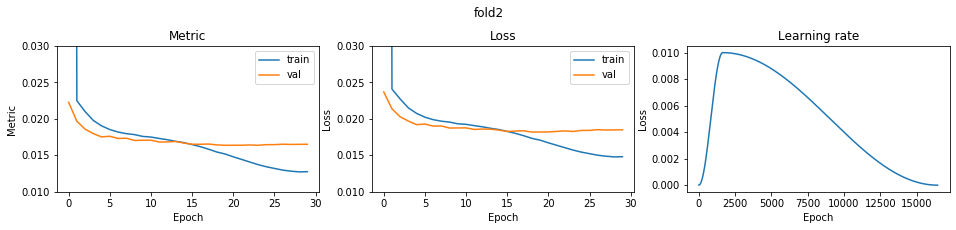

fold 3


epoch1 save best model... 0.022156606504273577
epoch2 save best model... 0.019663834610873312
epoch3 save best model... 0.0187055796058106
epoch4 save best model... 0.018242634676295017
epoch5 save best model... 0.017968690366079024
epoch6 save best model... 0.01760723205296013
epoch7 save best model... 0.017490839297567114
epoch8 save best model... 0.01739568496313888
epoch9 save best model... 0.017284225832017518
epoch11 save best model... 0.01724931653546581
epoch12 save best model... 0.01713763595111074
epoch13 save best model... 0.017019225870405486
epoch15 save best model... 0.0168130905925379
epoch17 save best model... 0.016792013856385048
epoch18 save best model... 0.016616079114920593
epoch19 save best model... 0.01656486424309857
epoch21 save best model... 0.016475969719740823
fold3 score: 0.016475969535443623


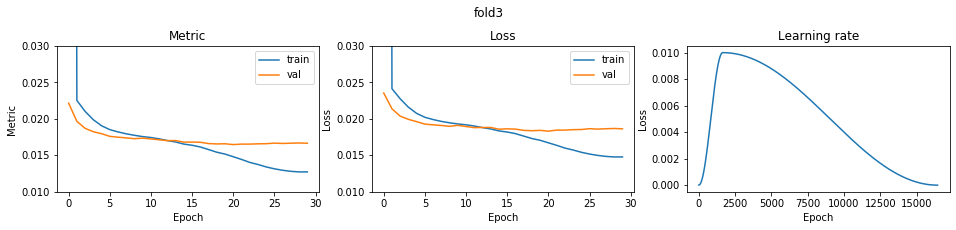

fold 4


epoch1 save best model... 0.021809648404190644
epoch2 save best model... 0.01928194569071632
epoch3 save best model... 0.018526199420146085
epoch4 save best model... 0.01800309086010573
epoch5 save best model... 0.017706812576206234
epoch6 save best model... 0.017425864123673536
epoch7 save best model... 0.017263860543574587
epoch9 save best model... 0.01703746436049224
epoch10 save best model... 0.01703133625498122
epoch12 save best model... 0.016939508322210545
epoch13 save best model... 0.016917904544460474
epoch14 save best model... 0.01681460787697031
epoch15 save best model... 0.016660012781263618
epoch16 save best model... 0.016536996561125904
epoch20 save best model... 0.016478354989599802
epoch21 save best model... 0.01644315875065354
epoch23 save best model... 0.016430746740184233
fold4 score: 0.016430746634398228


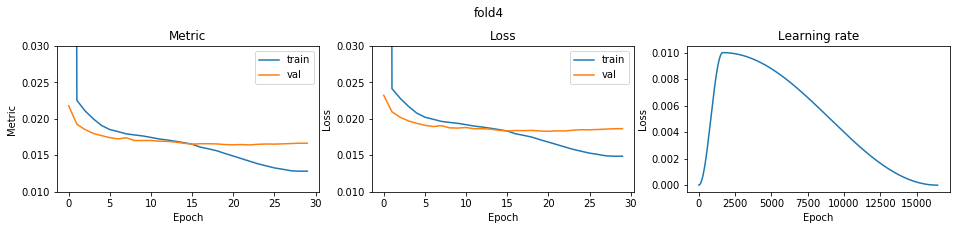

CV score: 0.016400581619228815

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.7132370736713018
epoch2 save best model... 0.698453522407384
epoch3 save best model... 0.6278354421291916
epoch4 save best model... 0.3317113374659032
epoch5 save best model... 0.11691861542319383
epoch6 save best model... 0.05445290844641405
epoch7 save best model... 0.034820382030583186
epoch8 save best model... 0.027156097019316122
epoch9 save best model... 0.023883545053337864
epoch10 save best model... 0.022203632840432717
epoch11 save best model... 0.021244929399095256
epoch12 save best model... 0.02076996664658766
epoch13 save best model... 0.020507713874848666
epoch14 save best model... 0.02033885578139089
epoch15 save best model... 0.020238510153525784
epoch16 save best model... 0.020130141410374152
epoch17 save best model... 0.019870006704622356
epoch19 save best model... 0.019765076016612638
epoch21 save best model... 0.01972715023709864
epoch22 save best model... 0.019701217660565856
epoch23 save best model... 0.01969058307350225
epoch25 save bes

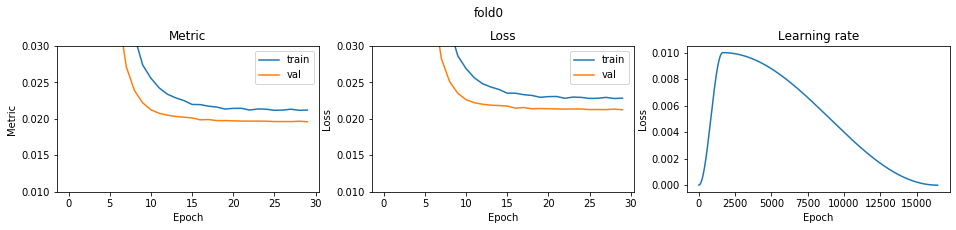

fold 1


epoch1 save best model... 0.7111684850963055
epoch2 save best model... 0.6985153249494849
epoch3 save best model... 0.6268990097949814
epoch4 save best model... 0.3374495036877975
epoch5 save best model... 0.12055209650485982
epoch6 save best model... 0.055755575469935446
epoch7 save best model... 0.03493550905139171
epoch8 save best model... 0.027282329327555227
epoch9 save best model... 0.02391027553037987
epoch10 save best model... 0.0224456582642798
epoch11 save best model... 0.0216338145029921
epoch12 save best model... 0.021102946254601507
epoch13 save best model... 0.020660750752098063
epoch14 save best model... 0.020475594348073223
epoch15 save best model... 0.02035188564288437
epoch16 save best model... 0.020315402018712223
epoch17 save best model... 0.020044004379528264
epoch19 save best model... 0.019974366882058423
epoch20 save best model... 0.019885921230767576
epoch21 save best model... 0.019856065670425135
epoch22 save best model... 0.019849743465745494
epoch23 save best

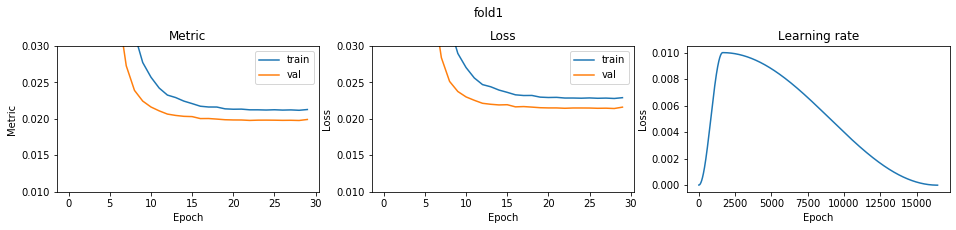

fold 2


epoch1 save best model... 0.7052280520165148
epoch2 save best model... 0.6921268694084091
epoch3 save best model... 0.6229680498468221
epoch4 save best model... 0.32799730334311256
epoch5 save best model... 0.11967645093245234
epoch6 save best model... 0.0547456150981866
epoch7 save best model... 0.035348691881436314
epoch8 save best model... 0.02752048051501222
epoch9 save best model... 0.024182624685860056
epoch10 save best model... 0.02238488892094574
epoch11 save best model... 0.021547299367327927
epoch12 save best model... 0.02114686421501688
epoch13 save best model... 0.02069851716118403
epoch14 save best model... 0.020544732181326922
epoch15 save best model... 0.02030719025368217
epoch16 save best model... 0.02015491317737806
epoch17 save best model... 0.020108144205359807
epoch18 save best model... 0.0200325562492417
epoch19 save best model... 0.019966350360774564
epoch20 save best model... 0.019893197438665418
epoch21 save best model... 0.019876072057207723
epoch22 save best m

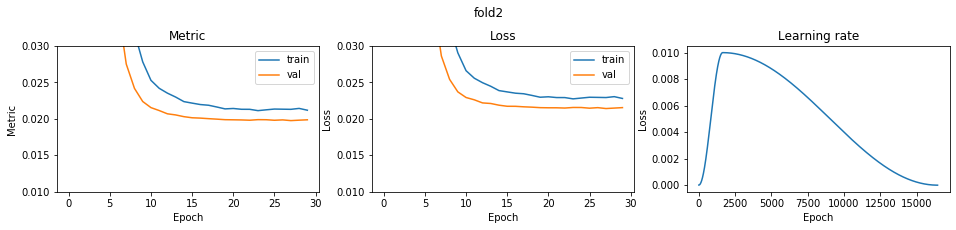

fold 3


epoch1 save best model... 0.7169077810502541
epoch2 save best model... 0.7046959239692514
epoch3 save best model... 0.6352648985684597
epoch4 save best model... 0.3436371264941057
epoch5 save best model... 0.12185331224241126
epoch6 save best model... 0.0573636716685697
epoch7 save best model... 0.035958220678167355
epoch8 save best model... 0.027629739995663965
epoch9 save best model... 0.024150724640298542
epoch10 save best model... 0.022632800809750525
epoch11 save best model... 0.02161666108274107
epoch12 save best model... 0.021122930213333807
epoch13 save best model... 0.020780812867053685
epoch14 save best model... 0.020548678761038396
epoch15 save best model... 0.020346705489929826
epoch16 save best model... 0.02022577056487288
epoch17 save best model... 0.020196004015030786
epoch18 save best model... 0.020167707311146487
epoch19 save best model... 0.02006114629990419
epoch20 save best model... 0.02000028093203325
epoch21 save best model... 0.019891853599569385
epoch30 save bes

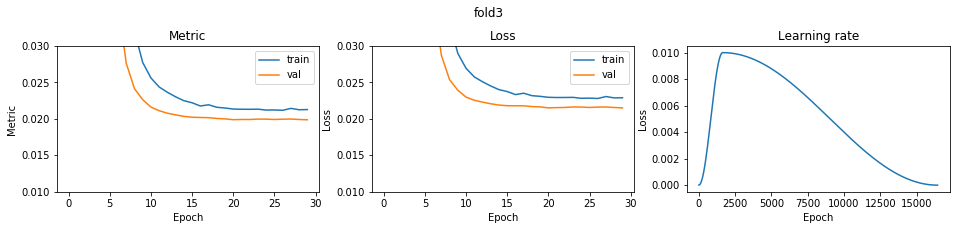

fold 4


epoch1 save best model... 0.7133584084163223
epoch2 save best model... 0.6978927117816951
epoch3 save best model... 0.6268225385007663
epoch4 save best model... 0.33829238583123766
epoch5 save best model... 0.12314432869264368
epoch6 save best model... 0.05601684540883555
epoch7 save best model... 0.03550603447783238
epoch8 save best model... 0.027034816976662105
epoch9 save best model... 0.023946355100814467
epoch10 save best model... 0.022208239891670287
epoch11 save best model... 0.021386532577980896
epoch12 save best model... 0.020856193824753944
epoch13 save best model... 0.020522636559564867
epoch14 save best model... 0.020221139607709198
epoch15 save best model... 0.02002512345468129
epoch16 save best model... 0.02001549467563222
epoch17 save best model... 0.019858976438268172
epoch18 save best model... 0.01969112242765063
epoch19 save best model... 0.019638907509709546
epoch20 save best model... 0.01960947083008045
epoch22 save best model... 0.019561455716168963
epoch23 save be

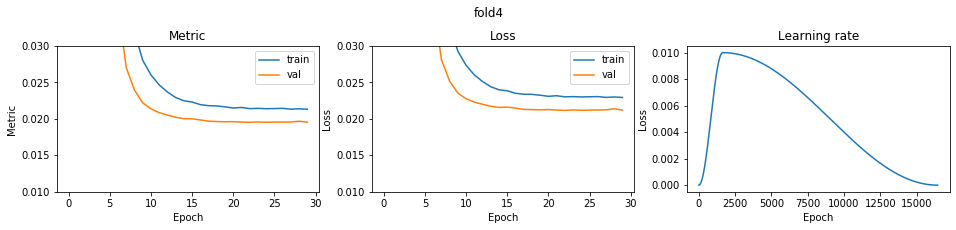

CV score: 0.019714383400852745

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.03716222750943723
epoch2 save best model... 0.019623279949153746
epoch3 save best model... 0.018629251882976986
epoch4 save best model... 0.01797608153169003
epoch5 save best model... 0.017594128500899312
epoch6 save best model... 0.01742574876102201
epoch7 save best model... 0.01734759077293998
epoch8 save best model... 0.01720907891716528
epoch9 save best model... 0.01706133151261437
epoch10 save best model... 0.016932439336506545
epoch11 save best model... 0.01683440081741245
epoch14 save best model... 0.016705428142787925
epoch15 save best model... 0.016653288623364747
epoch16 save best model... 0.01652597999136581
epoch18 save best model... 0.016415402284295114
epoch19 save best model... 0.016333282876819167
epoch20 save best model... 0.016283213393020194
epoch24 save best model... 0.016277071184018343
fold0 score: 0.016277071117066572


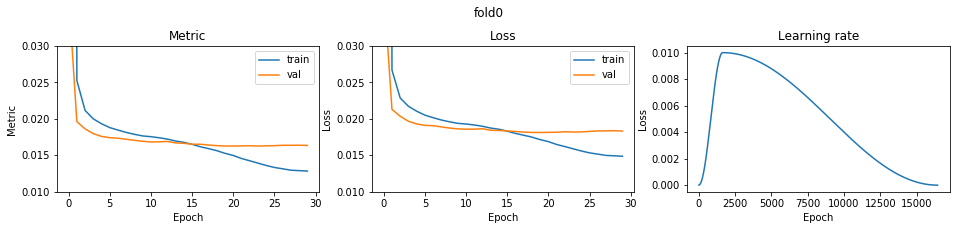

fold 1


epoch1 save best model... 0.03822414377374512
epoch2 save best model... 0.020145211278404265
epoch3 save best model... 0.01881761377684536
epoch4 save best model... 0.018122724573367492
epoch5 save best model... 0.01792669852469418
epoch6 save best model... 0.017509071183543484
epoch8 save best model... 0.017334189243049386
epoch10 save best model... 0.017168460032711896
epoch11 save best model... 0.01715281370184394
epoch13 save best model... 0.016992368442332127
epoch14 save best model... 0.01694241801807714
epoch15 save best model... 0.016874976291290027
epoch16 save best model... 0.01681011575016353
epoch17 save best model... 0.01670890672912825
epoch20 save best model... 0.01669563937912731
epoch21 save best model... 0.01662286179380839
fold1 score: 0.016622861620546547


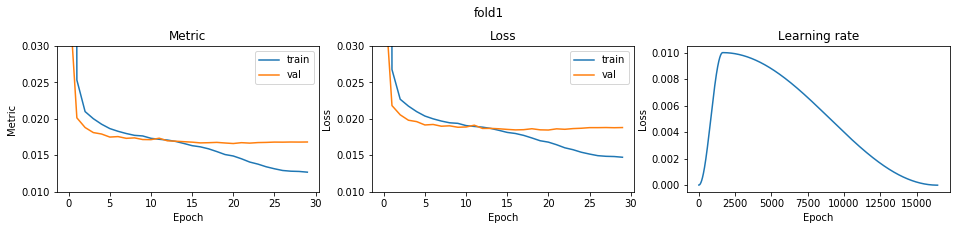

fold 2


epoch1 save best model... 0.03579026840306355
epoch2 save best model... 0.01979500545100936
epoch3 save best model... 0.018525318411304295
epoch4 save best model... 0.018196028264697347
epoch5 save best model... 0.017687575312110213
epoch6 save best model... 0.01747538218723292
epoch7 save best model... 0.017370515719427895
epoch8 save best model... 0.01724814815757812
epoch9 save best model... 0.01704268777621182
epoch10 save best model... 0.01694983826246979
epoch11 save best model... 0.016920717689850574
epoch13 save best model... 0.01683733054693711
epoch14 save best model... 0.016833588820460935
epoch15 save best model... 0.01669172831087639
epoch16 save best model... 0.016554757394405848
epoch18 save best model... 0.016493494928181918
epoch19 save best model... 0.016433554119032617
epoch21 save best model... 0.016368717678768893
epoch22 save best model... 0.016366439401266527
epoch23 save best model... 0.01633786444002022
fold2 score: 0.016337864338917322


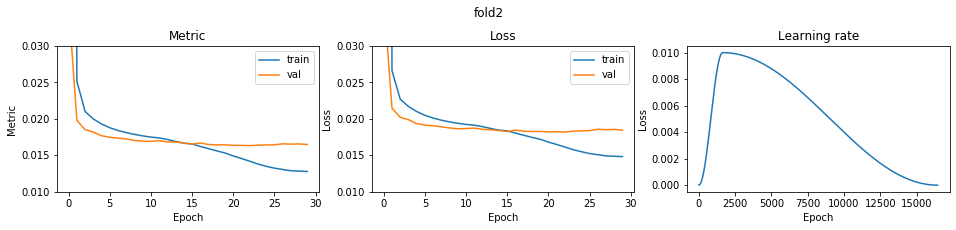

fold 3


epoch1 save best model... 0.03546034961870971
epoch2 save best model... 0.019744823581129653
epoch3 save best model... 0.018729082542919218
epoch4 save best model... 0.01821141909969152
epoch5 save best model... 0.01795305792700525
epoch6 save best model... 0.01770215796387345
epoch7 save best model... 0.017609474248335547
epoch8 save best model... 0.01742113989593296
epoch9 save best model... 0.017323287741486875
epoch10 save best model... 0.017200695709293553
epoch11 save best model... 0.01711990627882353
epoch13 save best model... 0.01708343491246733
epoch14 save best model... 0.016869915069286673
epoch15 save best model... 0.016849944869518824
epoch16 save best model... 0.016814564989459678
epoch17 save best model... 0.0166987471524329
epoch18 save best model... 0.01667400889633253
epoch19 save best model... 0.01657163742399331
epoch21 save best model... 0.016498249857888
fold3 score: 0.016498249777152224


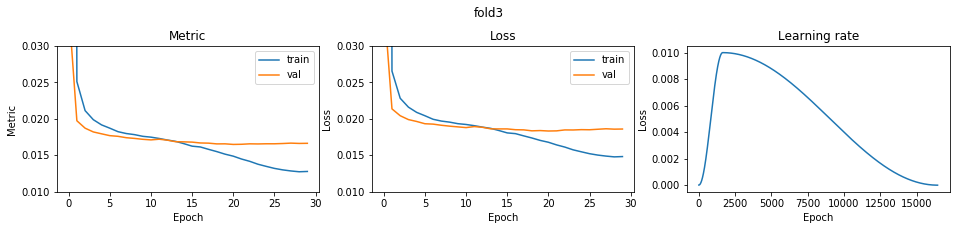

fold 4


epoch1 save best model... 0.0356324068633394
epoch2 save best model... 0.019576815133044552
epoch3 save best model... 0.018539045804555704
epoch4 save best model... 0.01797052329418871
epoch5 save best model... 0.017654902456171285
epoch6 save best model... 0.01763074358284541
epoch7 save best model... 0.017419277075975115
epoch8 save best model... 0.01729851856887137
epoch9 save best model... 0.01712247008215933
epoch10 save best model... 0.017045581773568394
epoch11 save best model... 0.016938480000374394
epoch15 save best model... 0.01670238351945793
epoch16 save best model... 0.016666588390453936
epoch18 save best model... 0.01653345192279794
epoch21 save best model... 0.01646102452671881
fold4 score: 0.01646102451628072


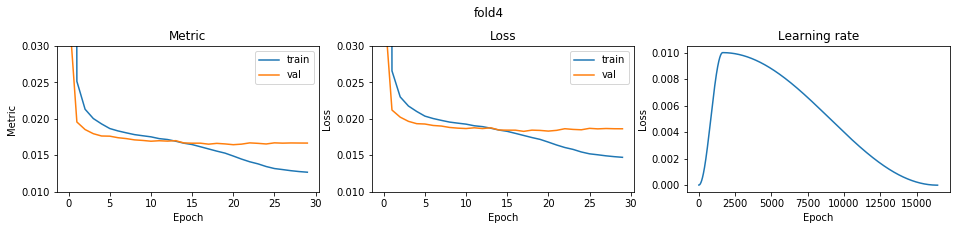

CV score: 0.016439410542563322

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.25194732522367075
epoch2 save best model... 0.02037831512290416
epoch3 save best model... 0.018808240989108563
epoch4 save best model... 0.01814430200564834
epoch5 save best model... 0.017691364589917363
epoch6 save best model... 0.017314613667361284
epoch7 save best model... 0.017260162931164738
epoch8 save best model... 0.017218297332151876
epoch9 save best model... 0.016878227713880613
epoch10 save best model... 0.01686771323560718
epoch11 save best model... 0.016745248674956026
epoch12 save best model... 0.016592334270273634
epoch14 save best model... 0.016537904794537938
epoch15 save best model... 0.016415641298156935
epoch16 save best model... 0.01637568618669461
epoch17 save best model... 0.016334042720208136
epoch19 save best model... 0.01631403124312062
epoch20 save best model... 0.016303935124282142
epoch21 save best model... 0.01626650132238865
fold0 score: 0.016266501182204383


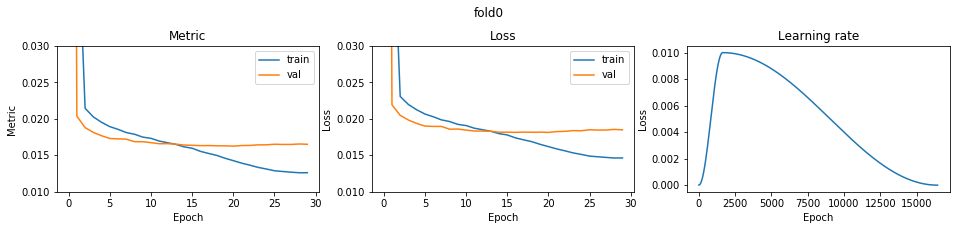

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.2520447580492233
epoch2 save best model... 0.020494358538970178
epoch3 save best model... 0.018969821406914125
epoch4 save best model... 0.018442308356211787
epoch5 save best model... 0.018108144312533412
epoch6 save best model... 0.017694649254951154
epoch7 save best model... 0.017467104305090297
epoch8 save best model... 0.017436677143979274
epoch9 save best model... 0.01713235179286159
epoch11 save best model... 0.01702259698834743
epoch12 save best model... 0.016851031689126512
epoch15 save best model... 0.016746227827672603
epoch16 save best model... 0.016681502617116425
epoch17 save best model... 0.016645871413038568
epoch18 save best model... 0.01654522103637518
fold1 score: 0.01654522098770258


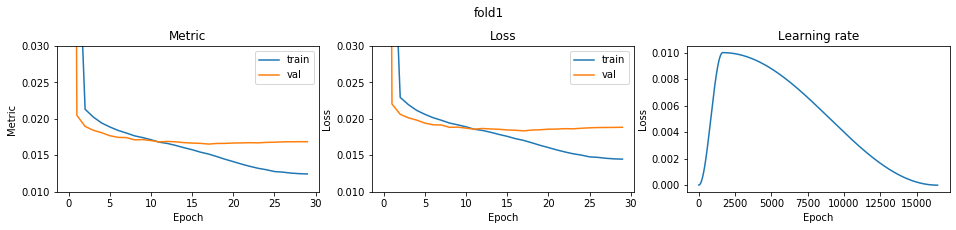

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.25318114006945747
epoch2 save best model... 0.020668011742664597
epoch3 save best model... 0.01907947724636268
epoch4 save best model... 0.018210243592435556
epoch5 save best model... 0.01795438449302725
epoch6 save best model... 0.017472635711443318
epoch8 save best model... 0.017227648118692058
epoch9 save best model... 0.01692077027382123
epoch10 save best model... 0.016900296572117973
epoch12 save best model... 0.016672553687669824
epoch13 save best model... 0.01656216851718457
epoch14 save best model... 0.016481454900490734
epoch15 save best model... 0.016397040818369547
epoch18 save best model... 0.01634543010229523
epoch19 save best model... 0.016327331780514785
epoch22 save best model... 0.016326629105377344
fold2 score: 0.01632662896423379


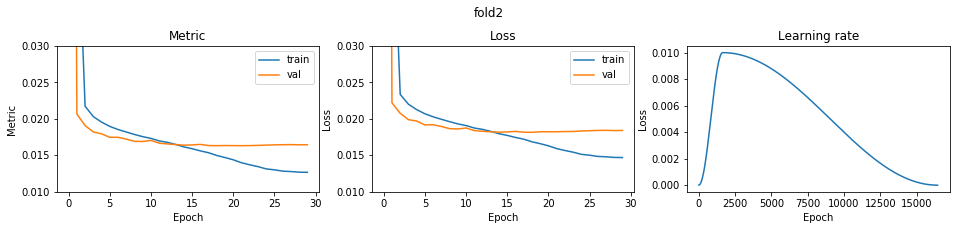

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.25183749404610695
epoch2 save best model... 0.02039216814524492
epoch3 save best model... 0.019306804300848062
epoch4 save best model... 0.01830944614251545
epoch5 save best model... 0.018067179518859996
epoch6 save best model... 0.01765133999585087
epoch7 save best model... 0.0174664955234032
epoch8 save best model... 0.01738679995908824
epoch9 save best model... 0.017197934322160983
epoch10 save best model... 0.017104516195341233
epoch11 save best model... 0.01704797624251837
epoch12 save best model... 0.0168619461446695
epoch13 save best model... 0.01679832134607984
epoch14 save best model... 0.016662837027366314
epoch15 save best model... 0.016631093493541853
epoch16 save best model... 0.016616190113296948
epoch17 save best model... 0.01660286883117126
epoch18 save best model... 0.01656869783115007
epoch19 save best model... 0.016541258965731345
epoch20 save best model... 0.016528230520275026
epoch21 save best model... 0.016518885655867482
fold3 score: 0

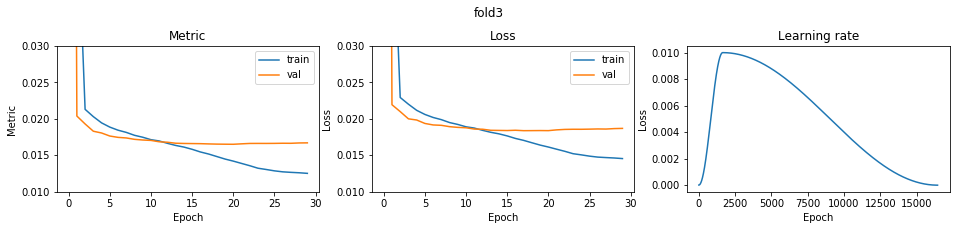

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.25201386541874915
epoch2 save best model... 0.02040718368473113
epoch3 save best model... 0.018921607398430143
epoch4 save best model... 0.018096718246409998
epoch5 save best model... 0.017778868886699436
epoch6 save best model... 0.01745918806226487
epoch8 save best model... 0.017175502347460778
epoch9 save best model... 0.0170903822725346
epoch10 save best model... 0.016926431149702544
epoch11 save best model... 0.016863939791052242
epoch12 save best model... 0.01670687235764531
epoch13 save best model... 0.016610829702287843
epoch15 save best model... 0.0165624429838804
epoch16 save best model... 0.01655090649342822
epoch17 save best model... 0.016469505680024896
fold4 score: 0.016468739732683733


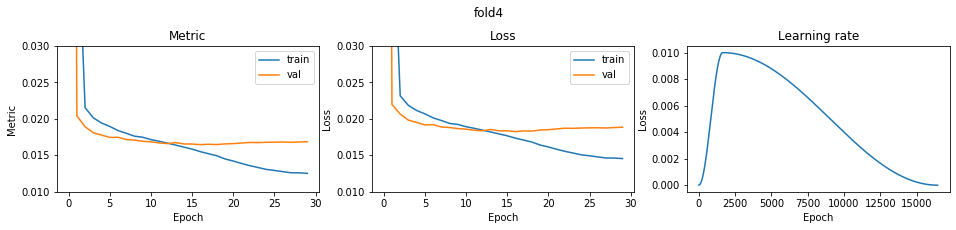

CV score: 0.01642519427730164
                     metric
NovoGrad           0.016306
Adam_CG            0.016316
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
RangerLars         0.016374
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
AdamW_CG           0.016401
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
Ranger_CG          0.016425
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
RAdam_CG           0.016439
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412
PlainRAdam_CG      0.019714


metric
NovoGrad           0.016306
Adam_CG            0.016316
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
RangerLars         0.016374
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
AdamW_CG           0.016401
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
Ranger_CG          0.016425
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
RAdam_CG           0.016439
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412
PlainRAdam_CG      0.019714

In [46]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
]

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score
    
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

In [47]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
NovoGrad           0.016306
Adam_CG            0.016316
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
RangerLars         0.016374
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
AdamW_CG           0.016401
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
Ranger_CG          0.016425
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
RAdam_CG           0.016439
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412
PlainRAdam_CG      0.019714


metric
NovoGrad           0.016306
Adam_CG            0.016316
Yogi               0.016322
SWATS              0.016329
QHAdam             0.016331
Adam               0.016332
AdamP              0.016353
RangerLars         0.016374
LookaheadDiffGrad  0.016383
AdaBelief          0.016388
LookaheadAdam      0.016390
AdamW_CG           0.016401
DiffGrad           0.016404
RangerQH           0.016406
Ranger             0.016407
AdaMod             0.016410
Ranger_CG          0.016425
LookaheadAdamW     0.016430
AdamW              0.016432
PlainRAdam         0.016433
RAdam              0.016438
RAdam_CG           0.016439
Lamb               0.016488
LookaheadYogi      0.016672
RangerVA           0.018422
AdaBound           0.019412
PlainRAdam_CG      0.019714

In [48]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')